In [1]:
## Importing libraries ##

import pymc as pm
import corner
import warnings
import random
warnings.filterwarnings("ignore")

In [2]:
## Importing libraries ##

import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint
import scipy.stats as st
import pytensor
import pytensor.tensor as pt
from pytensor.compile.ops import as_op 
import numbers
import seaborn as sns

from pymc.ode import DifferentialEquation
print(f"Running on PyMC v{pm.__version__}")

RANDOM_SEED = 60
rng = np.random.default_rng(RANDOM_SEED)

Running on PyMC v5.11.0


In [3]:
## PINN values from the previous study ##

G_true = 196.1
eta_s_true = 39.4
k_p_true = 0.06
k_n_true = 0.06
sigma_y_true = 31.1
eta_p_true = 29.1

In [4]:
## Reading stress relaxation data for DOWSIL TC-5622 ##


y0_all = [455.37,472.96,536.06,574.96,622.1] # Initial conditions #
shear_rate_all = [6.0,7.0,8.0,9.0,10.0] # Shear rates #

# Training data #
y0_train = [455.37,472.96,536.06] 
shear_rate_train = [6.0,7.0,8.0]
# lambda_true = [0.8205,0.5875,0.4312,0.3273,0.259,0.216,0.1844,0.1585,0.1373]

shear_stress_global = np.zeros((148,9))
for itr in range(1,10):
  df= pd.read_excel("DOWTC5622-09-02-22_DataUsedToTrainPINN.xlsx",header = None, names=['shear rate','t','shear stress'],sheet_name=itr, skiprows=range(148,296))
  Data = df.to_numpy()
  times = Data[:,1]
  shear_stress_local = Data[:,2]
  shear_stress_global[:,itr-1] = shear_stress_local

shear_stress_training = np.zeros(444,)
shear_stress_training[0:148] = shear_stress_global[:,4]      
shear_stress_training[148:296] = shear_stress_global[:,5]    
shear_stress_training[296:444] = shear_stress_global[:,6]

print(np.shape(shear_stress_training)) # contains data for 6/s, 7/s and 8/s

times_1d = np.append(times,times)
times_1d = np.append(times_1d,times)
times_1d = times_1d.reshape(-1)
print(np.shape(times_1d))

shear_rate_6_idx = 0*np.ones(148)
shear_rate_7_idx = 1*np.ones(148)
shear_rate_8_idx = 2*np.ones(148)
shear_rate_idx = np.append(shear_rate_6_idx,shear_rate_7_idx)
shear_rate_idx = np.append(shear_rate_idx,shear_rate_8_idx)
shear_rate_idx = shear_rate_idx.reshape(-1)
shear_rate_idx = np.asarray(shear_rate_idx,dtype='int')
print(np.shape(shear_rate_idx))

shear_rate_6 = 6.0*np.ones(148)
shear_rate_7 = 7.0*np.ones(148)
shear_rate_8 = 8.0*np.ones(148)
shear_rate_1d = np.append(shear_rate_6,shear_rate_7) 
shear_rate_1d = np.append(shear_rate_1d,shear_rate_8)
shear_rate_1d = shear_rate_1d.reshape(-1)
print(np.shape(shear_rate_1d))

stress_ic_6 = y0_all[0]*np.ones(148)
stress_ic_7 = y0_all[1]*np.ones(148)
stress_ic_8 = y0_all[2]*np.ones(148)
stress_ic_1d = np.append(stress_ic_6,stress_ic_7) 
stress_ic_1d = np.append(stress_ic_1d,stress_ic_8)
stress_ic_1d = stress_ic_1d.reshape(-1)
print(np.shape(stress_ic_1d))


(444,)
(444,)
(444,)
(444,)
(444,)


In [5]:
print(stress_ic_1d)

[455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37
 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37
 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37
 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37
 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37
 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37
 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37
 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37
 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37
 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37
 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37
 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37
 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37
 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37 455.37
 455.3

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


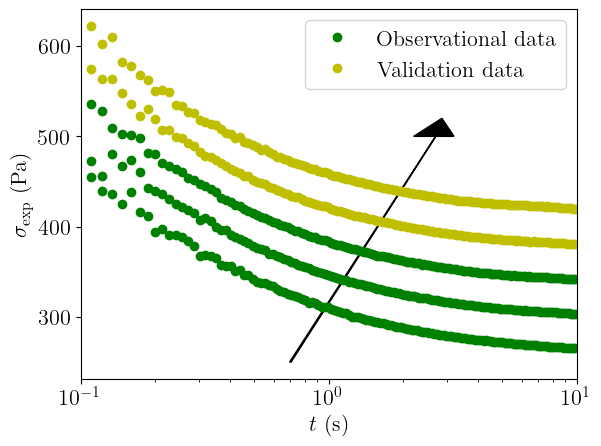

In [6]:
## Plotting stress relaxation data ##

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
sns.set_style(None)

for itr in range(4,10):
    if itr==9:
        plt.plot(np.NaN,np.NaN,'og',alpha=1.0,label='Observational data')
        plt.plot(np.NaN,np.NaN,'oy',alpha=1.0,label='Validation data')
    elif 4<=itr<7:
        plt.plot(times,shear_stress_global[:,itr],'og',alpha=1.0)
    elif 7<=itr<9:
        plt.plot(times,shear_stress_global[:,itr],'oy',alpha=1.0)
    

plt.arrow(0.7,250,2.0,250,head_width=1,head_length=20,fc="k",ec="k",width=0.01)
plt.xlim(0.1,10)
plt.xlabel(r'$t$ (s)')
plt.ylabel(r'$\sigma_{\mathrm{exp}}$ (Pa)')
plt.xscale('log')
plt.legend()
plt.savefig('TEVP_Training_data.png',format='png',bbox_inches='tight')
plt.savefig('TEVP_Training_data.eps',format='eps',bbox_inches='tight')
plt.show()

In [7]:
# print(shear_rate_idx)

In [8]:
## Defining min and max values to infer all model parameters between 0-1 ##
G_min = 100 #100
G_max = 600 #600
eta_s_min = 10 #0 
eta_s_max = 50 
k_p_min = 0.01 #0
k_p_max = 0.25 #0.1
k_n_min = 0.01 #0
k_n_max = 0.25 #0.2
sigma_y_min = 5 #0
sigma_y_max = 150 #100 #75 #50
eta_p_min = 10 #0 
eta_p_max = 75 #50 

## Analytical solution of the TEVP constitutive model ##
def shear_stress_analytical(G,eta_s,k_p,k_n,sigma_y,eta_p,shear_rate_ode,stress_ic,lambda_ic,time_ode):
    # input arguments of model parameters range is 0-1
    # dimensionalizing the model parameters
    G_d = G*(G_max-G_min) + G_min
    eta_s_d = eta_s*(eta_s_max-eta_s_min) + eta_s_min
    k_p_d = k_p*(k_p_max-k_p_min) + k_p_min
    k_n_d = k_n*(k_n_max-k_n_min) + k_n_min
    sigma_y_d = sigma_y*(sigma_y_max-sigma_y_min) + sigma_y_min
    eta_p_d = eta_p*(eta_p_max-eta_p_min) + eta_p_min

    T = (k_p_d + k_n_d*shear_rate_ode)/(G_d/(eta_s_d+eta_p_d))
    R = k_p_d/(k_p_d + k_n_d*shear_rate_ode) 

    shear_stress_an = eta_s_d*shear_rate_ode +(sigma_y_d+eta_p_d*shear_rate_ode)*R + \
               (stress_ic - eta_s_d*shear_rate_ode + (sigma_y_d+eta_p_d*shear_rate_ode)*((lambda_ic-R*T)/(T-1)))*np.exp(-G_d*(time_ode-0.11)/(eta_s_d+eta_p_d)) + \
               (sigma_y_d+eta_p_d*shear_rate_ode)*((R-lambda_ic)/(T-1))*np.exp(-(k_p_d+k_n_d*shear_rate_ode)*(time_ode-0.11))
    
    return shear_stress_an

In [9]:
#coords = {"time_coord": times, "shear_rate_coord": shear_rate_all}
coords = {"shear_rate_coord": shear_rate_train}

In [10]:
## Defining the UQ model ##
with pm.Model(coords=coords) as model_678:
    time_data = pm.ConstantData("time_data", times_1d, dims="obs_id")
    shear_rate_data = pm.ConstantData("shear_rate_data", shear_rate_train, dims="shear_rate_coord")
    print(pm.draw(time_data).size)
    
    mu_g = pm.Beta("mu_g",alpha=2.0,beta=2.0) 
    #mu_g = pm.Normal("mu_g",mu=0.0,sigma=1.0)
    sigma_g = pm.HalfNormal("sigma_g",sigma=0.05) #0.01
    
    mu_eta_s = pm.Beta("mu_eta_s",alpha=2.0,beta=2.0)
    #mu_eta_s = pm.Normal("mu_eta_s",mu=0.0,sigma=1.0)
    sigma_eta_s = pm.HalfNormal("sigma_eta_s",sigma=0.05)

    mu_k_p = pm.Beta("mu_k_p",alpha=2.0,beta=2.0)
    #mu_k_p = pm.Normal("mu_k_p",mu=0.0,sigma=1.0)
    sigma_k_p = pm.HalfNormal("sigma_k_p",sigma=0.05)

    mu_k_n = pm.Beta("mu_k_n",alpha=2.0,beta=2.0)
    #mu_k_n = pm.Normal("mu_k_n",mu=0.0,sigma=1.0)
    sigma_k_n = pm.HalfNormal("sigma_k_n",sigma=0.05)
    
    mu_sigma_y = pm.Beta("mu_sigma_y",alpha=2.0,beta=2.0)
    #mu_sigma_y = pm.Normal("mu_sigma_y",mu=0.0,sigma=1.0)
    sigma_sigma_y = pm.HalfNormal("sigma_sigma_y",sigma=0.05)

    mu_eta_p = pm.Beta("mu_eta_p",alpha=2.0,beta=2.0)
    #mu_eta_p = pm.Normal("mu_eta_p",mu=0.0,sigma=1.0)
    sigma_eta_p = pm.HalfNormal("sigma_eta_p",sigma=0.05)

    #mu_lambda_ic = pm.Beta("mu_lambda_ic",alpha=2.0,beta=2.0)
    #sigma_lambda_ic = pm.HalfNormal("sigma_lambda_ic",sigma=0.1)
    
    ## Priors: dimensional unknown model parameters using non-centered paramterization ##
    z_G = pm.Normal("z_G",mu=0,sigma=1,dims="shear_rate_coord")
    G = pm.Deterministic("G", mu_g+sigma_g*z_G, dims="shear_rate_coord")
    G_dd = pm.Deterministic("G_dd", G*(G_max-G_min)+G_min, dims="shear_rate_coord")
    
    z_eta_s = pm.Normal("z_eta_s",mu=0,sigma=1,dims="shear_rate_coord")
    eta_s = pm.Deterministic("eta_s", mu_eta_s + sigma_eta_s*z_eta_s, dims="shear_rate_coord")
    eta_s_dd = pm.Deterministic("eta_s_dd", eta_s*(eta_s_max-eta_s_min)+eta_s_min, dims="shear_rate_coord")

    z_k_p = pm.Normal("z_k_p",mu=0,sigma=1,dims="shear_rate_coord")
    k_p = pm.Deterministic("k_p", mu_k_p + sigma_k_p*z_k_p, dims="shear_rate_coord")
    k_p_dd = pm.Deterministic("k_p_dd", k_p*(k_p_max-k_p_min)+k_p_min, dims="shear_rate_coord")

    z_k_n = pm.Normal("z_k_n",mu=0,sigma=1,dims="shear_rate_coord")
    k_n = pm.Deterministic("k_n", mu_k_n + sigma_k_n*z_k_n, dims="shear_rate_coord")
    k_n_dd = pm.Deterministic("k_n_dd", k_n*(k_n_max-k_n_min)+k_n_min, dims="shear_rate_coord")
    
    z_sigma_y = pm.Normal("z_sigma_y",mu=0,sigma=1,dims="shear_rate_coord")
    sigma_y = pm.Deterministic("sigma_y", mu_sigma_y + sigma_sigma_y*z_sigma_y, dims="shear_rate_coord")
    sigma_y_dd = pm.Deterministic("sigma_y_dd", sigma_y*(sigma_y_max-sigma_y_min)+sigma_y_min, dims="shear_rate_coord")

    z_eta_p = pm.Normal("z_eta_p",mu=0,sigma=1,dims="shear_rate_coord")
    eta_p = pm.Deterministic("eta_p", mu_eta_p + sigma_eta_p*z_eta_p, dims="shear_rate_coord")
    eta_p_dd = pm.Deterministic("eta_p_dd", eta_p*(eta_p_max-eta_p_min)+eta_p_min, dims="shear_rate_coord")

    # Microstructure parameter #
    lambda_a = pm.Beta("lambda_a", alpha=2.0, beta=5.0) #, dims="shear_rate_coord")
    lambda_b = pm.Beta("lambda_b",alpha=2.0, beta=5.0) #, dims="shear_rate_coord")
    lambda_ic = pm.Deterministic("lambda_ic",lambda_a*np.exp(-lambda_b*(shear_rate_data)), dims="shear_rate_coord")
    
    T_dd = pm.Deterministic("T_dd", (k_p_dd + k_n_dd*shear_rate_data)/(G_dd/(eta_s_dd+eta_p_dd)), dims="shear_rate_coord")
    R_dd = pm.Deterministic("R_dd", k_p_dd/(k_p_dd + k_n_dd*shear_rate_data), dims="shear_rate_coord")
    
    ## Experiment measurement uncertainty ##
    sigma = pm.Exponential("sigma", 2.0) 

    shear_stress_mean = eta_s_dd[shear_rate_idx]*shear_rate_1d + (sigma_y_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx]*shear_rate_1d)*R_dd[shear_rate_idx] + \
               (stress_ic_1d  - eta_s_dd[shear_rate_idx]*shear_rate_1d + (sigma_y_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx]*shear_rate_1d)*((lambda_ic[shear_rate_idx]-R_dd[shear_rate_idx]*T_dd[shear_rate_idx])/(T_dd[shear_rate_idx]-1)))*np.exp(-G_dd[shear_rate_idx]*(time_data-0.11)/(eta_s_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx])) + \
               (sigma_y_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx]*shear_rate_1d)*((R_dd[shear_rate_idx]-lambda_ic[shear_rate_idx])/(T_dd[shear_rate_idx]-1))*np.exp(-(k_p_dd[shear_rate_idx]+k_n_dd[shear_rate_idx]*shear_rate_1d)*(time_data-0.11))
    

    ## Likelihood ##
    pm.Normal("Y_obs", mu=shear_stress_mean, sigma=sigma, observed=shear_stress_training, dims = "obs_id") 
    idata_678 = pm.sample_prior_predictive(samples=10000, random_seed=rng)

print(idata_678)

444


Sampling: [Y_obs, lambda_a, lambda_b, mu_eta_p, mu_eta_s, mu_g, mu_k_n, mu_k_p, mu_sigma_y, sigma, sigma_eta_p, sigma_eta_s, sigma_g, sigma_k_n, sigma_k_p, sigma_sigma_y, z_G, z_eta_p, z_eta_s, z_k_n, z_k_p, z_sigma_y]


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data


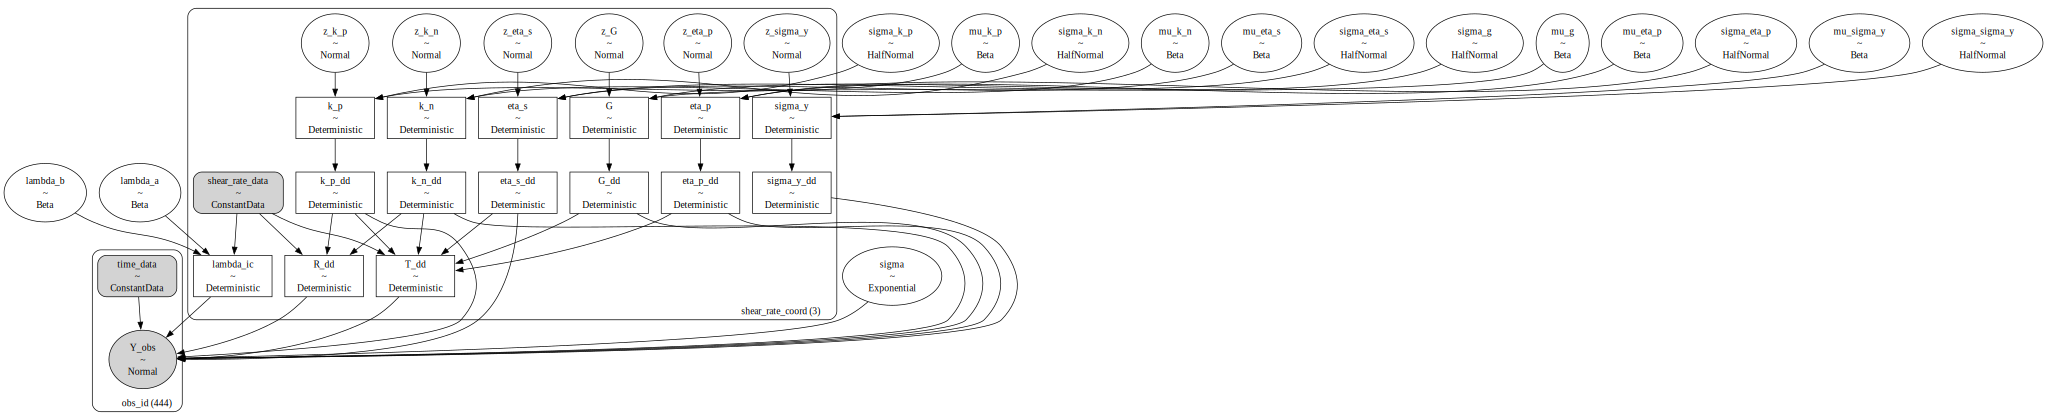

In [11]:
pm.model_to_graphviz(model=model_678)

In [12]:
# Plotting priors to understand data-construction within imdata_df datadrame #

imdata_df = az.extract(idata_678, group = "prior", num_samples=2).to_dataframe()
print(imdata_df)
cols = ["mu_g", "mu_eta_s", "mu_k_p", "mu_k_n", "mu_sigma_y", "mu_eta_p"]
row = imdata_df.iloc[0, :][cols].values
print(row)
cols = ["sigma_g", "sigma_eta_s", "sigma_k_p", "sigma_k_n", "sigma_sigma_y", "sigma_eta_p"]
row = imdata_df.iloc[0, :][cols].values
print(row)
cols = ["z_G", "z_eta_s", "z_k_p", "z_k_n", "z_sigma_y", "z_eta_p"]
row = imdata_df.iloc[0, :][cols].values
print(row)
cols = ["G", "eta_s", "k_p", "k_n", "sigma_y", "eta_p"]
row = imdata_df.iloc[0, :][cols].values
print(row)


                             sigma_k_n     eta_s       z_G  z_sigma_y  \
chain draw shear_rate_coord                                             
0     6668 6.0                0.049970  0.806976  1.511505   1.538365   
           7.0                0.049970  0.813039  0.068967  -2.708816   
           8.0                0.049970  0.742113 -1.626345   0.285112   
      7827 6.0                0.011195  0.512380 -0.270885   0.264667   
           7.0                0.011195  0.469921 -0.128490   1.245890   
           8.0                0.011195  0.495665 -0.819742  -0.779368   

                               mu_k_p   eta_s_dd     z_k_p     eta_p  \
chain draw shear_rate_coord                                            
0     6668 6.0               0.406754  42.279047  0.529649  0.633052   
           7.0               0.406754  42.521551 -1.254974  0.630252   
           8.0               0.406754  39.684507 -0.879380  0.640472   
      7827 6.0               0.437311  30.495207 -0.343

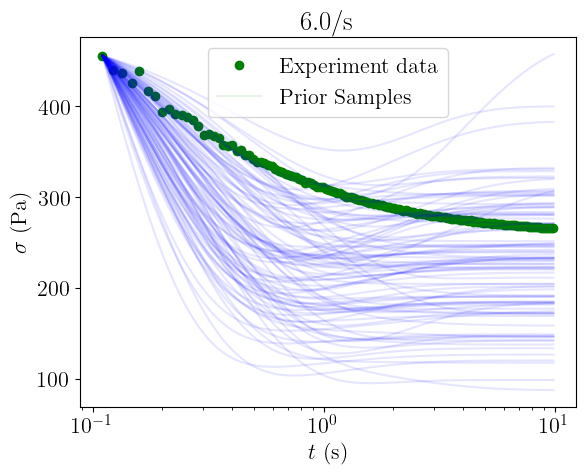

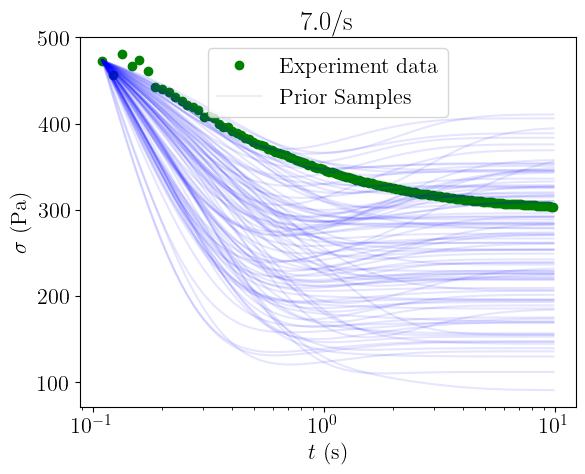

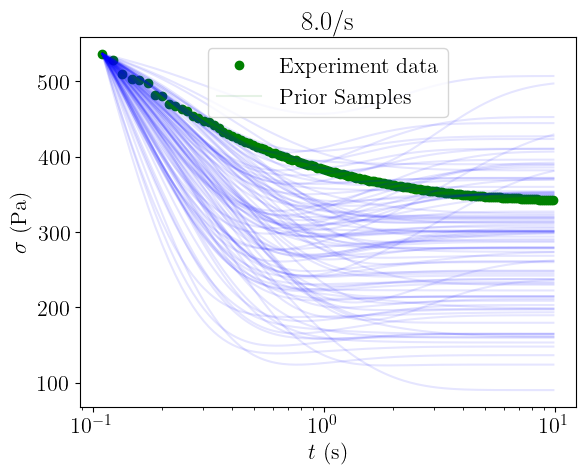

In [13]:
## Plotting priors - before sampling ##

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"

num_samples = 100
imdata_prior = az.extract(idata_678, group = "prior", num_samples=num_samples).to_dataframe()
#print(imdata_df)
cols = ["G", "eta_s", "k_p", "k_n", "sigma_y", "eta_p", "lambda_ic"]

# arg: 0 (2/s); 1 (3/s); 2 (4/s); 3 (5/s); 4 (6/s); 5 (7/s); 6 (8/s);
arg = 0
shear_rate_ode = shear_rate_all[arg]
y0 = y0_all[arg]
lambda_0 = 1
shear_stress_expt = shear_stress_global[:,arg+4]

plt.plot(times,shear_stress_expt,'og', label='Experiment data')
for row_idx in range(0,num_samples*3,3):
  row = imdata_prior.iloc[row_idx, :][cols].values
  theta = row
  # Using dimensional time as input to get dimensional shear_stress as output
  shear_stress_an = shear_stress_analytical(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],shear_rate_ode,y0,theta[6],times)#,shear_rate_1d,times_1d)
  plt.plot(times,shear_stress_an,'-b',alpha=0.1)
plt.plot(np.NaN,np.NaN,'-g',alpha=0.1,label='Prior Samples')

plt.title(r'$6.0$/s')
plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
plt.xscale('log')
plt.legend()
#plt.savefig('2_s_prior.png',format='png',bbox_inches='tight')
plt.show()

arg = 1
shear_rate_ode = shear_rate_all[arg]
y0 = y0_all[arg]
lambda_0 = 1
stress_analytical_pinn = shear_stress_analytical((G_true-G_min)/(G_max-G_min),(eta_s_true-eta_s_min)/(eta_s_max-eta_s_min),\
                                                 (k_p_true-k_p_min)/(k_p_max-k_p_min),(k_n_true-k_n_min)/(k_n_max-k_n_min),\
                                                 (sigma_y_true-sigma_y_min)/(sigma_y_max-sigma_y_min),(eta_p_true-eta_p_min)/(eta_p_max-eta_p_min),\
                                                 shear_rate_ode,y0,lambda_0,times)
shear_stress_expt = shear_stress_global[:,arg+4]

plt.plot(times,shear_stress_expt,'og', label='Experiment data')
for row_idx in range(1,num_samples*3,3):
  row = imdata_prior.iloc[row_idx, :][cols].values
  theta = row
  # Using dimensional time as input to get dimensional shear_stress as output
  shear_stress_an = shear_stress_analytical(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],shear_rate_ode,y0,theta[6],times)#,shear_rate_1d,times_1d)
  plt.plot(times,shear_stress_an,'-b',alpha=0.1)
plt.plot(np.NaN,np.NaN,'-g',alpha=0.1,label='Prior Samples')

plt.title(r'$7.0$/s')
plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
plt.xscale('log')
plt.legend()
#plt.savefig('3_s_prior.png',format='png',bbox_inches='tight')
plt.show()

arg = 2
shear_rate_ode = shear_rate_all[arg]
y0 = y0_all[arg]
lambda_0 = 1
stress_analytical_pinn = shear_stress_analytical((G_true-G_min)/(G_max-G_min),(eta_s_true-eta_s_min)/(eta_s_max-eta_s_min),\
                                                 (k_p_true-k_p_min)/(k_p_max-k_p_min),(k_n_true-k_n_min)/(k_n_max-k_n_min),\
                                                 (sigma_y_true-sigma_y_min)/(sigma_y_max-sigma_y_min),(eta_p_true-eta_p_min)/(eta_p_max-eta_p_min),\
                                                 shear_rate_ode,y0,lambda_0,times)
shear_stress_expt = shear_stress_global[:,arg+4]

plt.plot(times,shear_stress_expt,'og', label='Experiment data')
#plt.plot(times,stress_analytical_pinn,'-k', label='PINN analytical solution',linewidth=3)
for row_idx in range(2,num_samples*3,3):
  row = imdata_prior.iloc[row_idx, :][cols].values
  theta = row
  # Using dimensional time as input to get dimensional shear_stress as output
  shear_stress_an = shear_stress_analytical(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],shear_rate_ode,y0,theta[6],times)#,shear_rate_1d,times_1d)
  #stress_odes = odeint(dy_dt,theta[5],t,args=(theta[0],theta[1],theta[2],theta[3],theta[4],shear_rate_ode))
  plt.plot(times,shear_stress_an,'-b',alpha=0.1)
plt.plot(np.NaN,np.NaN,'-g',alpha=0.1,label='Prior Samples')

plt.title(r'$8.0$/s')
plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
plt.xscale('log')
plt.legend()
#plt.savefig('4_s_prior.png',format='png',bbox_inches='tight')
plt.show()


In [14]:
## Using NUTS algorithm to tune and draw samples ##
tune = 2000 
draws = 10000 
with model_678:
    idata_678.extend(pm.sample(tune=tune, draws=draws, target_accept=0.85, random_seed=rng, discard_tuned_samples=True))
print(idata_678)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_g, sigma_g, mu_eta_s, sigma_eta_s, mu_k_p, sigma_k_p, mu_k_n, sigma_k_n, mu_sigma_y, sigma_sigma_y, mu_eta_p, sigma_eta_p, z_G, z_eta_s, z_k_p, z_k_n, z_sigma_y, z_eta_p, lambda_a, lambda_b, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 7173 seconds.
There were 284 divergences after tuning. Increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data


array([[<Axes: title={'center': 'mu_g'}>,
        <Axes: title={'center': 'mu_g'}>],
       [<Axes: title={'center': 'mu_eta_s'}>,
        <Axes: title={'center': 'mu_eta_s'}>],
       [<Axes: title={'center': 'mu_k_p'}>,
        <Axes: title={'center': 'mu_k_p'}>],
       [<Axes: title={'center': 'mu_k_n'}>,
        <Axes: title={'center': 'mu_k_n'}>],
       [<Axes: title={'center': 'mu_sigma_y'}>,
        <Axes: title={'center': 'mu_sigma_y'}>],
       [<Axes: title={'center': 'mu_eta_p'}>,
        <Axes: title={'center': 'mu_eta_p'}>],
       [<Axes: title={'center': 'lambda_a'}>,
        <Axes: title={'center': 'lambda_a'}>],
       [<Axes: title={'center': 'lambda_b'}>,
        <Axes: title={'center': 'lambda_b'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

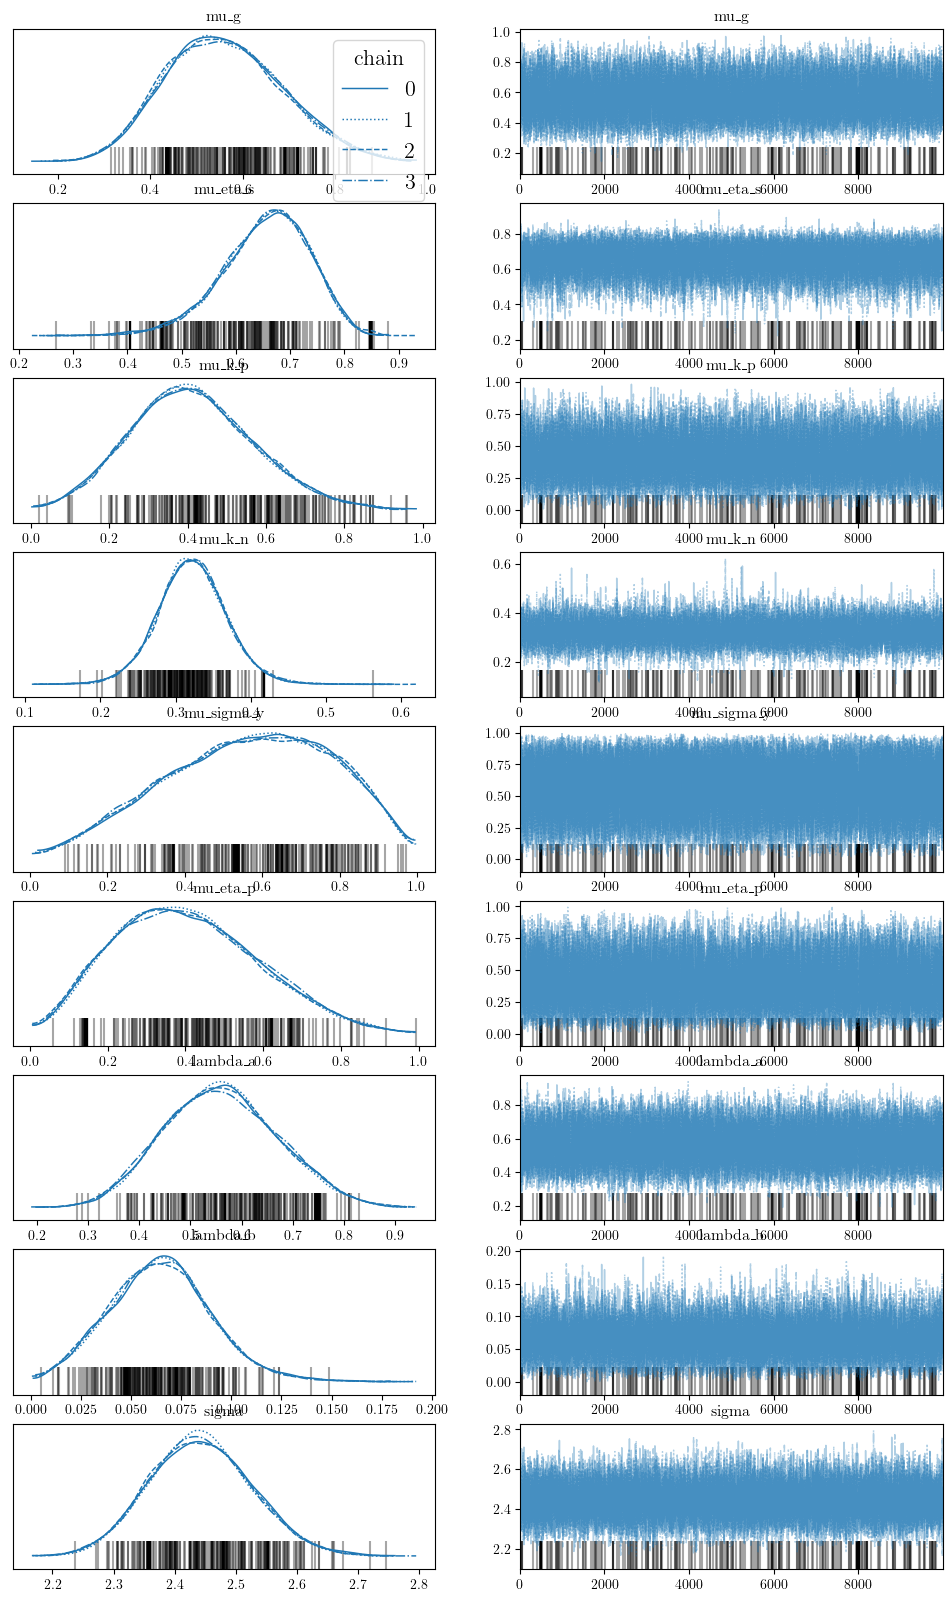

In [15]:
# Plotting trace plots #
az.plot_trace(idata_678,var_names=["mu_g", "mu_eta_s", "mu_k_p", "mu_k_n", "mu_sigma_y", "mu_eta_p", "lambda_a", "lambda_b","sigma"],figsize=(12,20),rug=False,legend=True)

array([[<Axes: title={'center': 'sigma_g'}>,
        <Axes: title={'center': 'sigma_g'}>],
       [<Axes: title={'center': 'sigma_eta_s'}>,
        <Axes: title={'center': 'sigma_eta_s'}>],
       [<Axes: title={'center': 'sigma_k_p'}>,
        <Axes: title={'center': 'sigma_k_p'}>],
       [<Axes: title={'center': 'sigma_k_n'}>,
        <Axes: title={'center': 'sigma_k_n'}>],
       [<Axes: title={'center': 'sigma_sigma_y'}>,
        <Axes: title={'center': 'sigma_sigma_y'}>],
       [<Axes: title={'center': 'sigma_eta_p'}>,
        <Axes: title={'center': 'sigma_eta_p'}>]], dtype=object)

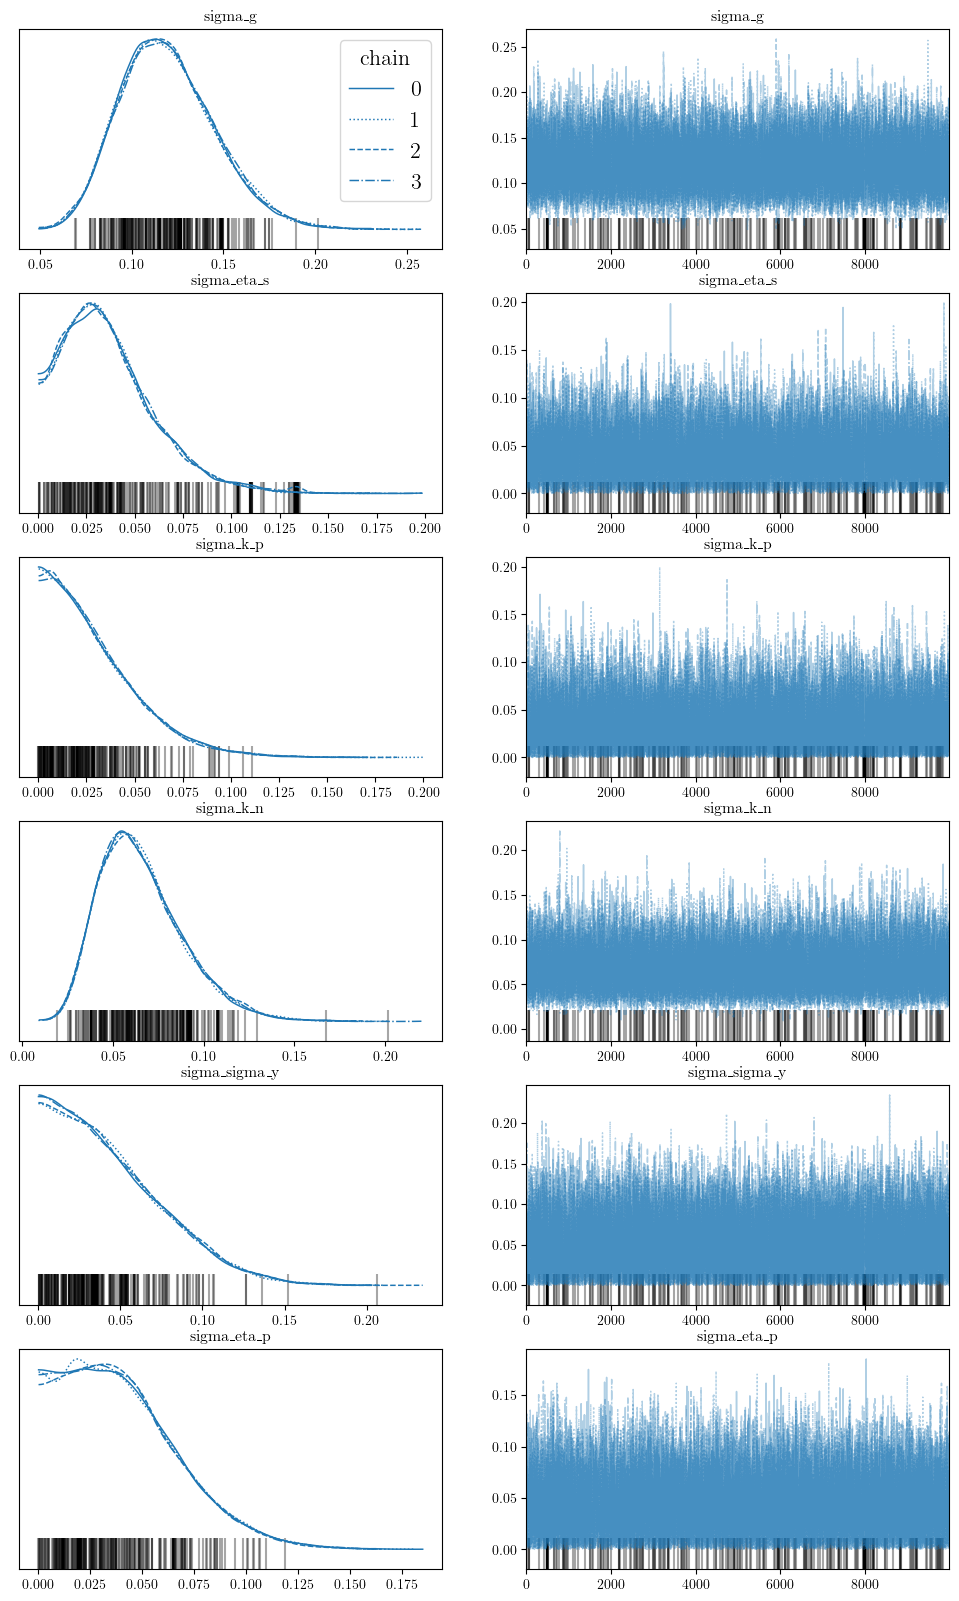

In [16]:
# Plotting trace plots #
az.plot_trace(idata_678,var_names=["sigma_g", "sigma_eta_s", "sigma_k_p", "sigma_k_n", "sigma_sigma_y", "sigma_eta_p"],figsize=(12,20),rug=False,legend=True)

array([[<Axes: title={'center': 'z_G'}>, <Axes: title={'center': 'z_G'}>],
       [<Axes: title={'center': 'z_eta_s'}>,
        <Axes: title={'center': 'z_eta_s'}>],
       [<Axes: title={'center': 'z_k_p'}>,
        <Axes: title={'center': 'z_k_p'}>],
       [<Axes: title={'center': 'z_k_n'}>,
        <Axes: title={'center': 'z_k_n'}>],
       [<Axes: title={'center': 'z_sigma_y'}>,
        <Axes: title={'center': 'z_sigma_y'}>],
       [<Axes: title={'center': 'z_eta_p'}>,
        <Axes: title={'center': 'z_eta_p'}>]], dtype=object)

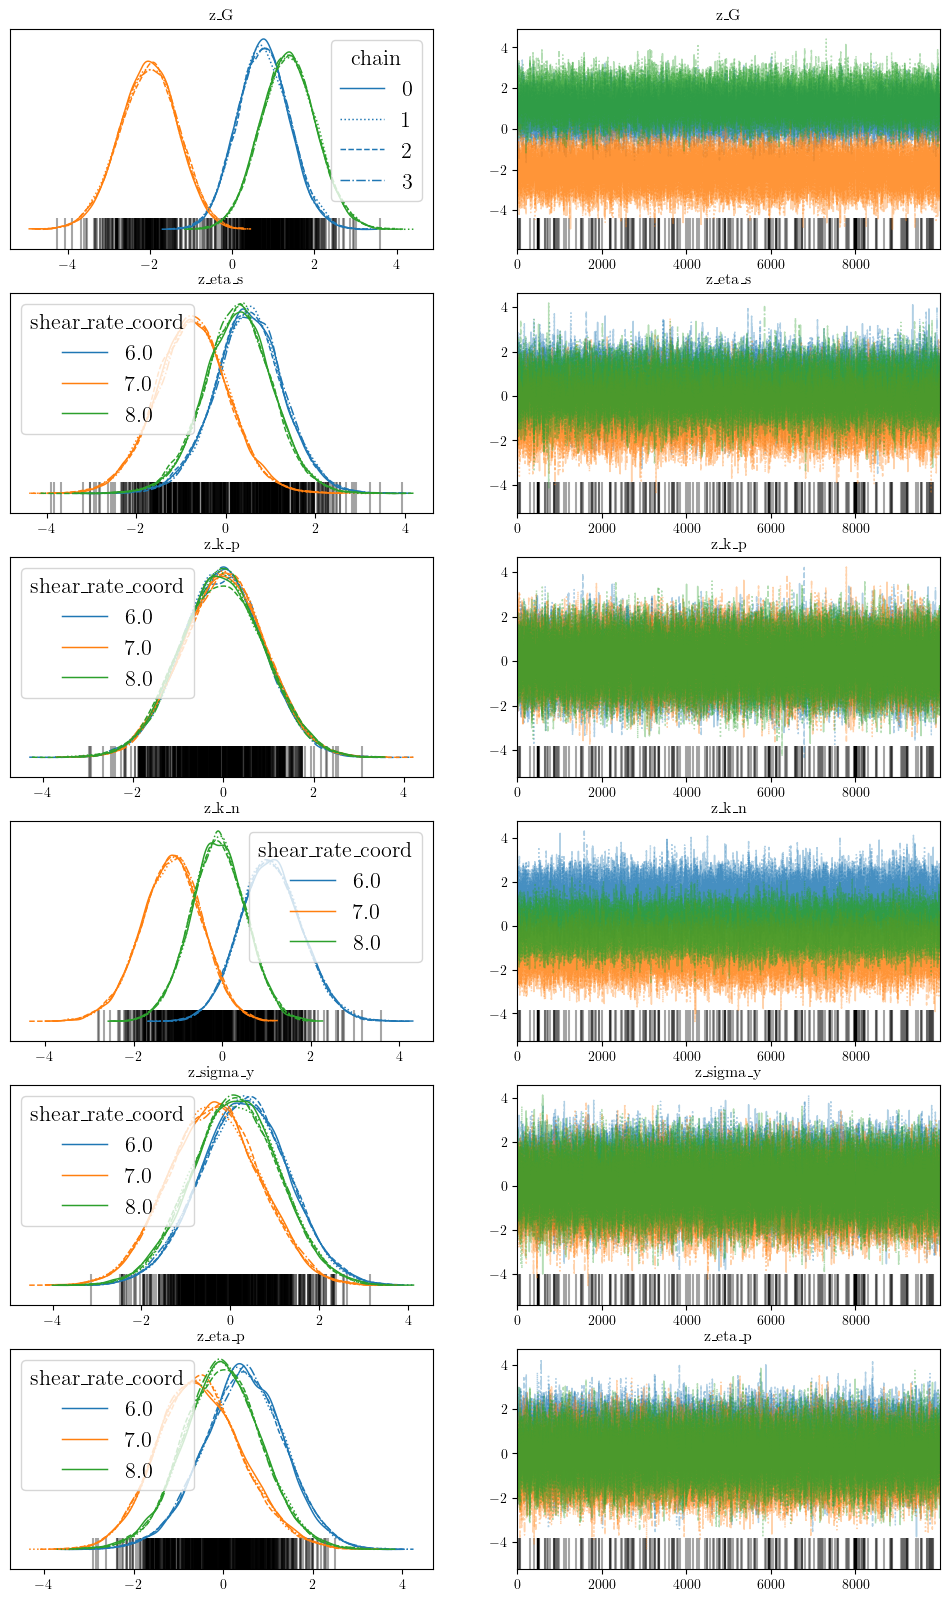

In [17]:
# Plotting trace plots #
az.plot_trace(idata_678,var_names=["z_G", "z_eta_s", "z_k_p", "z_k_n", "z_sigma_y", "z_eta_p"],figsize=(12,20),rug=False,legend=True)

array([[<Axes: title={'center': 'mu_g\n0'}>,
        <Axes: title={'center': 'mu_g\n1'}>,
        <Axes: title={'center': 'mu_g\n2'}>,
        <Axes: title={'center': 'mu_g\n3'}>],
       [<Axes: title={'center': 'mu_eta_s\n0'}>,
        <Axes: title={'center': 'mu_eta_s\n1'}>,
        <Axes: title={'center': 'mu_eta_s\n2'}>,
        <Axes: title={'center': 'mu_eta_s\n3'}>],
       [<Axes: title={'center': 'mu_k_p\n0'}>,
        <Axes: title={'center': 'mu_k_p\n1'}>,
        <Axes: title={'center': 'mu_k_p\n2'}>,
        <Axes: title={'center': 'mu_k_p\n3'}>],
       [<Axes: title={'center': 'mu_k_n\n0'}>,
        <Axes: title={'center': 'mu_k_n\n1'}>,
        <Axes: title={'center': 'mu_k_n\n2'}>,
        <Axes: title={'center': 'mu_k_n\n3'}>],
       [<Axes: title={'center': 'mu_sigma_y\n0'}>,
        <Axes: title={'center': 'mu_sigma_y\n1'}>,
        <Axes: title={'center': 'mu_sigma_y\n2'}>,
        <Axes: title={'center': 'mu_sigma_y\n3'}>],
       [<Axes: title={'center': 'mu_eta

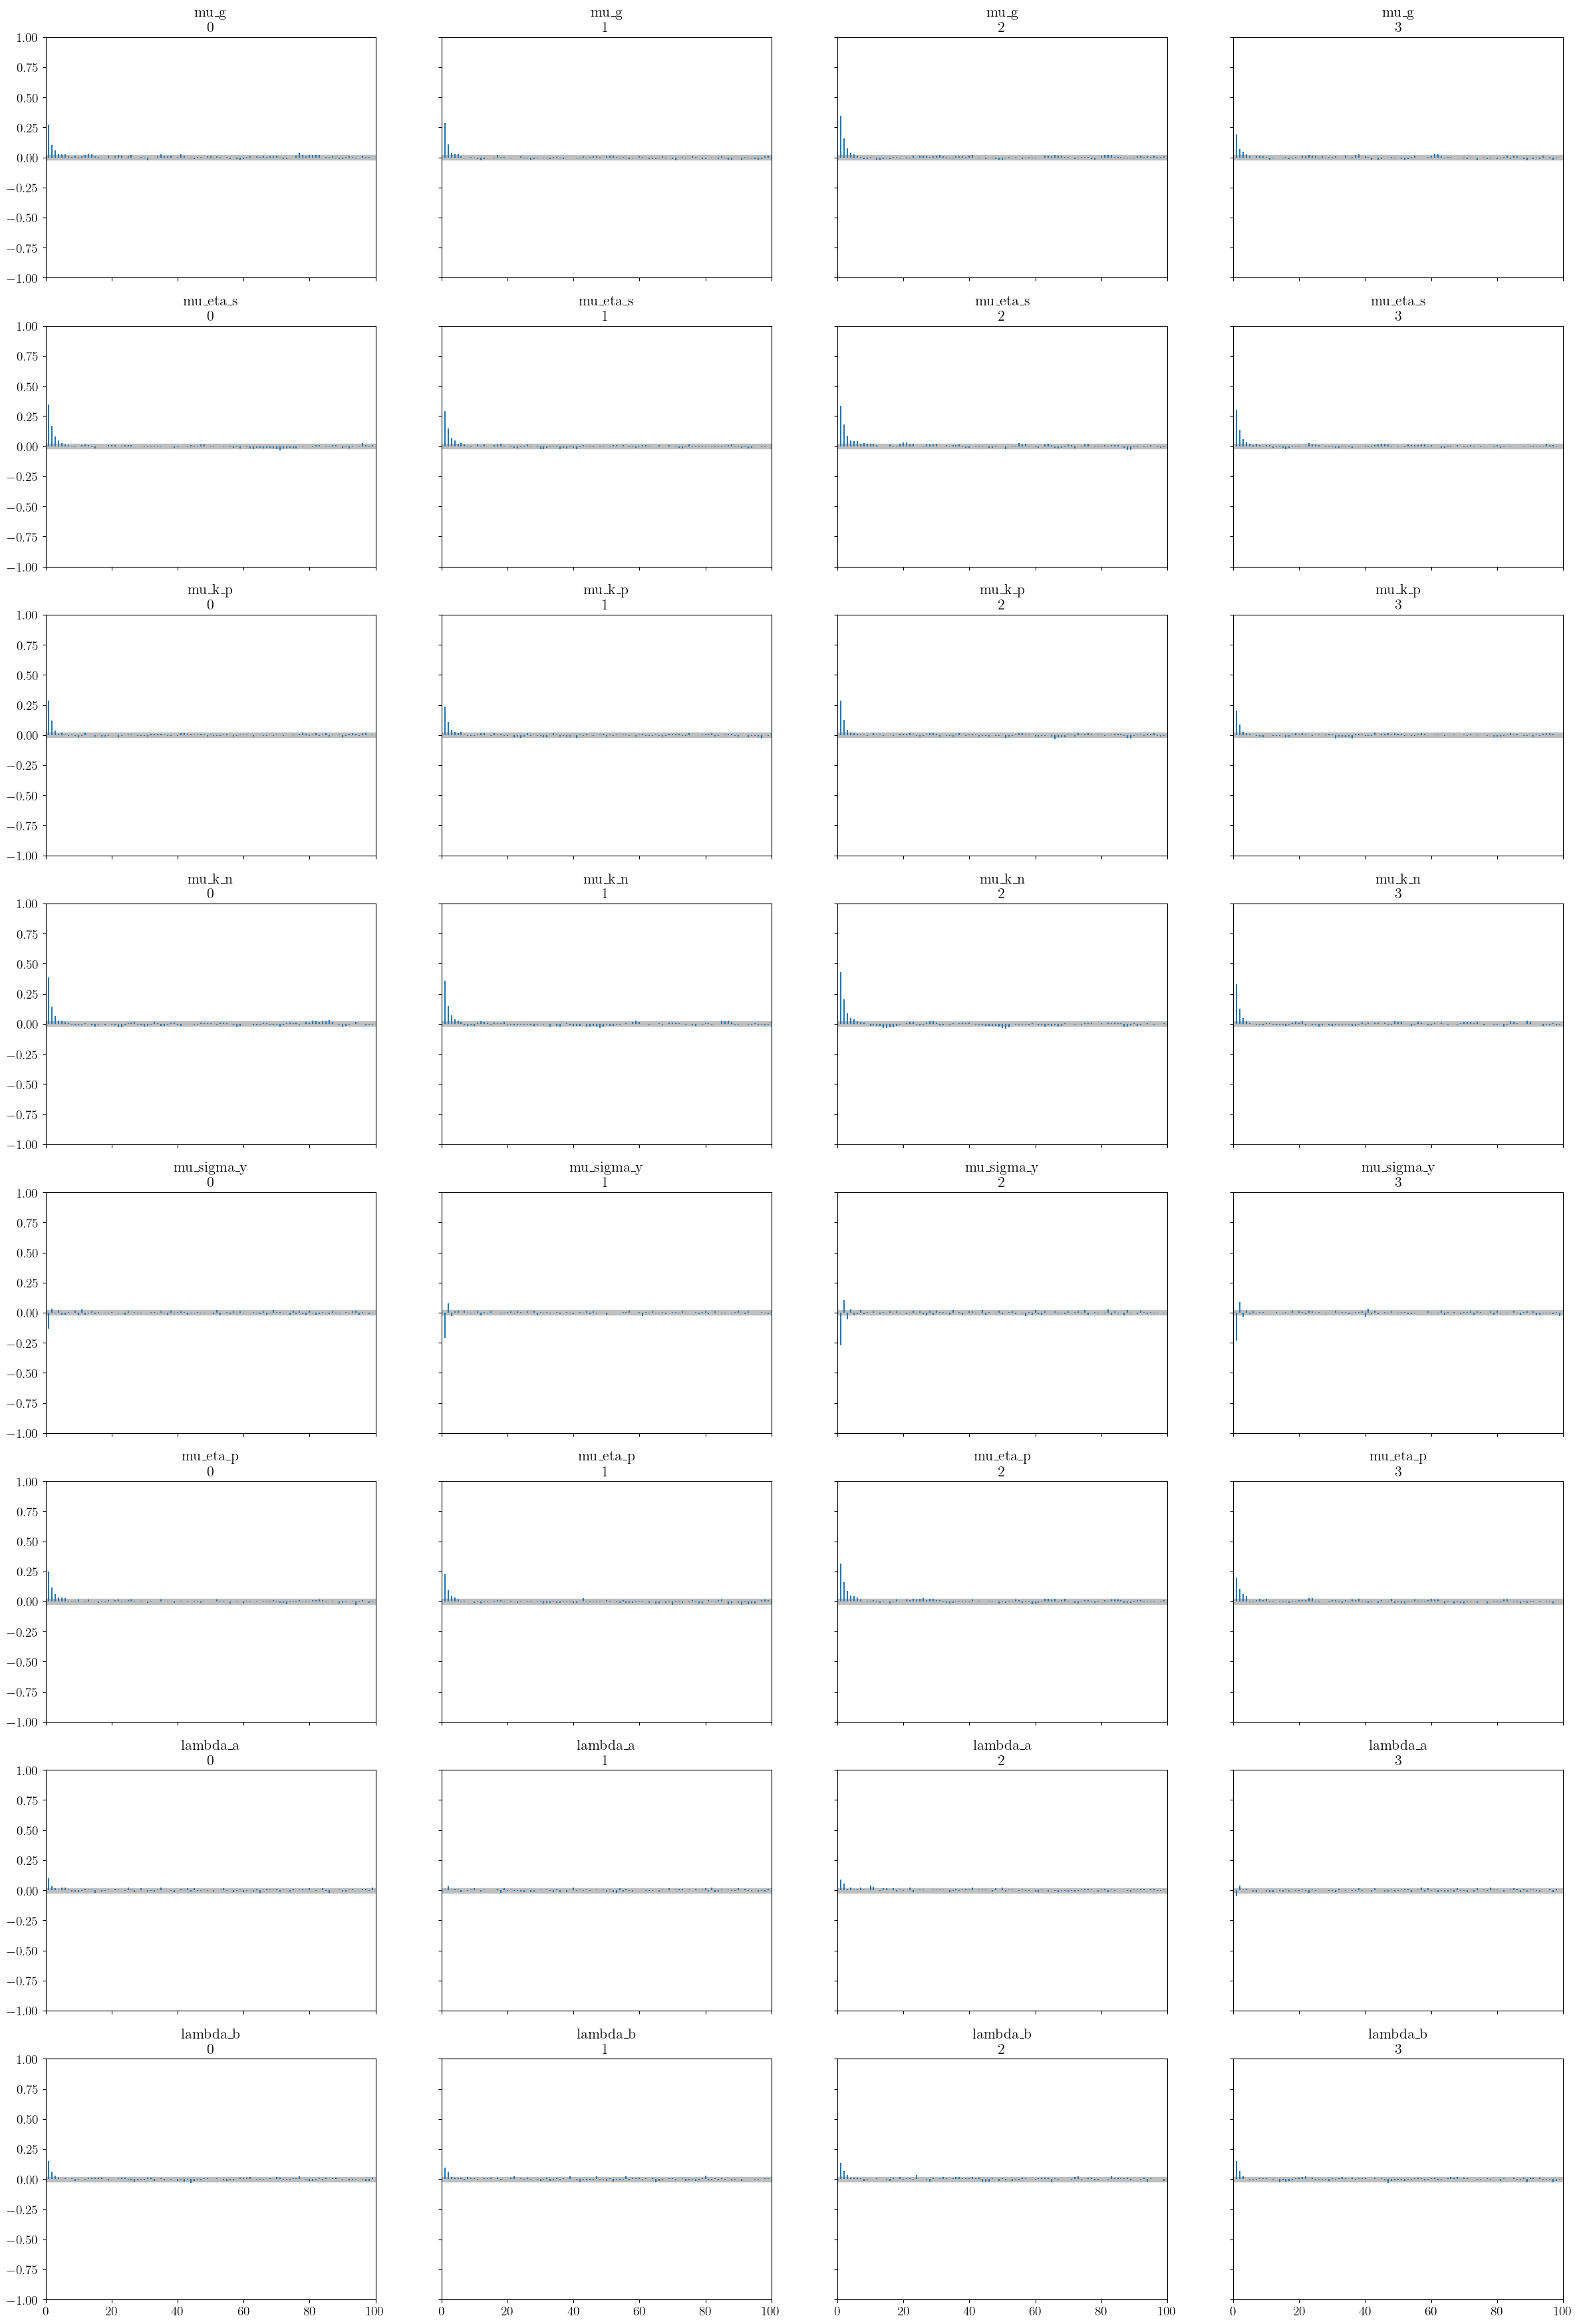

In [18]:
# Plotting autocorrelation plots #
az.plot_autocorr(idata_678,var_names=["mu_g", "mu_eta_s", "mu_k_p", "mu_k_n", "mu_sigma_y", "mu_eta_p", "lambda_a", "lambda_b"])

array([[<Axes: title={'center': 'sigma_g\n0'}>,
        <Axes: title={'center': 'sigma_g\n1'}>,
        <Axes: title={'center': 'sigma_g\n2'}>,
        <Axes: title={'center': 'sigma_g\n3'}>],
       [<Axes: title={'center': 'sigma_eta_s\n0'}>,
        <Axes: title={'center': 'sigma_eta_s\n1'}>,
        <Axes: title={'center': 'sigma_eta_s\n2'}>,
        <Axes: title={'center': 'sigma_eta_s\n3'}>],
       [<Axes: title={'center': 'sigma_k_p\n0'}>,
        <Axes: title={'center': 'sigma_k_p\n1'}>,
        <Axes: title={'center': 'sigma_k_p\n2'}>,
        <Axes: title={'center': 'sigma_k_p\n3'}>],
       [<Axes: title={'center': 'sigma_k_n\n0'}>,
        <Axes: title={'center': 'sigma_k_n\n1'}>,
        <Axes: title={'center': 'sigma_k_n\n2'}>,
        <Axes: title={'center': 'sigma_k_n\n3'}>],
       [<Axes: title={'center': 'sigma_sigma_y\n0'}>,
        <Axes: title={'center': 'sigma_sigma_y\n1'}>,
        <Axes: title={'center': 'sigma_sigma_y\n2'}>,
        <Axes: title={'center': 's

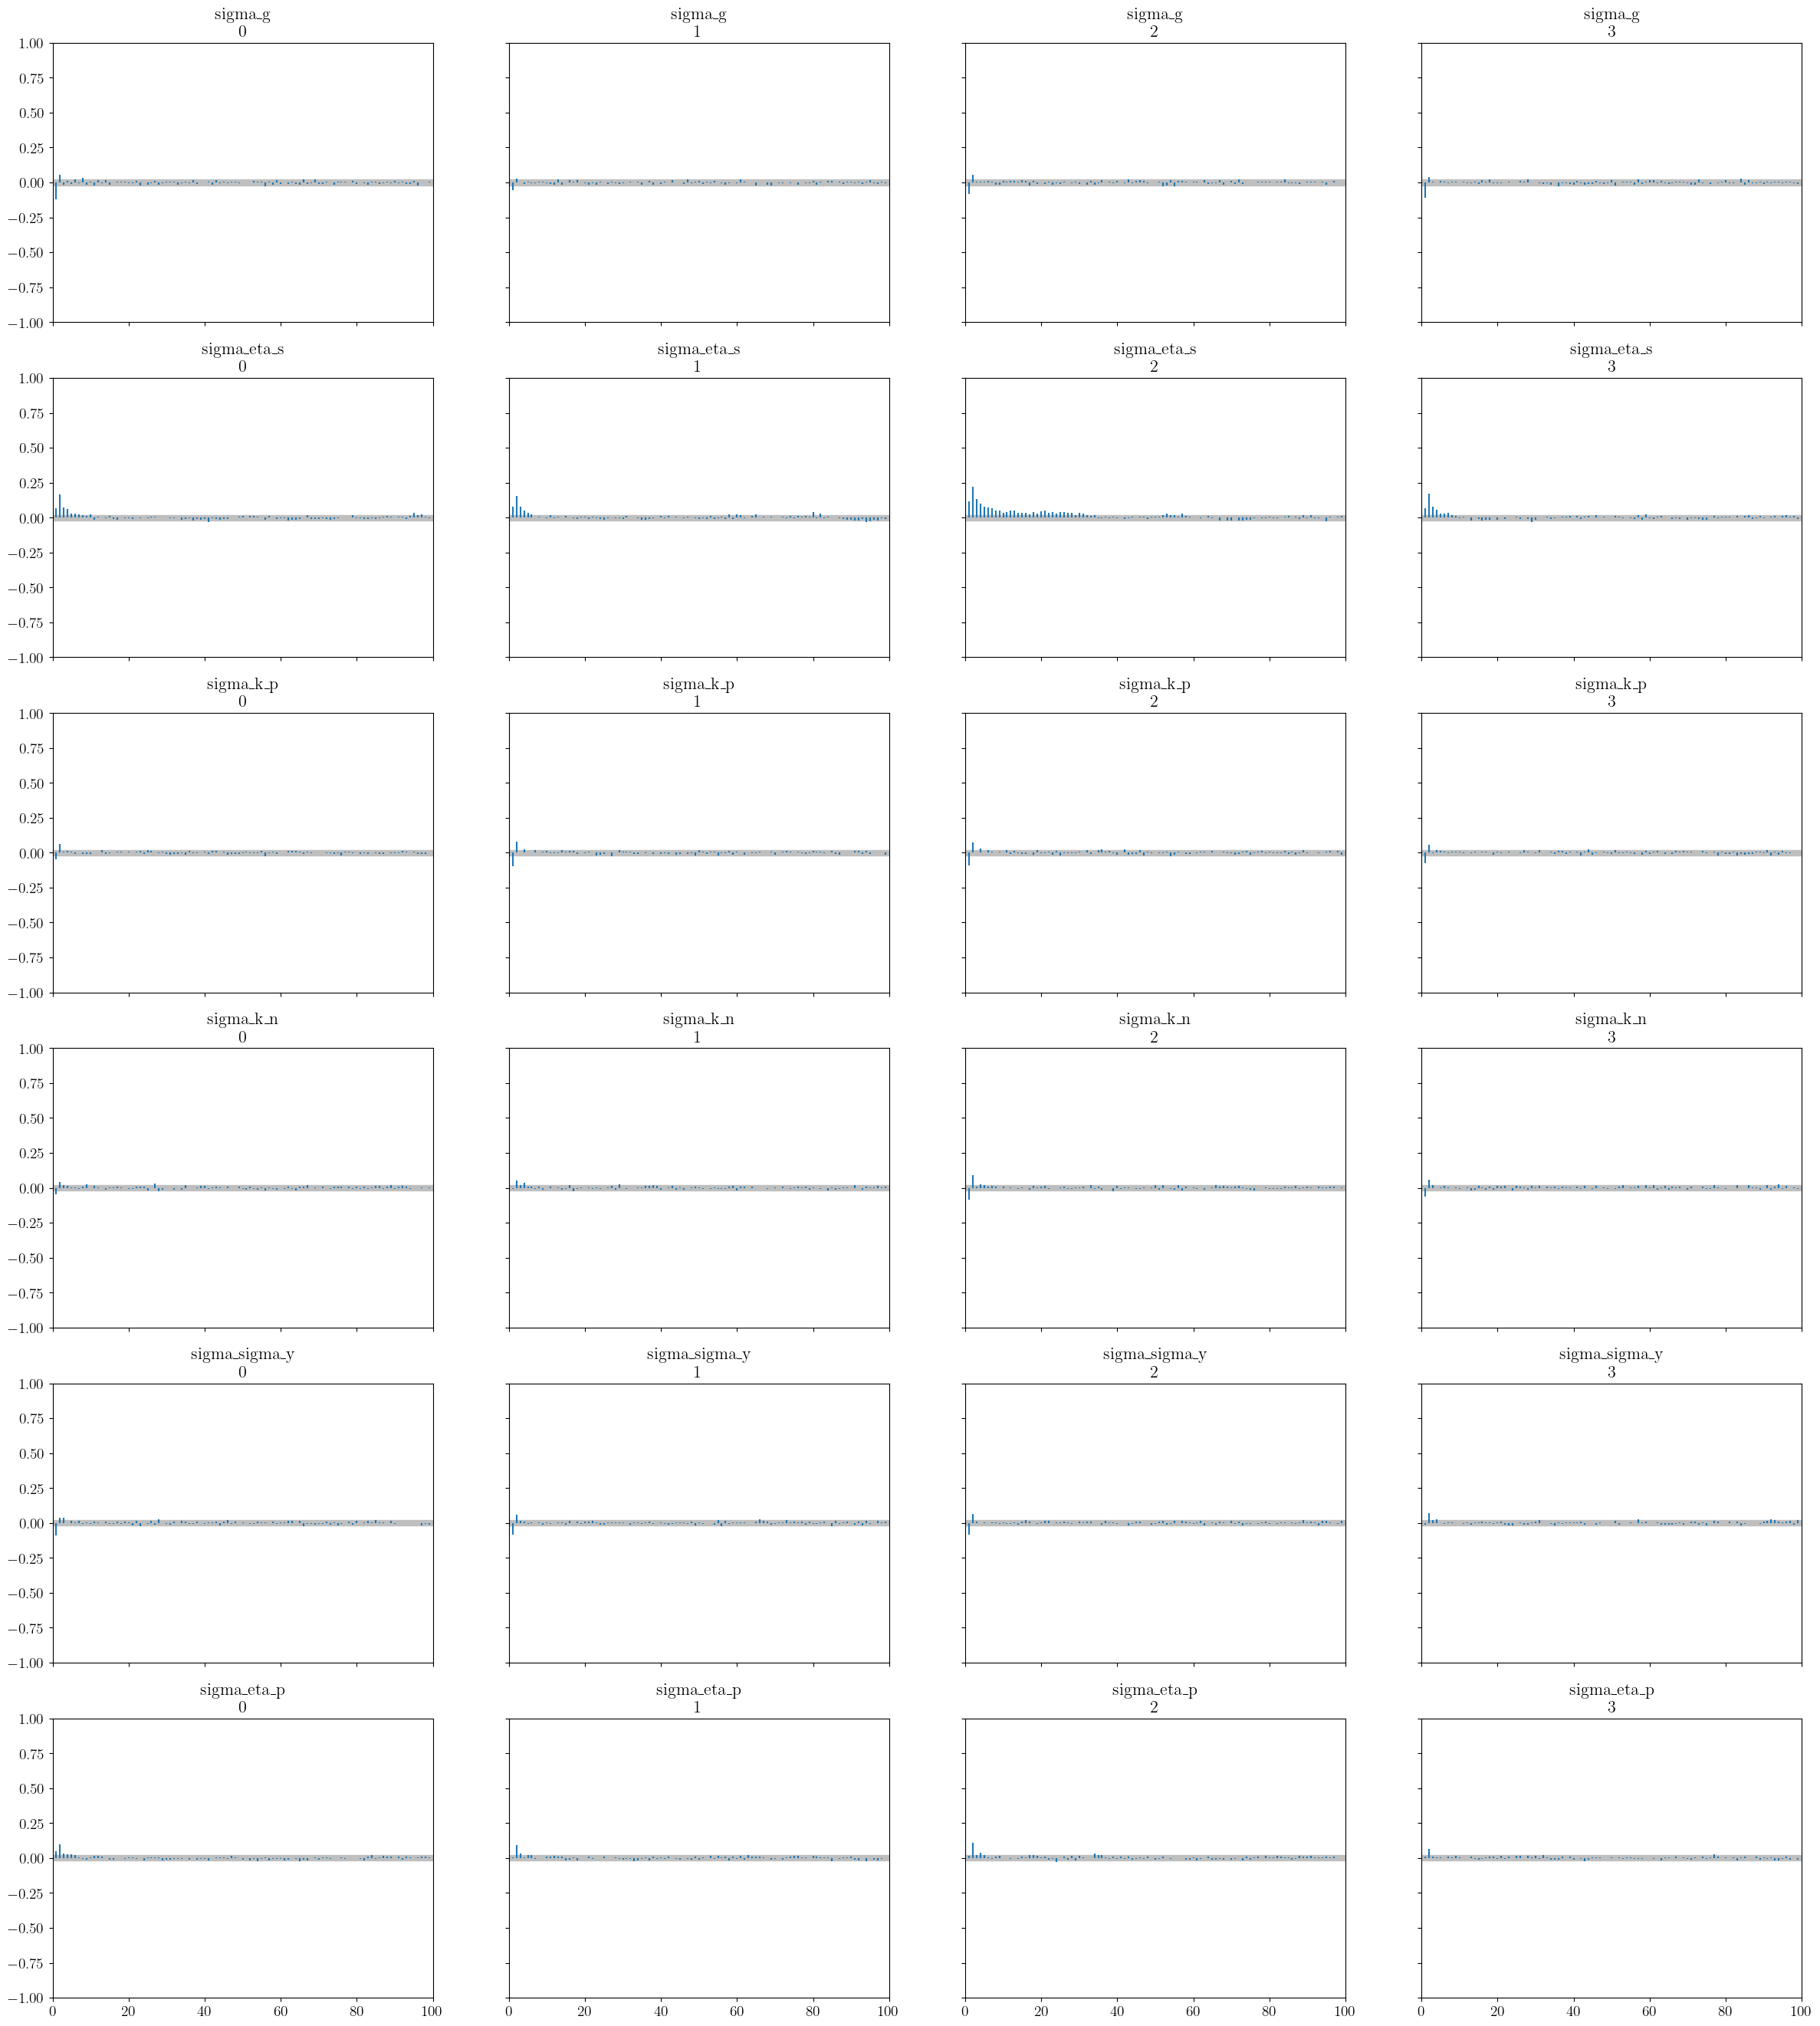

In [19]:
# Plotting autocorrelation plots #
az.plot_autocorr(idata_678,var_names=["sigma_g", "sigma_eta_s", "sigma_k_p", "sigma_k_n", "sigma_sigma_y", "sigma_eta_p"])

array([[<Axes: >, <Axes: >, <Axes: xlabel='lambda_b'>]], dtype=object)

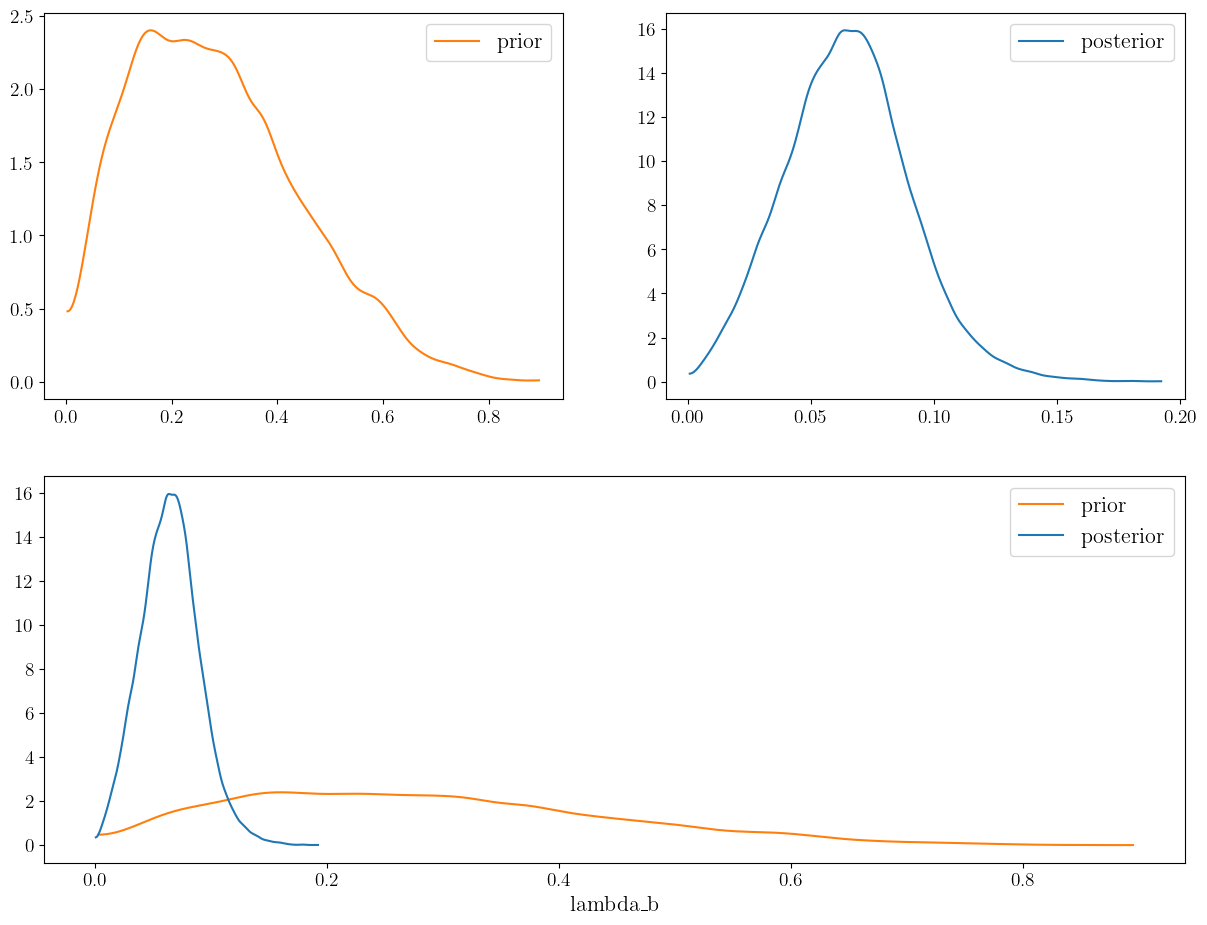

In [20]:
# Plot to compare prior and posterior distribution of variables. Give appropriate variable name #
az.plot_dist_comparison(idata_678,var_names=["lambda_b"])

In [21]:
# Summary of inference process #
az.summary(idata_678,var_names=["mu_g", "mu_eta_s", "mu_k_p", "mu_k_n", "mu_sigma_y", "mu_eta_p","sigma_g", "sigma_eta_s", "sigma_k_p", "sigma_k_n", "sigma_sigma_y", "sigma_eta_p", "lambda_a", "lambda_b"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
mu_g           0.561  0.125   0.337    0.800      0.001    0.001   19769.0   
mu_eta_s       0.655  0.080   0.502    0.797      0.001    0.000   16413.0   
mu_k_p         0.413  0.157   0.122    0.714      0.001    0.001   21266.0   
mu_k_n         0.322  0.046   0.234    0.408      0.000    0.000   17154.0   
mu_sigma_y     0.566  0.211   0.186    0.935      0.001    0.001   57044.0   
mu_eta_p       0.403  0.181   0.083    0.742      0.001    0.001   19330.0   
sigma_g        0.120  0.026   0.074    0.169      0.000    0.000   42332.0   
sigma_eta_s    0.036  0.024   0.000    0.078      0.000    0.000   15590.0   
sigma_k_p      0.029  0.024   0.000    0.072      0.000    0.000   26876.0   
sigma_k_n      0.066  0.023   0.026    0.110      0.000    0.000   33436.0   
sigma_sigma_y  0.045  0.033   0.000    0.104      0.000    0.000   30159.0   
sigma_eta_p    0.040  0.027   0.000    0.088      0.000    0.000   23110.0   
lambda_a       0.561  0.110   0.355    0.765      0.001    0.000   32471.0   
lambda_b       0.065  0.025   0.015    0.110      0.000    0.000   25899.0   

               ess_tail  r_hat  
mu_g            21328.0    1.0  
mu_eta_s        18301.0    1.0  
mu_k_p          22961.0    1.0  
mu_k_n          20716.0    1.0  
mu_sigma_y      27549.0    1.0  
mu_eta_p        23582.0    1.0  
sigma_g         28008.0    1.0  
sigma_eta_s     15271.0    1.0  
sigma_k_p       19983.0    1.0  
sigma_k_n       27509.0    1.0  
sigma_sigma_y   19782.0    1.0  
sigma_eta_p     16598.0    1.0  
lambda_a        25935.0    1.0  
lambda_b        21719.0    1.0

In [22]:
# Plotting data within imdata_posterior dataframe to understand data construction #
imdata_posterior = az.extract(idata_678, group = "posterior", num_samples=2).to_dataframe()
#print(imdata_posterior)
cols = ["G", "eta_s", "k_p", "k_n", "sigma_y", "eta_p", "lambda_a", "lambda_b", "lambda_ic"]
row = imdata_posterior.iloc[1, :][cols].values
print(row)

[0.46431209 0.78842118 0.23665932 0.37600543 0.41759041 0.15464888
 0.58433078 0.04211936 0.45384287]


(1500, 38)


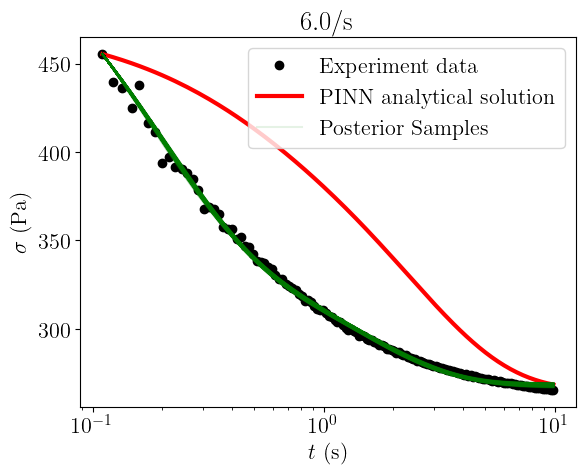

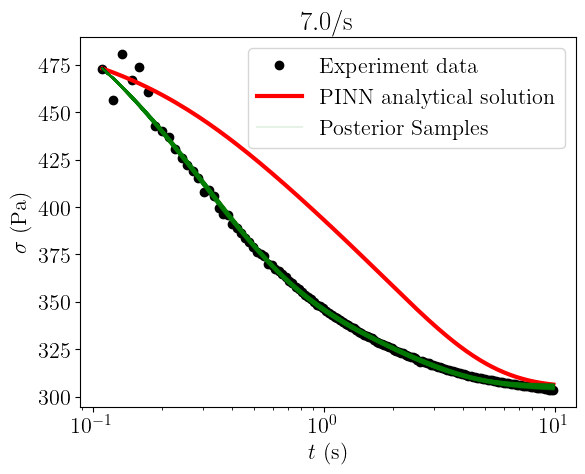

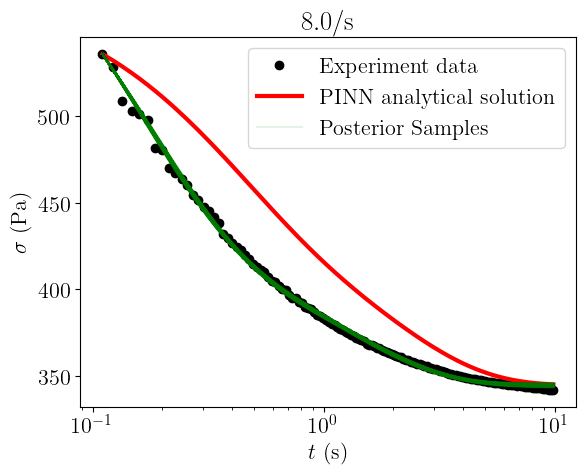

In [23]:
## Plotting predictions at shear rates used for training by sampling model parameters from posterior ##
## Note that second-level prior (NOT hyper-priors) are sampled and hence model parameters vary across shear rates used in training process ##

## In-sample (0.06/s and 0.08/s) predictions ##
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"

# num_samples/5 are sampled to avoid correlation #
num_samples = 500
imdata_posterior = az.extract(idata_678, group = "posterior", num_samples=num_samples).to_dataframe()
print(np.shape(imdata_posterior))
#print(imdata_df)
cols = ["G", "eta_s", "k_p", "k_n", "sigma_y", "eta_p", "lambda_ic"]
lambda_true = [0.8205,0.5875,0.4312,0.3273,0.259,0.216,0.1844,0.1585,0.1373]

# arg: 0 (2/s); 1 (3/s); 2 (4/s); 3 (5/s); 4 (6/s); 5 (7/s);
arg = 0
shear_rate_ode = shear_rate_all[arg]
y0 = y0_all[arg]
lambda_0 = lambda_true[arg]
# Using dimensional time and dimensional IC to get dimensional shear stress
# stress_ode = odeint(dy_dt,y0,t,args=(G_true,eta_s_true,sigma_y_true,k_true,n_true,shear_rate_ode))
stress_analytical_pinn = shear_stress_analytical((G_true-G_min)/(G_max-G_min),(eta_s_true-eta_s_min)/(eta_s_max-eta_s_min),\
                                                 (k_p_true-k_p_min)/(k_p_max-k_p_min),(k_n_true-k_n_min)/(k_n_max-k_n_min),\
                                                 (sigma_y_true-sigma_y_min)/(sigma_y_max-sigma_y_min),(eta_p_true-eta_p_min)/(eta_p_max-eta_p_min),\
                                                 shear_rate_ode,y0,lambda_0,times)
shear_stress_expt = shear_stress_global[:,arg+4]

plt.plot(times,shear_stress_expt,'ok', label='Experiment data')
plt.plot(times,stress_analytical_pinn,'-r', label='PINN analytical solution',linewidth=3)
for row_idx in range(0,num_samples):
  row = imdata_posterior.iloc[row_idx, :][cols].values
  theta = row
  # print(theta[6])
  # Using dimensional time as input to get dimensional shear_stress as output
  shear_stress_an = shear_stress_analytical(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],shear_rate_ode,y0,theta[6],times)#,shear_rate_1d,times_1d)
  #stress_odes = odeint(dy_dt,theta[5],t,args=(theta[0],theta[1],theta[2],theta[3],theta[4],shear_rate_ode))
  plt.plot(times,shear_stress_an,'-g',alpha=0.1)
plt.plot(np.NaN,np.NaN,'-g',alpha=0.1,label='Posterior Samples')

plt.title(r'$6.0$/s')
plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
plt.xscale('log')
plt.legend()
plt.show()


arg = 1
shear_rate_ode = shear_rate_all[arg]
y0 = y0_all[arg]
lambda_0 = lambda_true[arg]
# Using dimensional time and dimensional IC to get dimensional shear stress
# stress_ode = odeint(dy_dt,y0,t,args=(G_true,eta_s_true,sigma_y_true,k_true,n_true,shear_rate_ode))
stress_analytical_pinn = shear_stress_analytical((G_true-G_min)/(G_max-G_min),(eta_s_true-eta_s_min)/(eta_s_max-eta_s_min),\
                                                 (k_p_true-k_p_min)/(k_p_max-k_p_min),(k_n_true-k_n_min)/(k_n_max-k_n_min),\
                                                 (sigma_y_true-sigma_y_min)/(sigma_y_max-sigma_y_min),(eta_p_true-eta_p_min)/(eta_p_max-eta_p_min),\
                                                 shear_rate_ode,y0,lambda_0,times)
shear_stress_expt = shear_stress_global[:,arg+4]

plt.plot(times,shear_stress_expt,'ok', label='Experiment data')
plt.plot(times,stress_analytical_pinn,'-r', label='PINN analytical solution',linewidth=3)
for row_idx in range(num_samples,num_samples*2):
  row = imdata_posterior.iloc[row_idx, :][cols].values
  theta = row
  # Using dimensional time as input to get dimensional shear_stress as output
  shear_stress_an = shear_stress_analytical(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],shear_rate_ode,y0,theta[6],times)#,shear_rate_1d,times_1d)
  #stress_odes = odeint(dy_dt,theta[5],t,args=(theta[0],theta[1],theta[2],theta[3],theta[4],shear_rate_ode))
  plt.plot(times,shear_stress_an,'-g',alpha=0.1)
plt.plot(np.NaN,np.NaN,'-g',alpha=0.1,label='Posterior Samples')

plt.title(r'$7.0$/s')
plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
plt.xscale('log')
plt.legend()
plt.show()

arg = 2
shear_rate_ode = shear_rate_all[arg]
y0 = y0_all[arg]
lambda_0 = lambda_true[arg]
# Using dimensional time and dimensional IC to get dimensional shear stress
# stress_ode = odeint(dy_dt,y0,t,args=(G_true,eta_s_true,sigma_y_true,k_true,n_true,shear_rate_ode))
stress_analytical_pinn = shear_stress_analytical((G_true-G_min)/(G_max-G_min),(eta_s_true-eta_s_min)/(eta_s_max-eta_s_min),\
                                                 (k_p_true-k_p_min)/(k_p_max-k_p_min),(k_n_true-k_n_min)/(k_n_max-k_n_min),\
                                                 (sigma_y_true-sigma_y_min)/(sigma_y_max-sigma_y_min),(eta_p_true-eta_p_min)/(eta_p_max-eta_p_min),\
                                                 shear_rate_ode,y0,lambda_0,times)
shear_stress_expt = shear_stress_global[:,arg+4]

plt.plot(times,shear_stress_expt,'ok', label='Experiment data')
plt.plot(times,stress_analytical_pinn,'-r', label='PINN analytical solution',linewidth=3)
for row_idx in range(num_samples*2,num_samples*3):
  row = imdata_posterior.iloc[row_idx, :][cols].values
  theta = row
  # Using dimensional time as input to get dimensional shear_stress as output
  shear_stress_an = shear_stress_analytical(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],shear_rate_ode,y0,theta[6],times)#,shear_rate_1d,times_1d)
  #stress_odes = odeint(dy_dt,theta[5],t,args=(theta[0],theta[1],theta[2],theta[3],theta[4],shear_rate_ode))
  plt.plot(times,shear_stress_an,'-g',alpha=0.1)
plt.plot(np.NaN,np.NaN,'-g',alpha=0.1,label='Posterior Samples')

plt.title(r'$8.0$/s')
plt.xlabel(r'$t$ (s)',fontsize=16)
plt.ylabel(r'$\sigma$ (Pa)',fontsize=16)
plt.xscale('log')
plt.legend()
plt.show()


In [24]:
## Plotting predictions at all shear rates by sampling model parameters from posterior ##
## Note that first-level priors (or hyper-priors) are sampled and hence model parameters are shear-rate invariant ##
## Using hierarchical sampling based on sum and product rule ##

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm" 

num_samples = 1000 #1000 # Hyper-prior samples 1000
thin_every = 40 #100
itr_samples = num_samples*thin_every
no_samples = itr_samples*len(shear_rate_train) # New normal model samples 1000
act_samples = no_samples/thin_every
act_samples = int(act_samples)
print(act_samples)
model_params_all = np.zeros((num_samples*act_samples,11)) 
noise_params = np.zeros((num_samples*act_samples,1)) 

# extracting normalized model parameters from posterior distribution #
imdata_pred_678 = az.extract(idata_678, group = "posterior", num_samples=itr_samples).to_dataframe() #itr_samples
print(np.shape(imdata_pred_678))
# Hyperpriors are same across all shear rates #
mean_cols = ["mu_g", "mu_eta_s", "mu_k_p", "mu_k_n", "mu_sigma_y", "mu_eta_p"]
sigma_cols = ["sigma_g", "sigma_eta_s", "sigma_k_p", "sigma_k_n", "sigma_sigma_y", "sigma_eta_p"]
std_cols = ["z_G", "z_eta_s", "z_k_p", "z_k_n", "z_sigma_y", "z_eta_p"]
lambda_cols = ["lambda_a","lambda_b"]
noise_cols = ["sigma"]

count = -1
for row_idx_1 in range(0,itr_samples,thin_every): 
    count = count + 1
    mean_row = imdata_pred_678.iloc[row_idx_1, :][mean_cols].values
    sigma_row = imdata_pred_678.iloc[row_idx_1, :][sigma_cols].values
    lambda_row = imdata_pred_678.iloc[row_idx_1, :][lambda_cols].values
    noise_row = imdata_pred_678.iloc[row_idx_1, :][noise_cols].values
    noise_dist = st.norm(0,noise_row)

    count_1 = -1
    for row_idx_2 in range(0,no_samples,thin_every):
        count_1 = count_1 + 1
        z_row = imdata_pred_678.iloc[row_idx_2, :][std_cols].values
        
        G_predicted = mean_row[0]+sigma_row[0]*z_row[0]
        eta_s_predicted = mean_row[1]+sigma_row[1]*z_row[1]
        k_p_predicted = mean_row[2]+sigma_row[2]*z_row[2]
        k_n_predicted = mean_row[3]+sigma_row[3]*z_row[3]
        sigma_y_predicted = mean_row[4]+sigma_row[4]*z_row[4]
        eta_p_predicted = mean_row[5]+sigma_row[5]*z_row[5]
        
        lambda_ic_6 = lambda_row[0]*np.exp(-lambda_row[1]*(6))
        lambda_ic_7 = lambda_row[0]*np.exp(-lambda_row[1]*(7))
        lambda_ic_8 = lambda_row[0]*np.exp(-lambda_row[1]*(8))
        lambda_ic_9 = lambda_row[0]*np.exp(-lambda_row[1]*(9))
        lambda_ic_10 = lambda_row[0]*np.exp(-lambda_row[1]*(10))
        # TEVP model parameters #
        model_params_all[count_1+(count)*act_samples,0] = G_predicted
        model_params_all[count_1+(count)*act_samples,1] = eta_s_predicted
        model_params_all[count_1+(count)*act_samples,2] = k_p_predicted
        model_params_all[count_1+(count)*act_samples,3] = k_n_predicted
        model_params_all[count_1+(count)*act_samples,4] = sigma_y_predicted
        model_params_all[count_1+(count)*act_samples,5] = eta_p_predicted
        # Structure parameter #
        model_params_all[count_1+(count)*act_samples,6] = lambda_ic_6
        model_params_all[count_1+(count)*act_samples,7] = lambda_ic_7
        model_params_all[count_1+(count)*act_samples,8] = lambda_ic_8
        model_params_all[count_1+(count)*act_samples,9] = lambda_ic_9
        model_params_all[count_1+(count)*act_samples,10] = lambda_ic_10

        noise_params[count_1+(count)*act_samples,0] = noise_dist.rvs(size=1)
       
print(np.shape(model_params_all))
print(np.shape(noise_params))


3000
(120000, 38)
(3000000, 11)
(3000000, 1)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


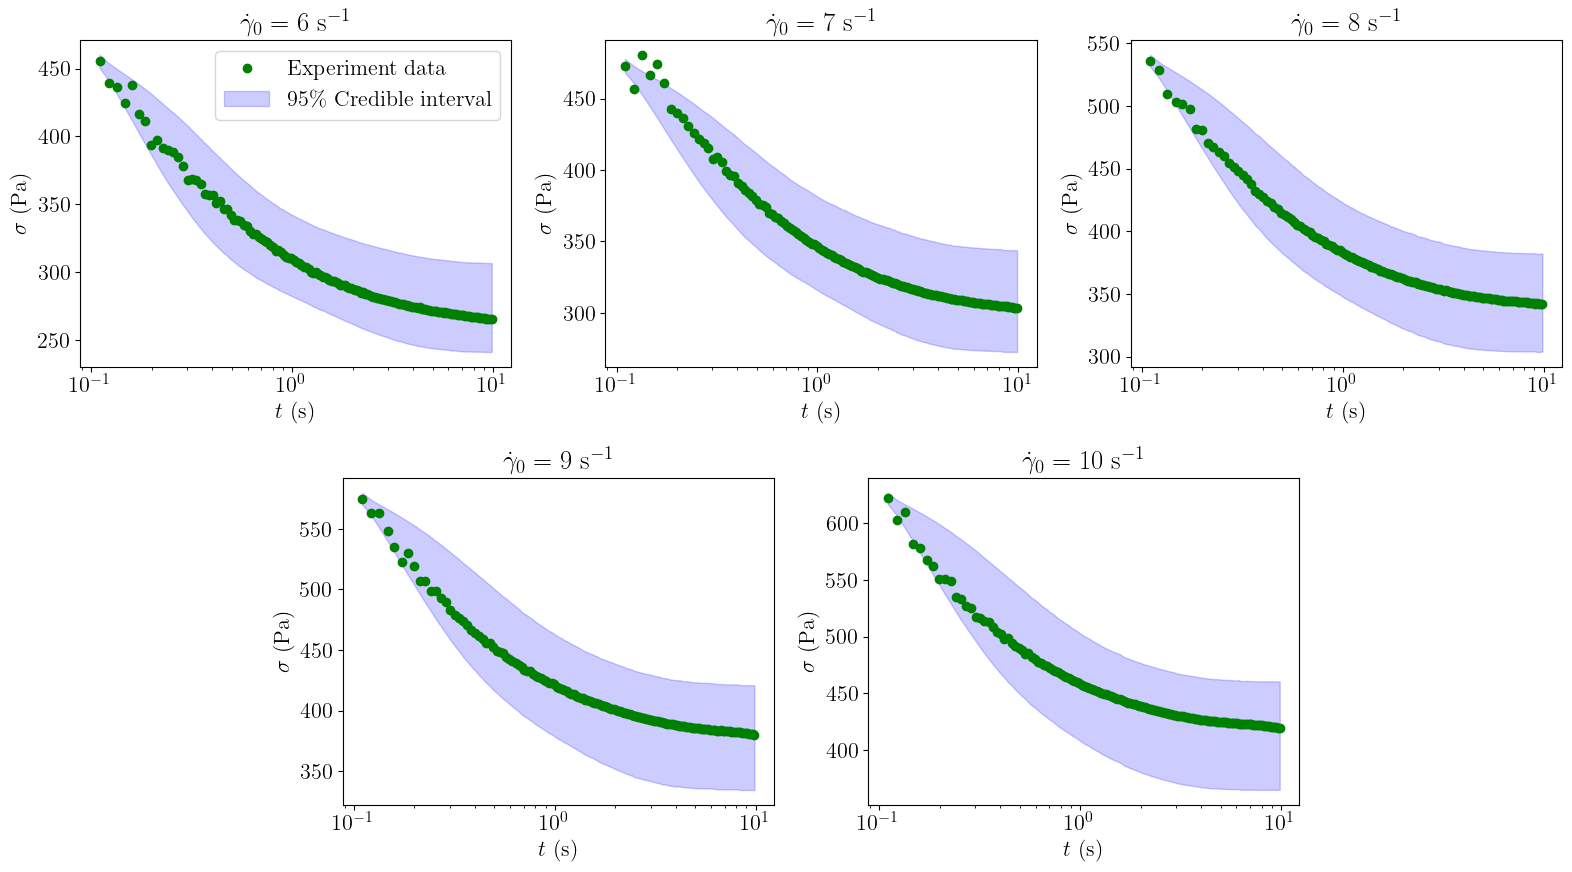

In [25]:
# Propogating uncertainty of model parameters into shear stress relaxation profiles #
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm" 

import matplotlib as mpl
ic_count = 5
fig = plt.figure(figsize=(16,9))
spec = mpl.gridspec.GridSpec(ncols=6,nrows=2)
ax1 = fig.add_subplot(spec[0,0:2])
ax2 = fig.add_subplot(spec[0,2:4])
ax3 = fig.add_subplot(spec[0,4:])
ax4 = fig.add_subplot(spec[1,1:3])
ax5 = fig.add_subplot(spec[1,3:5])

for arg in range(0,5): 
    ic_count = ic_count + 1
    shear_stress_all_prediction = np.zeros((num_samples*act_samples,148))
    shear_rate_ode = shear_rate_all[arg]
    y0 = y0_all[arg]
    lambda_0 = lambda_true[arg]

    stress_analytical_pinn = shear_stress_analytical((G_true-G_min)/(G_max-G_min),(eta_s_true-eta_s_min)/(eta_s_max-eta_s_min),\
                                                 (k_p_true-k_p_min)/(k_p_max-k_p_min),(k_n_true-k_n_min)/(k_n_max-k_n_min),\
                                                 (sigma_y_true-sigma_y_min)/(sigma_y_max-sigma_y_min),(eta_p_true-eta_p_min)/(eta_p_max-eta_p_min),\
                                                 shear_rate_ode,y0,lambda_0,times)
    shear_stress_expt = shear_stress_global[:,arg+4]
    
    if arg==0:
        ax = ax1
        #plt.subplot(2,3,1)
    elif arg==1:
        ax = ax2
        #plt.subplot(2,3,2)
    elif arg==2:
        ax = ax3
        #plt.subplot(2,3,3)
    elif arg==3:
        ax = ax4
        #plt.subplot(2,3,4)
    elif arg==4:
        ax = ax5
        #plt.subplot(2,3,5)
             
    ax.plot(times,shear_stress_expt,'og', label='Experiment data')
    
    for row_idx_1 in range(0,num_samples): 
        for row_idx_2 in range(0,act_samples):
            theta = model_params_all[row_idx_2+row_idx_1*act_samples,:]
            shear_stress_an = shear_stress_analytical(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],shear_rate_ode,y0,theta[ic_count],times)
            shear_stress_all_prediction[row_idx_2+row_idx_1*act_samples,:] = shear_stress_an + noise_params[row_idx_2+row_idx_1*act_samples,0] 
           
    stress_low = np.zeros(np.size(times))
    stress_high = np.zeros(np.size(times))
    # stress_mean = np.zeros(np.size(times))
   
    for itr in range(0,np.size(times)):
        stress_low[itr] = az.hdi(shear_stress_all_prediction[:,itr],0.95)[0]
        stress_high[itr] = az.hdi(shear_stress_all_prediction[:,itr],0.95)[1]
    ax.fill_between(times,stress_low,stress_high,color='b',alpha=0.2,label='95\% Credible interval')
    ax.set_title(r'$\dot\gamma_0 = %d~\rm{s^{-1}}$' % (arg+6))
    ax.set_xlabel(r'$t$ (s)')
    ax.set_ylabel(r'$\sigma$ (Pa)')
    ax.set_xscale('log')
    if arg==0:
        ax.legend()
   
plt.tight_layout()
plt.savefig('TEVP_shear_stress_subplots_678.eps',format='eps',bbox_inches='tight')
plt.savefig(r'TEVP_shear_stress_subplots_678.pdf',format='pdf',bbox_inches='tight')
plt.savefig('png-TEVP_shear_stress_subplots_678.png',format='png',bbox_inches='tight')
plt.show()



153.7367016359008
592.9163038676711
28.896420041909245
42.81035680224666
0.036036084693539534
0.18655163025784094
0.04215643279892714
0.13232450708175253
24.701112360509224
143.31015422184132
13.714696824362473
59.43764735895329


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


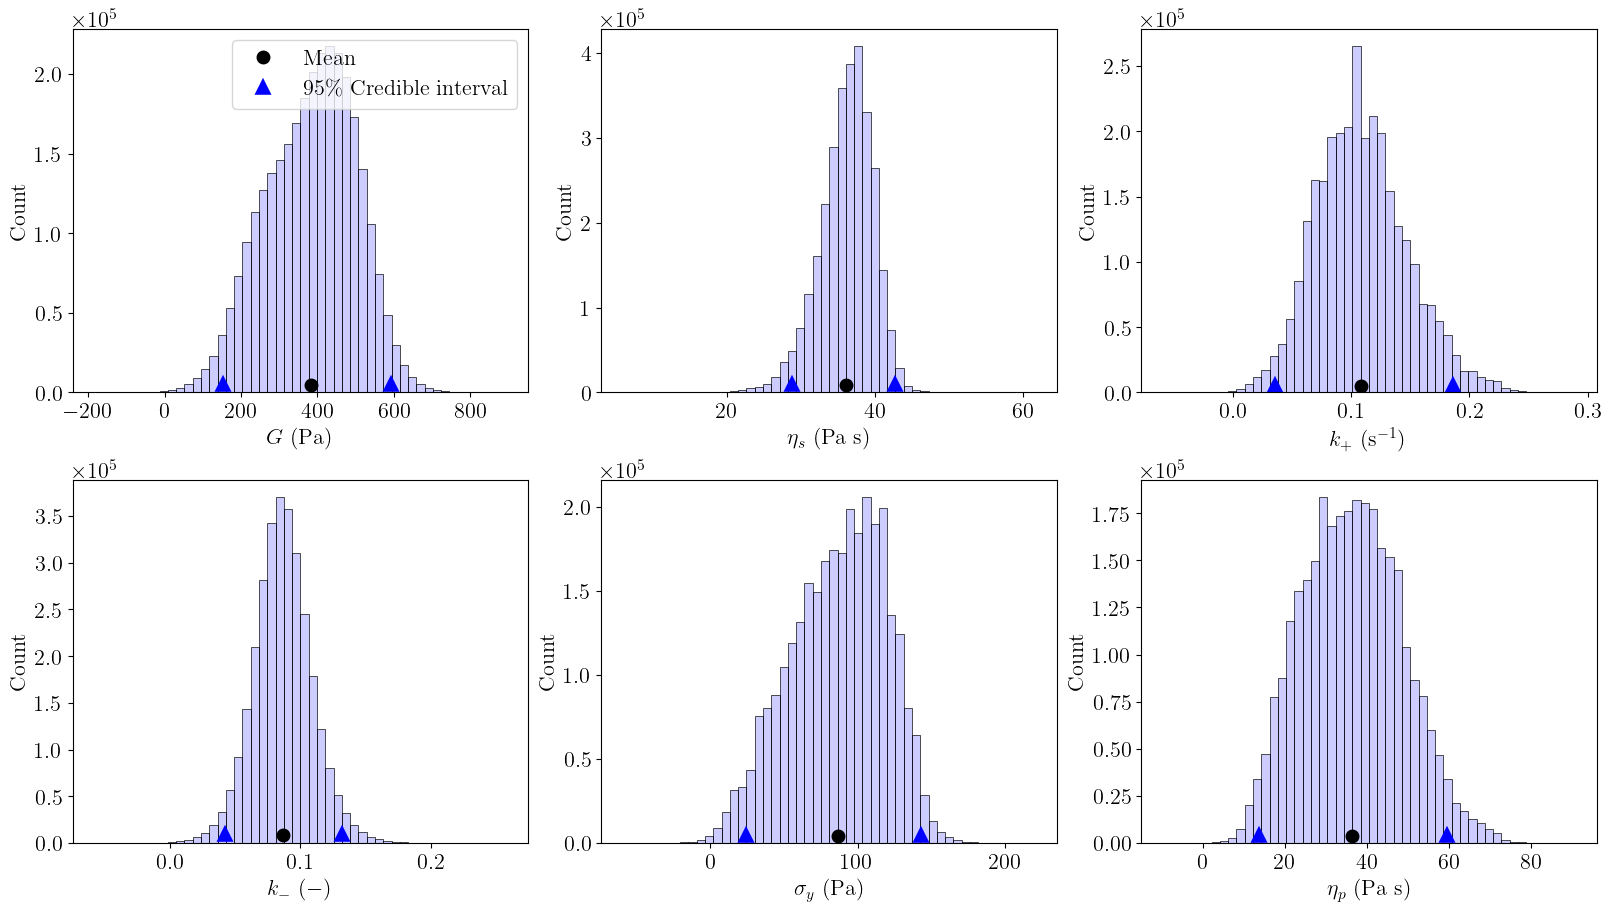

In [26]:
## Plotting uncertainty of calibrated model parameters ##

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
sns.set_style(None)


G_low = az.hdi(model_params_all[:,0],0.95)[0]*(G_max-G_min) + G_min
print(G_low)
G_high = az.hdi(model_params_all[:,0],0.95)[1]*(G_max-G_min) + G_min
print(G_high)

eta_s_low = az.hdi(model_params_all[:,1],0.95)[0]*(eta_s_max-eta_s_min) + eta_s_min
print(eta_s_low)
eta_s_high = az.hdi(model_params_all[:,1],0.95)[1]*(eta_s_max-eta_s_min) + eta_s_min
print(eta_s_high)

k_p_low = az.hdi(model_params_all[:,2],0.95)[0]*(k_p_max-k_p_min) + k_p_min
print(k_p_low)
k_p_high = az.hdi(model_params_all[:,2],0.95)[1]*(k_p_max-k_p_min) + k_p_min
print(k_p_high)

k_n_low = az.hdi(model_params_all[:,3],0.95)[0]*(k_n_max-k_n_min) + k_n_min
print(k_n_low)
k_n_high = az.hdi(model_params_all[:,3],0.95)[1]*(k_n_max-k_n_min) + k_n_min
print(k_n_high)

sigma_y_low = az.hdi(model_params_all[:,4],0.95)[0]*(sigma_y_max-sigma_y_min) + sigma_y_min 
print(sigma_y_low)
sigma_y_high = az.hdi(model_params_all[:,4],0.95)[1]*(sigma_y_max-sigma_y_min) + sigma_y_min
print(sigma_y_high)

eta_p_low = az.hdi(model_params_all[:,5],0.95)[0]*(eta_p_max-eta_p_min) + eta_p_min
print(eta_p_low)
eta_p_high = az.hdi(model_params_all[:,5],0.95)[1]*(eta_p_max-eta_p_min) + eta_p_min
print(eta_p_high)

plt.subplots(2,3,figsize=(16,9),constrained_layout=True)
plt.subplot(2,3,1)
ax=plt.gca()
ax.plot([np.mean(model_params_all[:,0]*(G_max-G_min)+G_min,axis=0)],[5000.0],'o',color='k',markeredgewidth=4,label='Mean')
ax.plot([G_low, G_high],[5000.0, 5000.0],'^',color='b',markeredgewidth=4, label='95\% Credible interval')
#ax.plot([np.mean(model_params_all[:,0])*(G_max-G_min)+G_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all[:,0]*(G_max-G_min) + G_min,fill=True,color='b',bins=50,alpha=0.2,ax=ax)
plt.xlabel(r"$G~\rm{(Pa)}$")
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.legend()

plt.subplot(2,3,2)
ax = plt.gca()
ax.plot([np.mean(model_params_all[:,1]*(eta_s_max-eta_s_min)+eta_s_min,axis=0)],[9000.0],'o',color='k',markeredgewidth=4,label='Mean')
ax.plot([eta_s_low, eta_s_high],[9000.0, 9000.0],'^',color='b',markeredgewidth=4)
#ax.plot([np.mean(model_params_all[:,1])*(eta_s_max-eta_s_min)+eta_s_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all[:,1]*(eta_s_max-eta_s_min) + eta_s_min,fill=True,color='b',bins=50,alpha=0.2,ax=ax)
plt.xlabel(r"$\eta_s~\rm{(Pa~s)}$")
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.subplot(2,3,3)
ax = plt.gca()
ax.plot([np.mean(model_params_all[:,2]*(k_p_max-k_p_min)+k_p_min,axis=0)],[5000.0],'o',color='k',markeredgewidth=4,label='Mean')
ax.plot([k_p_low, k_p_high],[5000.0, 5000.0],'^',color='b',markeredgewidth=4)
#ax.plot([np.mean(model_params_all[:,2])*(k_p_max-k_p_min)+k_p_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all[:,2]*(k_p_max-k_p_min) + k_p_min,fill=True,color='b',bins=50,alpha=0.2,ax=ax)
plt.xlabel(r"$k_{+}~\rm{(s^{-1})}$")
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.subplot(2,3,4)
ax = plt.gca()
ax.plot([np.mean(model_params_all[:,3]*(k_n_max-k_n_min)+k_n_min,axis=0)],[9000.0],'o',color='k',markeredgewidth=4,label='Mean')
ax.plot([k_n_low, k_n_high],[9000.0, 9000.0],'^',color='b',markeredgewidth=4)
#ax.plot([np.mean(model_params_all[:,3])*(k_n_max-k_n_min)+k_n_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all[:,3]*(k_n_max-k_n_min) + k_n_min,fill=True,color='b',bins=50,alpha=0.2,ax=ax)
plt.xlabel(r"$k_{-}~\rm{(-)}$")
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.subplot(2,3,5)
ax = plt.gca()
ax.plot([np.mean(model_params_all[:,4]*(sigma_y_max-sigma_y_min)+sigma_y_min,axis=0)],[4000.0],'o',color='k',markeredgewidth=4,label='Mean')
ax.plot([sigma_y_low, sigma_y_high],[4000.0, 4000.0],'^',color='b',markeredgewidth=4)
#ax.plot([np.mean(model_params_all[:,4])*(sigma_y_max-sigma_y_min)+sigma_y_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all[:,4]*(sigma_y_max-sigma_y_min) + sigma_y_min,fill=True,color='b',bins=50,alpha=0.2,ax=ax)
plt.xlabel(r"$\sigma_y~\rm{(Pa)}$")
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.subplot(2,3,6)
ax = plt.gca()
ax.plot([np.mean(model_params_all[:,5]*(eta_p_max-eta_p_min)+eta_p_min,axis=0)],[4000.0],'o',color='k',markeredgewidth=4,label='Mean')
ax.plot([eta_p_low, eta_p_high],[4000.0, 4000.0],'^',color='b',markeredgewidth=4)
#ax.plot([np.mean(model_params_all[:,5])*(eta_p_max-eta_p_min)+eta_p_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all[:,5]*(eta_p_max-eta_p_min) + eta_p_min,fill=True,color='b',bins=50,alpha=0.2,ax=ax)
plt.xlabel(r"$\eta_p~\rm{(Pa~s)}$")
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.savefig('TEVP_model_params_subplots_678.eps',format='eps',bbox_inches='tight')
plt.savefig(r'TEVP_model_params_subplots_678.pdf',format='pdf',bbox_inches='tight')
plt.savefig('png-TEVP_model_params_subplots_678.png',format='png',bbox_inches='tight')
plt.show()

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


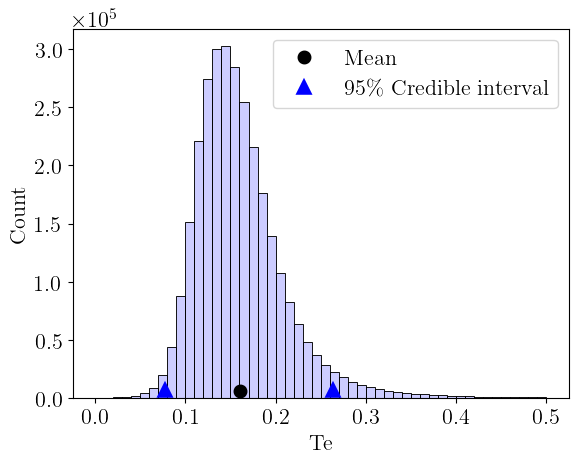

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


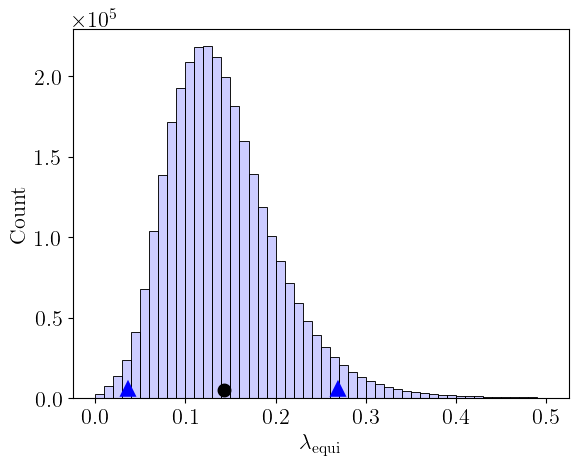

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


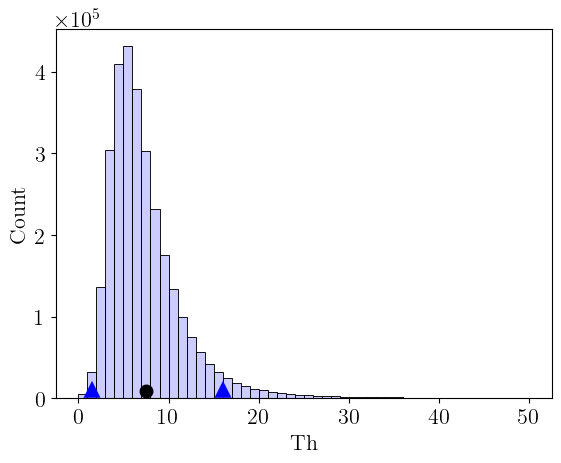

In [27]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
sns.set_style(None)

Te_num = np.zeros((num_samples*act_samples,1))
Te_den = np.zeros((num_samples*act_samples,1))
Te_num = ((model_params_all[:,2]*(k_p_max-k_p_min)+k_p_min) + (model_params_all[:,3]*(k_n_max-k_n_min)+k_n_min)*8) #/ \
Te_den = ((model_params_all[:,0]*(G_max-G_min)+G_min)/((model_params_all[:,1]*(eta_s_max-eta_s_min)+eta_s_min) + (model_params_all[:,5]*(eta_p_max-eta_p_min)+eta_p_min)))

Te = Te_num/Te_den

#plt.subplots(1,2,figsize=(10,5),constrained_layout=True)
#plt.subplot(1,2,1)
Te = Te[Te>0]
Te = Te[Te<0.5]
#Te_sub = Te[0:20000]
#plt.subplot(1,3,3)
Te_low = az.hdi(Te,0.95)[0]
Te_high = az.hdi(Te,0.95)[1]
sns.histplot(Te,fill=True,color='b',bins=50,alpha=0.2)
plt.plot([np.mean(Te)],[6500.0],'o',color='k',markeredgewidth=4,label='Mean')
plt.plot([Te_low, Te_high],[6500.0, 6500.0],'^',color='b',markeredgewidth=4,label='95\% Credible interval')
plt.xlabel(r"$\mathrm{Te}$")
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.legend()
plt.savefig('Thixotropy_Te_numbers.eps',format='eps',bbox_inches='tight')
plt.savefig(r'Thixotropy_Te_numbers.pdf',format='pdf',bbox_inches='tight')
plt.show()

#plt.subplot(1,2,2)
le = np.zeros((num_samples*act_samples,1))
le = np.divide((model_params_all[:,2]*(k_p_max-k_p_min)+k_p_min),((model_params_all[:,2]*(k_p_max-k_p_min)+k_p_min) + (model_params_all[:,3]*(k_n_max-k_n_min)+k_n_min)*8)) 
le = le[le>0]
le = le[le<0.5]
le_low = az.hdi(le,0.95)[0]
le_high = az.hdi(le,0.95)[1]
sns.histplot(le,fill=True,color='b',bins=50,alpha=0.2)
plt.plot([np.mean(le)],[5000.0],'o',color='k',markeredgewidth=4,label='Mean')
plt.plot([le_low, le_high],[5000.0, 5000.0],'^',color='b',markeredgewidth=4,label='95\% Credible interval')
plt.xlabel(r"$\lambda_\mathrm{equi}$")
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.savefig('Thixotropy_le_numbers.eps',format='eps',bbox_inches='tight')
plt.savefig(r'Thixotropy_le_numbers.pdf',format='pdf',bbox_inches='tight')
plt.show()

Th = np.zeros((num_samples*act_samples,1))
Th = np.divide(((model_params_all[:,3]*(k_n_max-k_n_min)+k_n_min)*8),(model_params_all[:,2]*(k_p_max-k_p_min)+k_p_min)) 
Th = Th[Th>0]
Th = Th[Th<50.0]
Th_low = az.hdi(Th,0.95)[0]
Th_high = az.hdi(Th,0.95)[1]
sns.histplot(Th,fill=True,color='b',bins=50,alpha=0.2)
plt.plot([np.mean(Th)],[8500.0],'o',color='k',markeredgewidth=4,label='Mean')
plt.plot([Th_low, Th_high],[8500.0, 8500.0],'^',color='b',markeredgewidth=4,label='95\% Credible interval')
plt.xlabel(r"$\mathrm{Th}$")
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.savefig('Thixotropy_Th_numbers.eps',format='eps',bbox_inches='tight')
plt.savefig(r'Thixotropy_Th_numbers.pdf',format='pdf',bbox_inches='tight')
plt.show()

# plt.savefig('Thixotropy_ND_numbers.eps',format='eps',bbox_inches='tight')
# plt.savefig(r'Thixotropy_ND_numbers.pdf',format='pdf',bbox_inches='tight')
# plt.show()

In [28]:
print(np.min(Th))
print(np.max(Th))

# print(np.min(Te_den))
# print(np.max(Te_den))

# print(np.min(Te_num/Te_den))
# print(np.max(Te_num/Te_den))

0.0003019911445584419
49.999138697838724


In [29]:
# Th = np.zeros((num_samples*act_samples,1))
# Th = np.divide((model_params_all[:,2]*(k_p_max-k_p_min)+k_p_min),((model_params_all[:,2]*(k_p_max-k_p_min)+k_p_min) + (model_params_all[:,3]*(k_n_max-k_n_min)+k_n_min)*8)) 

# Th = Th[Th>0]
# Th = Th[Th<0.5]

# sns.histplot(Th,fill=True,color='b',bins=50,alpha=0.2)
# plt.xlabel(r"$\widetilde{\mathrm{Th}}$")


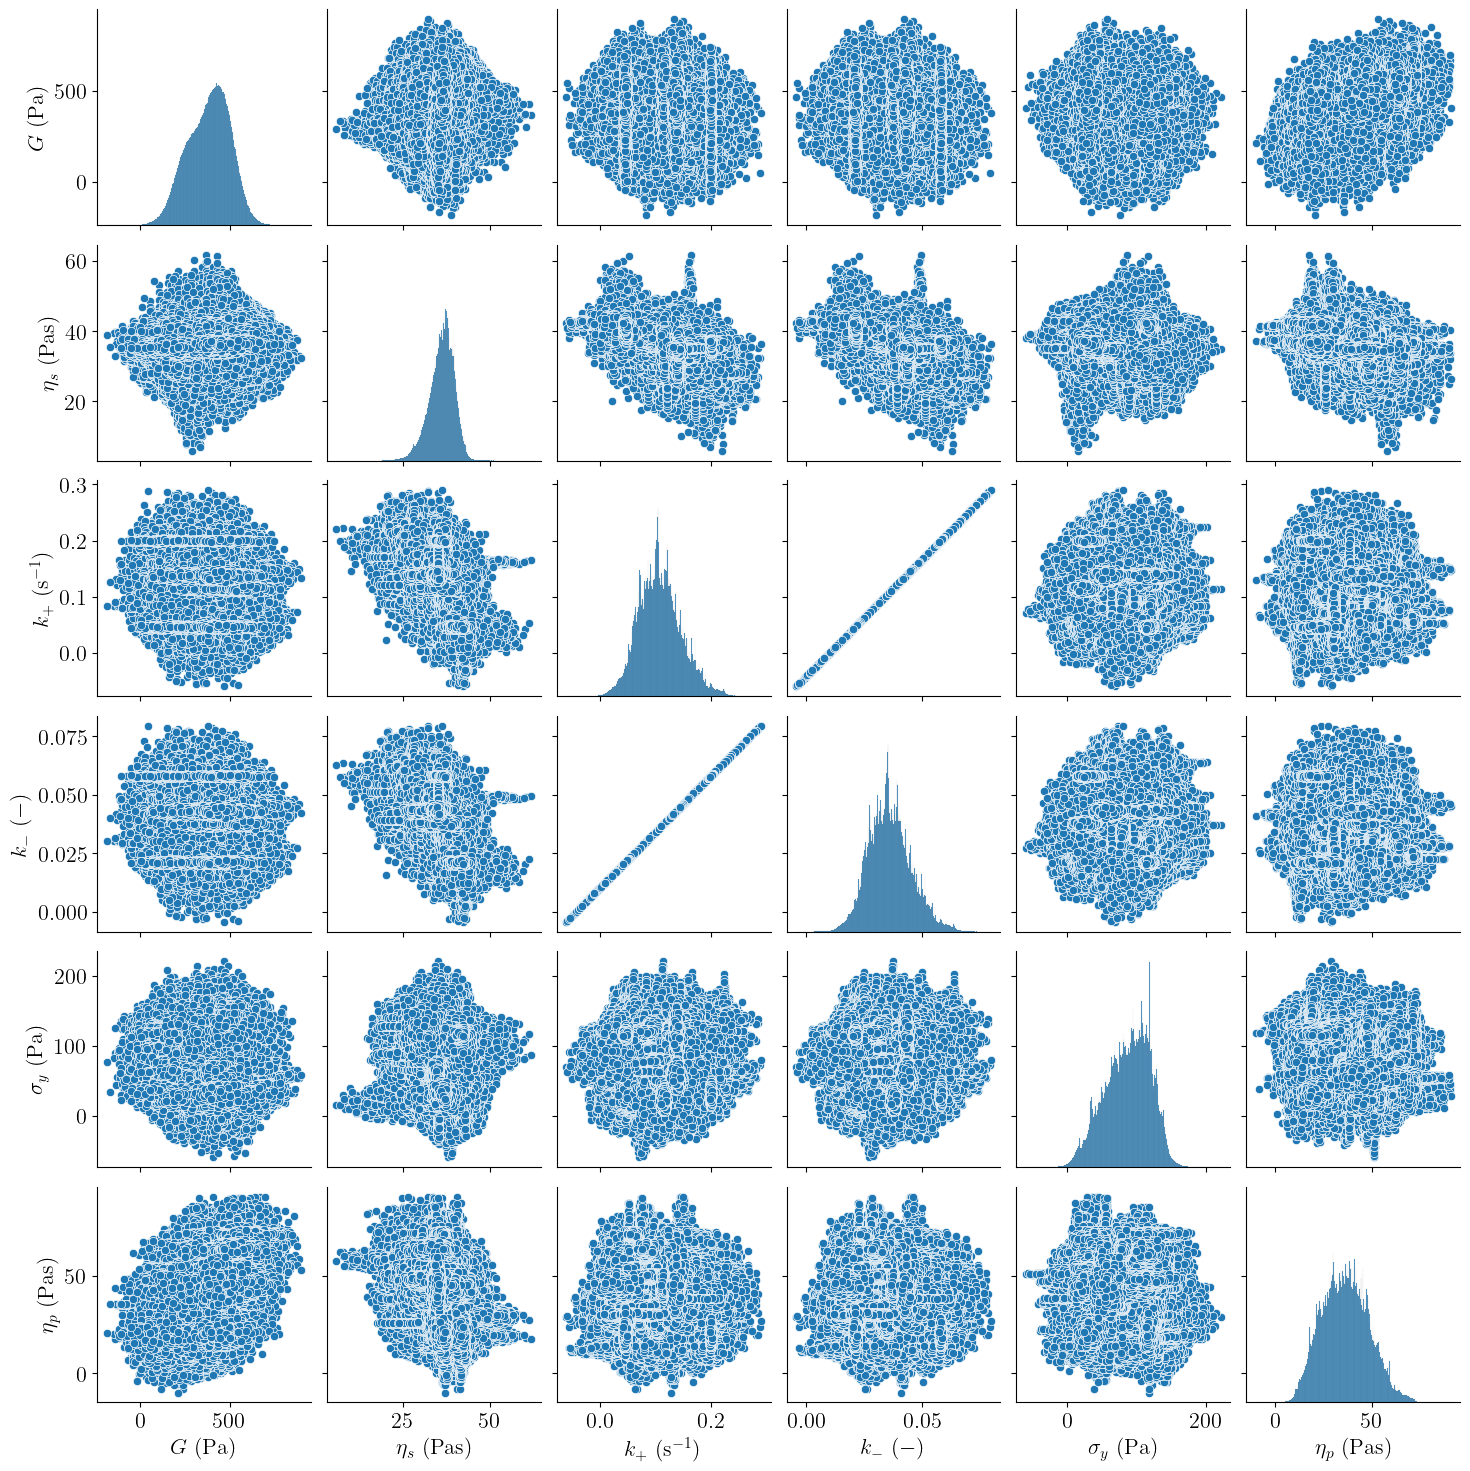

In [30]:
## Corner plot of sampled data ##

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm" 

xvars = [r"$G~\rm{(Pa)}$",r"$\eta_s~\rm{(Pa s)}$",r"$k_{+}~\rm{(s^{-1})}$",r"$k_{-}~\rm{(-)}$",r"$\sigma_y~\rm{(Pa)}$",r"$\eta_p~\rm{(Pa s)}$"]

pairplotdata = pd.DataFrame(data=model_params_all,columns=["G", "eta_s", "kp", "kn", "Yield_stress",  "eta_p",\
                                                               "ic5", "ic6", "ic7", "ic8", "ic9"])
pairplotdata["G"] = pairplotdata["G"]*(G_max-G_min) + G_min
pairplotdata["eta_s"] = pairplotdata["eta_s"]*(eta_s_max-eta_s_min) + eta_s_min
pairplotdata["kp"] = pairplotdata["kp"]*(k_p_max-k_p_min) + k_p_min
pairplotdata["kn"] = pairplotdata["kp"]*(k_n_max-k_n_min) + k_n_min
pairplotdata["Yield_stress"] = pairplotdata["Yield_stress"]*(sigma_y_max-sigma_y_min) + sigma_y_min
pairplotdata["eta_p"] = pairplotdata["eta_p"]*(eta_p_max-eta_p_min) + eta_p_min

pp1 = sns.pairplot(pairplotdata,vars=["G", "eta_s", "kp", "kn", "Yield_stress", "eta_p"],kind="scatter")
pp1.x_vars = xvars
pp1.y_vars = xvars
pp1._add_axis_labels()


plt.savefig('Pairplot_TEVP_678.png',format='png',bbox_inches='tight')
plt.savefig('Pairplot_TEVP_678.pdf',format='pdf',bbox_inches='tight')

(88800, 1)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


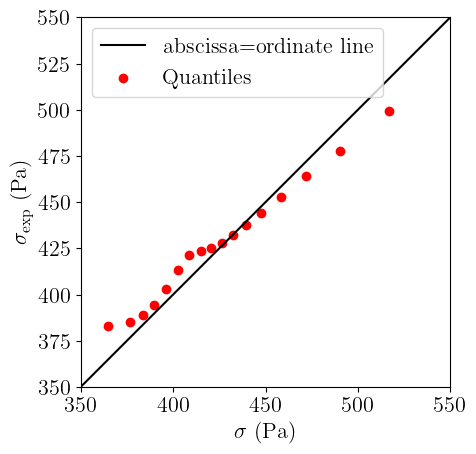

In [31]:
## Q-Q plot ##

shear_stress_all_prediction =  np.zeros((600,148)) # Holding data for test shear rates
for itr in range(0,300*2,2):
    rand_list = [*range(1,num_samples*act_samples),1]
    #print(rand_list)
    model_param_idx = random.choice(rand_list)
    lambda_0 = 1
    # print(model_param_idx)
    theta = model_params_all[model_param_idx,:]
    count1 = 8
    for arg in range(3,5): # For test data - 9/s and 10/s
        count1 = count1 + 1
        shear_rate_ode = shear_rate_all[arg]
        y0 = y0_all[arg]
        if arg==3:
            shear_stress_an = shear_stress_analytical(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],shear_rate_ode,y0,theta[count1],times)
            shear_stress_all_prediction[itr,:] = shear_stress_an + noise_params[model_param_idx,:]
        elif arg==4:
            shear_stress_an = shear_stress_analytical(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],shear_rate_ode,y0,theta[count1],times)
            shear_stress_all_prediction[itr+1,:] = shear_stress_an + noise_params[model_param_idx,:]
   
shear_stress_predict = shear_stress_all_prediction.reshape(-1,1)
print(np.shape(shear_stress_predict))  

shear_stress_test = np.zeros(296,)
shear_stress_test[0:148] = shear_stress_global[:,7]
shear_stress_test[148:296] = shear_stress_global[:,8]

# Q-Q plot #

def qqplot(x, y):
    """Draw a quantile-quantile plot for x vs y`.
 
    Parameters
    ----------
    x, y : array-like
        One-dimensional numeric arrays.
 
    ax : matplotlib.axes.Axes, optional
        Axes on which to plot. If not provided, the current axes will be used.
 
    quantiles : int or array-like, number of evenly spaced quantiles
    """
    yy = np.linspace(350,550)
    quantiles = 20 #min(len(x), len(y))
 
    # Compute quantiles of the two samples
    if isinstance(quantiles, numbers.Integral):
        quantiles = np.linspace(start=0, stop=1, num=int(quantiles))
    else:
        quantiles = np.atleast_1d(np.sort(quantiles))
    x_quantiles = np.quantile(x, quantiles, method="nearest")
    y_quantiles = np.quantile(y, quantiles, method="nearest")
    plt.plot(yy,yy,'-k',label='abscissa=ordinate line')
    plt.scatter(x_quantiles, y_quantiles,c='r',label='Quantiles')
    plt.xlim([350,550])
    plt.ylim([350,550])
    plt.xlabel(r'$\sigma$ (Pa)')
    plt.ylabel(r'$\sigma_\mathrm{exp}$ (Pa)')
    plt.legend()
    plt.gca().set_aspect('equal')
    plt.savefig('qq_plot_TEVP_678.pdf',format='pdf',bbox_inches='tight')
    plt.savefig('qq_plot_TEVP_678.eps',format='eps',bbox_inches='tight')
    plt.savefig('qq_plot_TEVP_678.png',format='png',bbox_inches='tight')
    plt.show()

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"    
# shear_stress_predict contains shear stress obtained from last set of sampled unknown model parameters
qqplot(shear_stress_predict,shear_stress_test)


Sampling: [Y_obs]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


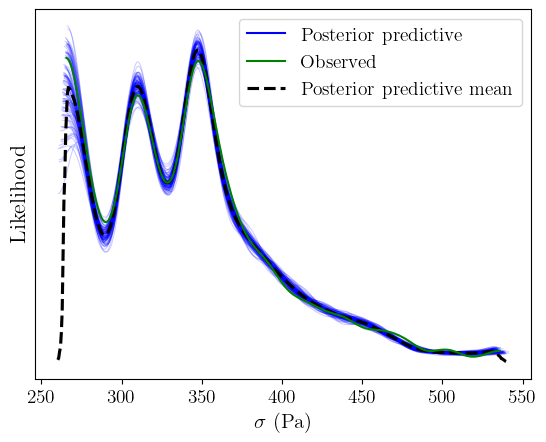

In [32]:
## Posterior Predictive Checks ##

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm" 

with model_678:
 pm.sample_posterior_predictive(idata_678, extend_inferencedata=True, random_seed=rng) #imdata

#print(idata)
az.plot_ppc(idata_678, num_pp_samples=100, colors = ["b","g","k"])
plt.xlabel(r"$\sigma$ (Pa)")
plt.ylabel("Likelihood")
plt.legend(fontsize="14")
plt.savefig('TEVP_ppc.pdf',format='pdf') 
plt.savefig('TEVP_ppc.eps',format='eps') 
plt.savefig('png-TEVP_ppc.png',format='png')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


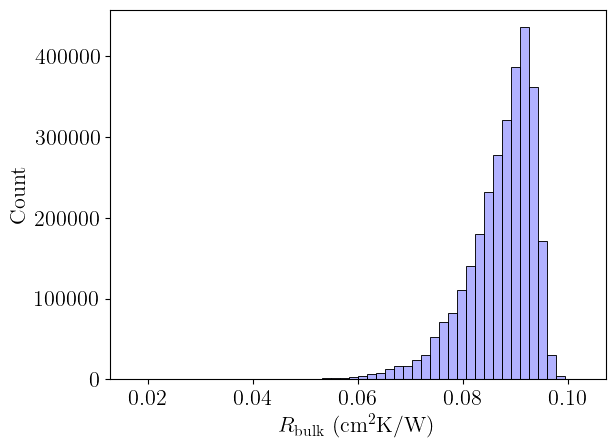

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


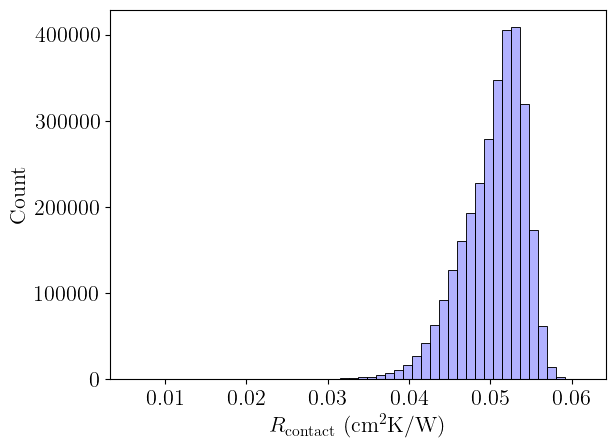

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


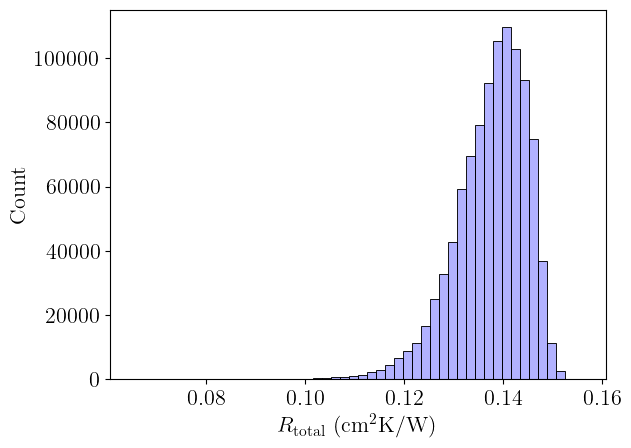

In [33]:
## Propogating uncertainty into thermal resistance ##

C = 1.31*10**(-4)
m = 0.166
P = 151685 # 22 psi
k_tim = 4.3
BLT = np.zeros((num_samples*act_samples,1))
BLT = C*(((model_params_all[:,4])*(sigma_y_max-sigma_y_min)+sigma_y_min)/P)**m
R_bulk = BLT*10**(4)/k_tim
ax = plt.gca()
sns.histplot(R_bulk,fill=True,color='b',alpha=0.3,bins=50,ax=ax) #cm^2K/W
plt.xlabel(r"$R_\mathrm{bulk}~\rm{(cm^2K/W)}$")
plt.savefig('TEVP_R_bulk_678.png',format='png',bbox_inches='tight')
plt.savefig('TEVP_R_bulk_678.eps',format='eps',bbox_inches='tight')
plt.show()

C2 = 82.96
n_exp = 0.223
roughness = 10**(-6) #1 mu-m 
R_c = np.zeros((num_samples*act_samples,1))
R_c = C2*(((model_params_all[:,0])*(G_max-G_min)+G_min)/P)**n_exp * (roughness/k_tim)
R_c = R_c*10**4
ax = plt.gca()
sns.histplot(R_c,fill=True,color='b',alpha=0.3,bins=50,ax=ax) #cm^2K/W
plt.xlabel(r"$R_\mathrm{contact}~\rm{(cm^2K/W)}$")
plt.savefig('TEVP_R_contact_678.png',format='png',bbox_inches='tight')
plt.savefig('TEVP_R_contact_678.eps',format='eps',bbox_inches='tight')
plt.show()

R_total = R_c+R_bulk
ax = plt.gca()
sns.histplot(R_total[0:1000000],fill=True,color='b',bins=50,alpha=0.3,ax=ax) #cm^2K/W
plt.xlabel(r"$R_\mathrm{total}~\rm{(cm^2K/W)}$")
plt.savefig('TEVP_R_total.png',format='png',bbox_inches='tight')
plt.savefig('TEVP_R_total.eps',format='eps',bbox_inches='tight')
plt.show()

In [34]:
## Saving thermal resistance data ##

R_total_selected = R_total[0:1000000]
R_bulk_selected = R_bulk[0:1000000]
R_contact_selected = R_c[0:1000000]
R_TEVP = np.zeros((1000000,3))
R_TEVP[:,0] = R_total_selected
R_TEVP[:,1] = R_bulk_selected
R_TEVP[:,2] = R_contact_selected
print(np.shape(R_TEVP))

# print(np.shape(R_total_selected))
resistance_TEVP_df = pd.DataFrame(R_TEVP,columns=["Total","Bulk","Contact"])
print(np.shape(resistance_TEVP_df))
resistance_TEVP_df.to_excel("R_total_TEVP.xlsx")

(1000000, 3)
(1000000, 3)


## Training data: 6 and 7/s ##

In [39]:
y0_train = [455.37,472.96]
shear_rate_train = [6.0,7.0]

shear_stress_training_2 = np.zeros(296,)
shear_stress_training_2[0:148] = shear_stress_global[:,4]      
shear_stress_training_2[148:296] = shear_stress_global[:,5]    

print(np.shape(shear_stress_training_2)) # contains data for 6/s and 7/s

times_1d = np.append(times,times)
times_1d = times_1d.reshape(-1)
print(np.shape(times_1d))

shear_rate_6_idx = 0*np.ones(148)
shear_rate_7_idx = 1*np.ones(148)
shear_rate_idx = np.append(shear_rate_6_idx,shear_rate_7_idx)
shear_rate_idx = shear_rate_idx.reshape(-1)
shear_rate_idx = np.asarray(shear_rate_idx,dtype='int')
print(np.shape(shear_rate_idx))

shear_rate_6 = 6.0*np.ones(148)
shear_rate_7 = 7.0*np.ones(148)
shear_rate_1d = np.append(shear_rate_6,shear_rate_7) 
shear_rate_1d = shear_rate_1d.reshape(-1)
print(np.shape(shear_rate_1d))

stress_ic_6 = y0_all[0]*np.ones(148)
stress_ic_7 = y0_all[1]*np.ones(148)
stress_ic_1d = np.append(stress_ic_6,stress_ic_7) 
stress_ic_1d = stress_ic_1d.reshape(-1)
print(np.shape(stress_ic_1d))


(296,)
(296,)
(296,)
(296,)
(296,)


In [40]:
#coords = {"time_coord": times, "shear_rate_coord": shear_rate_all}
coords = {"shear_rate_coord": shear_rate_train}

In [41]:
## Defining the UQ model ##
with pm.Model(coords=coords) as model_67:
    time_data = pm.ConstantData("time_data", times_1d, dims="obs_id")
    shear_rate_data = pm.ConstantData("shear_rate_data", shear_rate_train, dims="shear_rate_coord")
    print(pm.draw(time_data).size)
    
    mu_g = pm.Beta("mu_g",alpha=2.0,beta=2.0) 
    #mu_g = pm.Normal("mu_g",mu=0.0,sigma=1.0)
    sigma_g = pm.HalfNormal("sigma_g",sigma=0.05) #0.01
    
    mu_eta_s = pm.Beta("mu_eta_s",alpha=2.0,beta=2.0)
    #mu_eta_s = pm.Normal("mu_eta_s",mu=0.0,sigma=1.0)
    sigma_eta_s = pm.HalfNormal("sigma_eta_s",sigma=0.05)

    mu_k_p = pm.Beta("mu_k_p",alpha=2.0,beta=2.0)
    #mu_k_p = pm.Normal("mu_k_p",mu=0.0,sigma=1.0)
    sigma_k_p = pm.HalfNormal("sigma_k_p",sigma=0.05)

    mu_k_n = pm.Beta("mu_k_n",alpha=2.0,beta=2.0)
    #mu_k_n = pm.Normal("mu_k_n",mu=0.0,sigma=1.0)
    sigma_k_n = pm.HalfNormal("sigma_k_n",sigma=0.05)
    
    mu_sigma_y = pm.Beta("mu_sigma_y",alpha=2.0,beta=2.0)
    #mu_sigma_y = pm.Normal("mu_sigma_y",mu=0.0,sigma=1.0)
    sigma_sigma_y = pm.HalfNormal("sigma_sigma_y",sigma=0.05)

    mu_eta_p = pm.Beta("mu_eta_p",alpha=2.0,beta=2.0)
    #mu_eta_p = pm.Normal("mu_eta_p",mu=0.0,sigma=1.0)
    sigma_eta_p = pm.HalfNormal("sigma_eta_p",sigma=0.05)

    #mu_lambda_ic = pm.Beta("mu_lambda_ic",alpha=2.0,beta=2.0)
    #sigma_lambda_ic = pm.HalfNormal("sigma_lambda_ic",sigma=0.1)
    
    ## Priors: dimensional unknown model parameters using non-centered paramterization ##
    z_G = pm.Normal("z_G",mu=0,sigma=1,dims="shear_rate_coord")
    G = pm.Deterministic("G", mu_g+sigma_g*z_G, dims="shear_rate_coord")
    #G = pm.Deterministic("G", np.exp(mu_g+sigma_g*z_G), dims="shear_rate_coord")
    G_dd = pm.Deterministic("G_dd", G*(G_max-G_min)+G_min, dims="shear_rate_coord")
    
    z_eta_s = pm.Normal("z_eta_s",mu=0,sigma=1,dims="shear_rate_coord")
    eta_s = pm.Deterministic("eta_s", mu_eta_s + sigma_eta_s*z_eta_s, dims="shear_rate_coord")
    eta_s_dd = pm.Deterministic("eta_s_dd", eta_s*(eta_s_max-eta_s_min)+eta_s_min, dims="shear_rate_coord")

    z_k_p = pm.Normal("z_k_p",mu=0,sigma=1,dims="shear_rate_coord")
    k_p = pm.Deterministic("k_p", mu_k_p + sigma_k_p*z_k_p, dims="shear_rate_coord")
    k_p_dd = pm.Deterministic("k_p_dd", k_p*(k_p_max-k_p_min)+k_p_min, dims="shear_rate_coord")

    z_k_n = pm.Normal("z_k_n",mu=0,sigma=1,dims="shear_rate_coord")
    k_n = pm.Deterministic("k_n", mu_k_n + sigma_k_n*z_k_n, dims="shear_rate_coord")
    k_n_dd = pm.Deterministic("k_n_dd", k_n*(k_n_max-k_n_min)+k_n_min, dims="shear_rate_coord")
    
    z_sigma_y = pm.Normal("z_sigma_y",mu=0,sigma=1,dims="shear_rate_coord")
    sigma_y = pm.Deterministic("sigma_y", mu_sigma_y + sigma_sigma_y*z_sigma_y, dims="shear_rate_coord")
    sigma_y_dd = pm.Deterministic("sigma_y_dd", sigma_y*(sigma_y_max-sigma_y_min)+sigma_y_min, dims="shear_rate_coord")

    z_eta_p = pm.Normal("z_eta_p",mu=0,sigma=1,dims="shear_rate_coord")
    eta_p = pm.Deterministic("eta_p", mu_eta_p + sigma_eta_p*z_eta_p, dims="shear_rate_coord")
    eta_p_dd = pm.Deterministic("eta_p_dd", eta_p*(eta_p_max-eta_p_min)+eta_p_min, dims="shear_rate_coord")

    lambda_a = pm.Beta("lambda_a", alpha=2.0, beta=5.0) #, dims="shear_rate_coord")
    lambda_b = pm.Beta("lambda_b",alpha=2.0, beta=5.0) #, dims="shear_rate_coord")
    # lambda_b = pm.Gamma("lambda_b",alpha=2.0, beta=0.5) #, dims="shear_rate_coord")
    lambda_ic = pm.Deterministic("lambda_ic",lambda_a*np.exp(-lambda_b*(shear_rate_data)), dims="shear_rate_coord")
    
    T_dd = pm.Deterministic("T_dd", (k_p_dd + k_n_dd*shear_rate_data)/(G_dd/(eta_s_dd+eta_p_dd)), dims="shear_rate_coord")
    R_dd = pm.Deterministic("R_dd", k_p_dd/(k_p_dd + k_n_dd*shear_rate_data), dims="shear_rate_coord")
    
    ## Experiment measurement uncertainty ##
    sigma = pm.Exponential("sigma", 2.0) # rate parameter = 5.0  2.0

    shear_stress_mean = eta_s_dd[shear_rate_idx]*shear_rate_1d + (sigma_y_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx]*shear_rate_1d)*R_dd[shear_rate_idx] + \
               (stress_ic_1d  - eta_s_dd[shear_rate_idx]*shear_rate_1d + (sigma_y_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx]*shear_rate_1d)*((lambda_ic[shear_rate_idx]-R_dd[shear_rate_idx]*T_dd[shear_rate_idx])/(T_dd[shear_rate_idx]-1)))*np.exp(-G_dd[shear_rate_idx]*(time_data-0.11)/(eta_s_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx])) + \
               (sigma_y_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx]*shear_rate_1d)*((R_dd[shear_rate_idx]-lambda_ic[shear_rate_idx])/(T_dd[shear_rate_idx]-1))*np.exp(-(k_p_dd[shear_rate_idx]+k_n_dd[shear_rate_idx]*shear_rate_1d)*(time_data-0.11))
    
    #print(pm.draw(shear_stress_mean).shape)

    ## Likelihood ##
    pm.Normal("Y_obs", mu=shear_stress_mean, sigma=sigma, observed=shear_stress_training_2, dims = "obs_id") 
    idata_67 = pm.sample_prior_predictive(samples=10000, random_seed=rng)

print(idata_67)

296


Sampling: [Y_obs, lambda_a, lambda_b, mu_eta_p, mu_eta_s, mu_g, mu_k_n, mu_k_p, mu_sigma_y, sigma, sigma_eta_p, sigma_eta_s, sigma_g, sigma_k_n, sigma_k_p, sigma_sigma_y, z_G, z_eta_p, z_eta_s, z_k_n, z_k_p, z_sigma_y]


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data


In [42]:
tune = 2000 #2000
draws = 10000 #50000 
with model_67:
    idata_67.extend(pm.sample(tune=tune, draws=draws, target_accept=0.85, random_seed=rng, discard_tuned_samples=True))
print(idata_67)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_g, sigma_g, mu_eta_s, sigma_eta_s, mu_k_p, sigma_k_p, mu_k_n, sigma_k_n, mu_sigma_y, sigma_sigma_y, mu_eta_p, sigma_eta_p, z_G, z_eta_s, z_k_p, z_k_n, z_sigma_y, z_eta_p, lambda_a, lambda_b, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 7301 seconds.
There were 83 divergences after tuning. Increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data


In [43]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm" 

num_samples = 1000 #1000 # Hyper-prior samples 1000
thin_every = 40 #100
itr_samples = num_samples*thin_every
no_samples = itr_samples*len(shear_rate_train) # New normal model samples 1000
act_samples = no_samples/thin_every
act_samples = int(act_samples)
print(act_samples)
model_params_all_2 = np.zeros((num_samples*act_samples,11)) 
noise_params_2 = np.zeros((num_samples*act_samples,1)) 

# extracting normalized model parameters from posterior distribution #
imdata_pred_67 = az.extract(idata_67, group = "posterior", num_samples=itr_samples).to_dataframe() #itr_samples
print(np.shape(imdata_pred_67))
# Hyperpriors are same across all shear rates #
mean_cols = ["mu_g", "mu_eta_s", "mu_k_p", "mu_k_n", "mu_sigma_y", "mu_eta_p"]
sigma_cols = ["sigma_g", "sigma_eta_s", "sigma_k_p", "sigma_k_n", "sigma_sigma_y", "sigma_eta_p"]
std_cols = ["z_G", "z_eta_s", "z_k_p", "z_k_n", "z_sigma_y", "z_eta_p"]
lambda_cols = ["lambda_a","lambda_b"]
noise_cols = ["sigma"]

count = -1
for row_idx_1 in range(0,itr_samples,thin_every): # Selecting one sample from every five samples ange(0,itr_samples,5)
    count = count + 1
    mean_row = imdata_pred_67.iloc[row_idx_1, :][mean_cols].values
    sigma_row = imdata_pred_67.iloc[row_idx_1, :][sigma_cols].values
    lambda_row = imdata_pred_67.iloc[row_idx_1, :][lambda_cols].values
    #model_error_row = imdata_pred.iloc[row_idx_1, :][model_error_cols].values
    noise_row = imdata_pred_67.iloc[row_idx_1, :][noise_cols].values
    noise_dist = st.norm(0,noise_row)

     # Defining normal distribution of extracted normalized model parameters #
    #z_std = st.norm(0,1)
    # noise_dist = st.laplace(0,noise_row)
    count_1 = -1
    for row_idx_2 in range(0,no_samples,thin_every):
        count_1 = count_1 + 1
        # imdata_pred has itr_samples*3 rows (1500). Since no_samples is 100, we are sampling everything from 0.07/s for now
        z_row = imdata_pred_67.iloc[row_idx_2, :][std_cols].values
        
        # lambda_row = imdata_pred.iloc[row_idx_2, :][lambda_cols].values
        
        # G_predicted = np.exp(mean_row[0]+sigma_row[0]*z_row[0])   #z_std.rvs(size=1)
        G_predicted = mean_row[0]+sigma_row[0]*z_row[0]
        eta_s_predicted = mean_row[1]+sigma_row[1]*z_row[1]
        k_p_predicted = mean_row[2]+sigma_row[2]*z_row[2]
        k_n_predicted = mean_row[3]+sigma_row[3]*z_row[3]
        sigma_y_predicted = mean_row[4]+sigma_row[4]*z_row[4]
        eta_p_predicted = mean_row[5]+sigma_row[5]*z_row[5]
        
        lambda_ic_6 = lambda_row[0]*np.exp(-lambda_row[1]*(6))
        lambda_ic_7 = lambda_row[0]*np.exp(-lambda_row[1]*(7))
        lambda_ic_8 = lambda_row[0]*np.exp(-lambda_row[1]*(8))
        lambda_ic_9 = lambda_row[0]*np.exp(-lambda_row[1]*(9))
        lambda_ic_10 = lambda_row[0]*np.exp(-lambda_row[1]*(10))
        
        model_params_all_2[count_1+(count)*act_samples,0] = G_predicted
        model_params_all_2[count_1+(count)*act_samples,1] = eta_s_predicted
        model_params_all_2[count_1+(count)*act_samples,2] = k_p_predicted
        model_params_all_2[count_1+(count)*act_samples,3] = k_n_predicted
        model_params_all_2[count_1+(count)*act_samples,4] = sigma_y_predicted
        model_params_all_2[count_1+(count)*act_samples,5] = eta_p_predicted
        
        model_params_all_2[count_1+(count)*act_samples,6] = lambda_ic_6
        model_params_all_2[count_1+(count)*act_samples,7] = lambda_ic_7
        model_params_all_2[count_1+(count)*act_samples,8] = lambda_ic_8
        model_params_all_2[count_1+(count)*act_samples,9] = lambda_ic_9
        model_params_all_2[count_1+(count)*act_samples,10] = lambda_ic_10

        noise_params_2[count_1+(count)*act_samples,0] = noise_dist.rvs(size=1)
        
print(np.shape(model_params_all_2))
print(np.shape(noise_params_2))


2000
(80000, 38)
(2000000, 11)
(2000000, 1)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


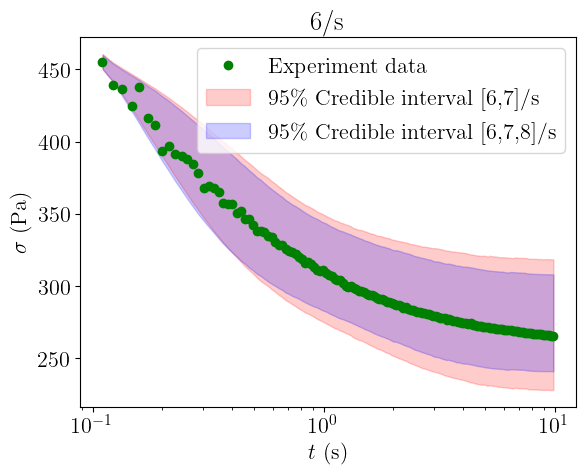

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


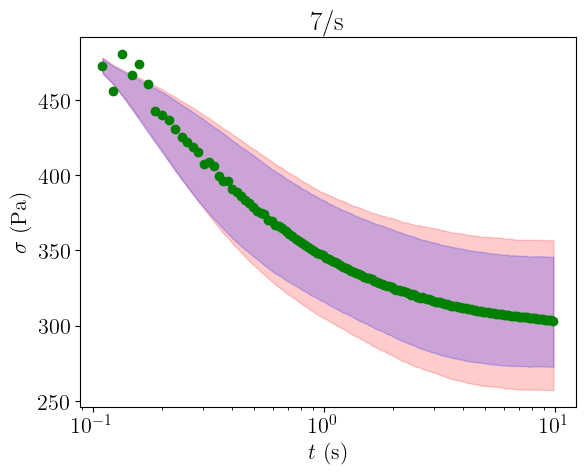

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


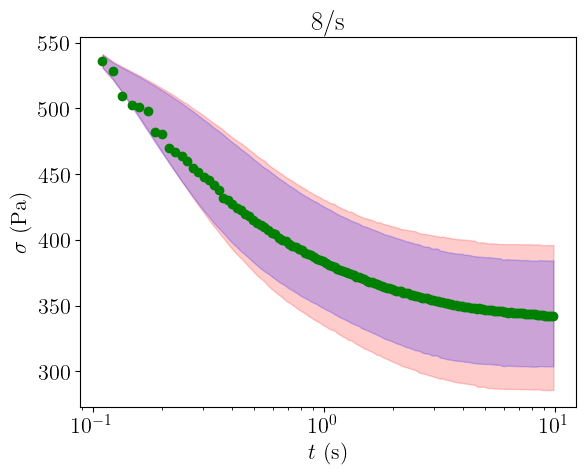

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


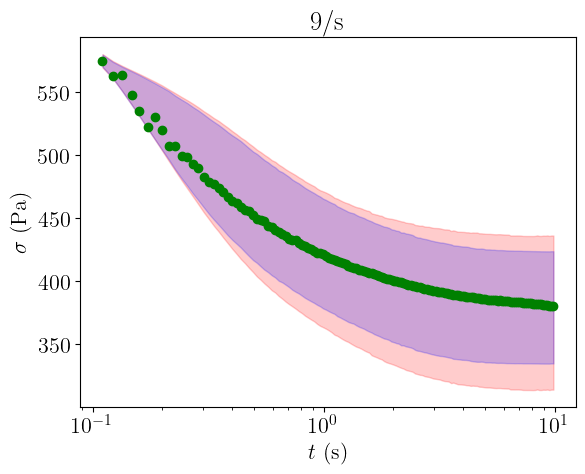

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


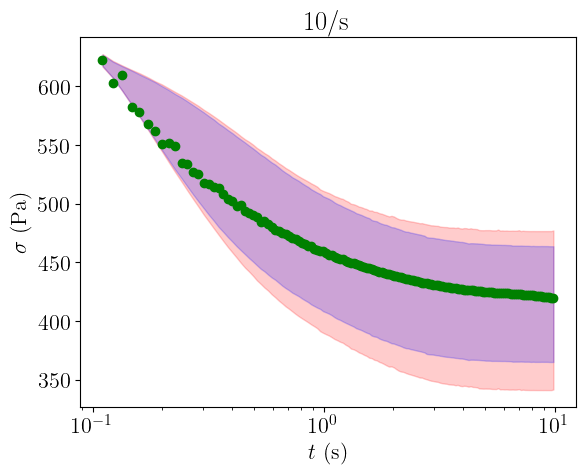

In [44]:
# Using dimensional time and dimensional IC to get dimensional shear stress
ic_count = 5
for arg in range(0,5): #9
    #if arg==1 or arg==3 or arg==5:
    #if arg==5:
    #    continue
    ic_count = ic_count + 1
    #arg = 1 
    shear_stress_all_prediction = np.zeros((num_samples*act_samples,148))
    shear_stress_all_prediction_2 = np.zeros((num_samples*act_samples,148))
    shear_rate_ode = shear_rate_all[arg]
    y0 = y0_all[arg]
    lambda_0 = lambda_true[arg]

    stress_analytical_pinn = shear_stress_analytical((G_true-G_min)/(G_max-G_min),(eta_s_true-eta_s_min)/(eta_s_max-eta_s_min),\
                                                 (k_p_true-k_p_min)/(k_p_max-k_p_min),(k_n_true-k_n_min)/(k_n_max-k_n_min),\
                                                 (sigma_y_true-sigma_y_min)/(sigma_y_max-sigma_y_min),(eta_p_true-eta_p_min)/(eta_p_max-eta_p_min),\
                                                 shear_rate_ode,y0,lambda_0,times)
    shear_stress_expt = shear_stress_global[:,arg+4]

    plt.plot(times,shear_stress_expt,'og', label='Experiment data')
    #plt.plot(times,stress_analytical_pinn,'-k', label='PINN analytical solution',linewidth=3)
    #model_error = np.zeros(np.size(times))
    for row_idx_1 in range(0,num_samples): 
        for row_idx_2 in range(0,act_samples):
            theta_2 = model_params_all_2[row_idx_2+row_idx_1*act_samples,:]
            shear_stress_an_2 = shear_stress_analytical(theta_2[0],theta_2[1],theta_2[2],theta_2[3],theta_2[4],theta_2[5],shear_rate_ode,y0,theta_2[ic_count],times)
            shear_stress_all_prediction_2[row_idx_2+row_idx_1*act_samples,:] = shear_stress_an_2 + noise_params_2[row_idx_2+row_idx_1*act_samples,0] 

            theta = model_params_all[row_idx_2+row_idx_1*act_samples,:]
            shear_stress_an = shear_stress_analytical(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],shear_rate_ode,y0,theta[ic_count],times)
            shear_stress_all_prediction[row_idx_2+row_idx_1*act_samples,:] = shear_stress_an + noise_params[row_idx_2+row_idx_1*act_samples,0]
    
    #plt.plot(times,shear_stress_an,'-g',alpha=0.5)
    #plt.plot(np.NaN,np.NaN,'-g',alpha=0.1,label='Posterior Samples')
    #print(np.shape(shear_stress_all_prediction))
    stress_low = np.zeros(np.size(times))
    stress_high = np.zeros(np.size(times))
    
    stress_low_2 = np.zeros(np.size(times))
    stress_high_2 = np.zeros(np.size(times))
    
    stress_mean = np.zeros(np.size(times))
    #stress_mean = np.mean(shear_stress_all_prediction,axis=0)
    for itr in range(0,np.size(times)):
        stress_low_2[itr] = az.hdi(shear_stress_all_prediction_2[:,itr],0.95)[0]
        stress_high_2[itr] = az.hdi(shear_stress_all_prediction_2[:,itr],0.95)[1]

        stress_low[itr] = az.hdi(shear_stress_all_prediction[:,itr],0.95)[0]
        stress_high[itr] = az.hdi(shear_stress_all_prediction[:,itr],0.95)[1]
    plt.fill_between(times,stress_low_2,stress_high_2,color='r',alpha=0.2,label=r'95\% Credible interval [6,7]/s')
    plt.fill_between(times,stress_low,stress_high,color='b',alpha=0.2,label=r'95\% Credible interval [6,7,8]/s')
    #stress_mean = (stress_low + stress_high)/2
    #plt.plot(times,stress_mean,'-r', label='Prediction mean',linewidth=3)
    #plt.title(r'$3$/s')
    #plt.title('%d/s',arg+2)
    plt.title(r'%d/s' % (arg+6))
    plt.xlabel(r'$t$ (s)')
    plt.ylabel(r'$\sigma$ (Pa)')
    plt.xscale('log')
    if arg==0:
        plt.legend()
    plt.savefig(r'TEVP_%ds_67.png' % (arg+2),format='png',bbox_inches='tight')
    plt.savefig(r'TEVP_%ds_67.eps' % (arg+2),format='eps',bbox_inches='tight')
    plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


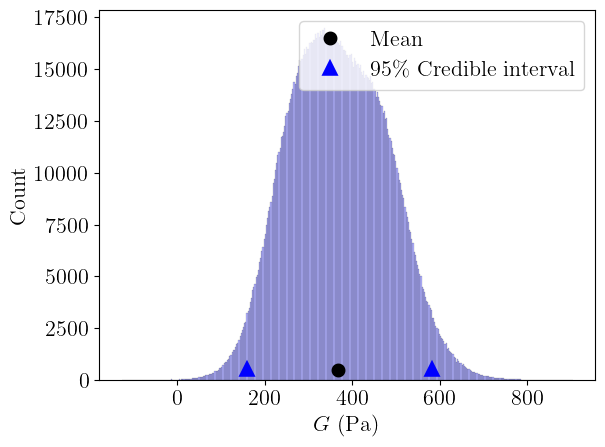

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


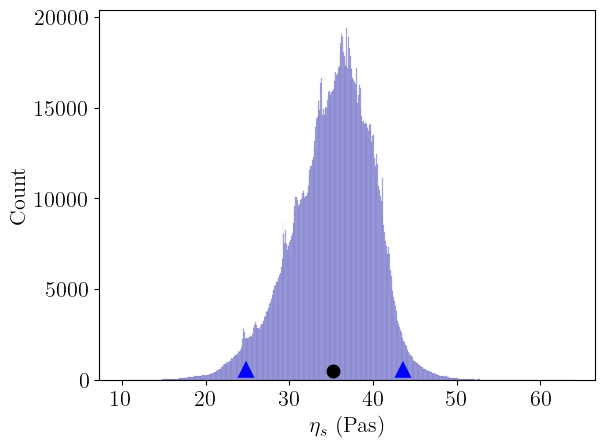

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


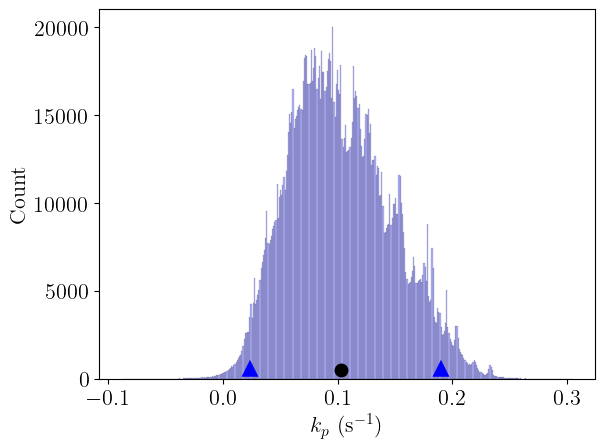

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


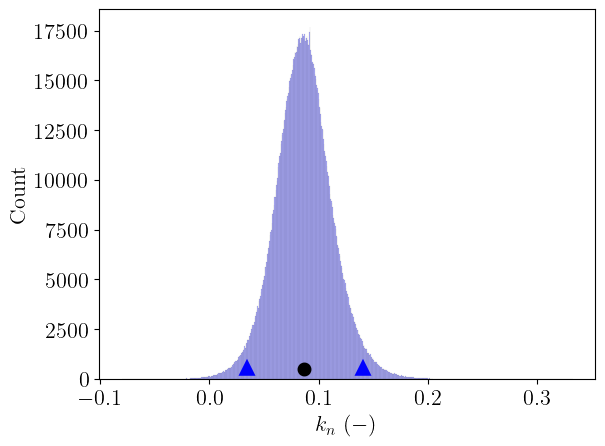

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


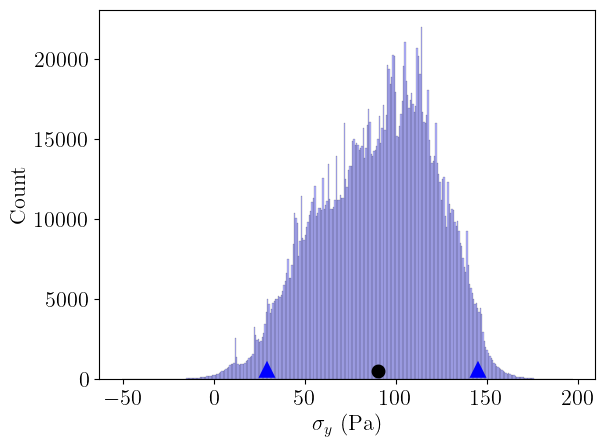

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


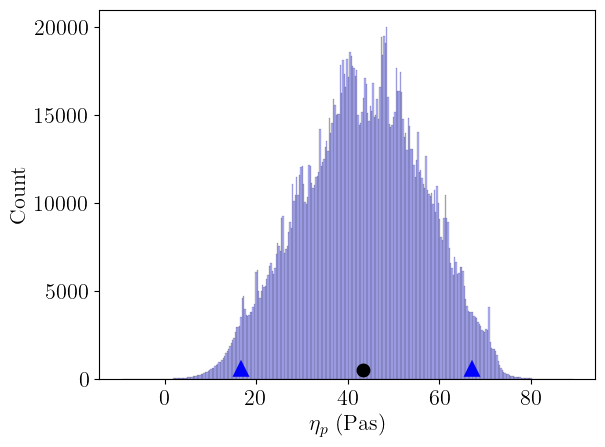

In [45]:
# Comparing model parameter distribution with PINN value #

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
sns.set_style(None)

G_low = az.hdi(model_params_all_2[:,0],0.95)[0]*(G_max-G_min) + G_min
G_high = az.hdi(model_params_all_2[:,0],0.95)[1]*(G_max-G_min) + G_min

eta_s_low = az.hdi(model_params_all_2[:,1],0.95)[0]*(eta_s_max-eta_s_min) + eta_s_min
eta_s_high = az.hdi(model_params_all_2[:,1],0.95)[1]*(eta_s_max-eta_s_min) + eta_s_min

k_p_low = az.hdi(model_params_all_2[:,2],0.95)[0]*(k_p_max-k_p_min) + k_p_min
k_p_high = az.hdi(model_params_all_2[:,2],0.95)[1]*(k_p_max-k_p_min) + k_p_min

k_n_low = az.hdi(model_params_all_2[:,3],0.95)[0]*(k_n_max-k_n_min) + k_n_min
k_n_high = az.hdi(model_params_all_2[:,3],0.95)[1]*(k_n_max-k_n_min) + k_n_min

sigma_y_low = az.hdi(model_params_all_2[:,4],0.95)[0]*(sigma_y_max-sigma_y_min) + sigma_y_min 
sigma_y_high = az.hdi(model_params_all_2[:,4],0.95)[1]*(sigma_y_max-sigma_y_min) + sigma_y_min

eta_p_low = az.hdi(model_params_all_2[:,5],0.95)[0]*(eta_p_max-eta_p_min) + eta_p_min
eta_p_high = az.hdi(model_params_all_2[:,5],0.95)[1]*(eta_p_max-eta_p_min) + eta_p_min


ax=plt.gca()
ax.plot([np.mean(model_params_all_2[:,0]*(G_max-G_min)+G_min,axis=0)],[500.0],'o',color='k',markeredgewidth=4,label='Mean')
ax.plot([G_low, G_high],[500.0, 500.0],'^',color='b',markeredgewidth=4, label='95\% Credible interval')
#ax.plot([np.mean(model_params_all[:,0])*(G_max-G_min)+G_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all_2[:,0]*(G_max-G_min) + G_min,fill=True,color='b',alpha=0.3,ax=ax)
plt.xlabel(r"$G~\rm{(Pa)}$")
plt.legend()
plt.savefig('TEVP_G_67.png',format='png',bbox_inches='tight')
plt.savefig('TEVP_G_67.eps',format='eps',bbox_inches='tight')
plt.show()

ax = plt.gca()
ax.plot([np.mean(model_params_all_2[:,1]*(eta_s_max-eta_s_min)+eta_s_min,axis=0)],[500.0],'o',color='k',markeredgewidth=4,label='Mean')
ax.plot([eta_s_low, eta_s_high],[500.0, 500.0],'^',color='b',markeredgewidth=4)
#ax.plot([np.mean(model_params_all[:,1])*(eta_s_max-eta_s_min)+eta_s_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all_2[:,1]*(eta_s_max-eta_s_min) + eta_s_min,fill=True,color='b',alpha=0.3,ax=ax)
plt.xlabel(r"$\eta_s~\rm{(Pa s)}$")
plt.savefig('TEVP_eta_s_67.png',format='png',bbox_inches='tight')
plt.savefig('TEVP_eta_s_67.eps',format='eps',bbox_inches='tight')
plt.show()

ax = plt.gca()
ax.plot([np.mean(model_params_all_2[:,2]*(k_p_max-k_p_min)+k_p_min,axis=0)],[500.0],'o',color='k',markeredgewidth=4,label='Mean')
ax.plot([k_p_low, k_p_high],[500.0, 500.0],'^',color='b',markeredgewidth=4)
#ax.plot([np.mean(model_params_all[:,2])*(k_p_max-k_p_min)+k_p_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all_2[:,2]*(k_p_max-k_p_min) + k_p_min,fill=True,color='b',alpha=0.3,ax=ax)
plt.xlabel(r"$k_p~\rm{(s^{-1})}$")
plt.savefig('TEVP_k_p_67.png',format='png',bbox_inches='tight')
plt.savefig('TEVP_k_p_67.eps',format='eps',bbox_inches='tight')
plt.show()

ax = plt.gca()
ax.plot([np.mean(model_params_all_2[:,3]*(k_n_max-k_n_min)+k_n_min,axis=0)],[500.0],'o',color='k',markeredgewidth=4,label='Mean')
ax.plot([k_n_low, k_n_high],[500.0, 500.0],'^',color='b',markeredgewidth=4)
#ax.plot([np.mean(model_params_all[:,3])*(k_n_max-k_n_min)+k_n_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all_2[:,3]*(k_n_max-k_n_min) + k_n_min,fill=True,color='b',alpha=0.3,ax=ax)
plt.xlabel(r"$k_n~\rm{(-)}$")
plt.savefig('TEVP_k_n_67.png',format='png',bbox_inches='tight')
plt.savefig('TEVP_k_n_67.eps',format='eps',bbox_inches='tight')
plt.show()

ax = plt.gca()
ax.plot([np.mean(model_params_all_2[:,4]*(sigma_y_max-sigma_y_min)+sigma_y_min,axis=0)],[500.0],'o',color='k',markeredgewidth=4,label='Mean')
ax.plot([sigma_y_low, sigma_y_high],[500.0, 500.0],'^',color='b',markeredgewidth=4)
#ax.plot([np.mean(model_params_all[:,4])*(sigma_y_max-sigma_y_min)+sigma_y_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all_2[:,4]*(sigma_y_max-sigma_y_min) + sigma_y_min,fill=True,color='b',alpha=0.3,ax=ax)
plt.xlabel(r"$\sigma_y~\rm{(Pa)}$")
plt.savefig('TEVP_sigma_y_67.png',format='png',bbox_inches='tight')
plt.savefig('TEVP_sigma_y_67.eps',format='eps',bbox_inches='tight')
plt.show()

ax = plt.gca()
ax.plot([np.mean(model_params_all_2[:,5]*(eta_p_max-eta_p_min)+eta_p_min,axis=0)],[500.0],'o',color='k',markeredgewidth=4,label='Mean')
ax.plot([eta_p_low, eta_p_high],[500.0, 500.0],'^',color='b',markeredgewidth=4)
#ax.plot([np.mean(model_params_all[:,5])*(eta_p_max-eta_p_min)+eta_p_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all_2[:,5]*(eta_p_max-eta_p_min) + eta_p_min,fill=True,color='b',alpha=0.3,ax=ax)
plt.xlabel(r"$\eta_p~\rm{(Pa s)}$")
plt.savefig('TEVP_eta_p_67.png',format='png',bbox_inches='tight')
plt.savefig('TEVP_eta_p_67.eps',format='eps',bbox_inches='tight')
plt.show()



## Training data: 9 and 10/s ##

In [49]:
y0_train = [574.96,622.1]
shear_rate_train = [9.0,10.0]

shear_stress_training_3 = np.zeros(296,)
shear_stress_training_3[0:148] = shear_stress_global[:,7]      
shear_stress_training_3[148:296] = shear_stress_global[:,8]    

print(np.shape(shear_stress_training_3)) # contains data for 6/s and 7/s

times_1d = np.append(times,times)
times_1d = times_1d.reshape(-1)
print(np.shape(times_1d))

shear_rate_9_idx = 0*np.ones(148)
shear_rate_10_idx = 1*np.ones(148)
shear_rate_idx = np.append(shear_rate_9_idx,shear_rate_10_idx)
shear_rate_idx = shear_rate_idx.reshape(-1)
shear_rate_idx = np.asarray(shear_rate_idx,dtype='int')
print(np.shape(shear_rate_idx))

shear_rate_9 = 9.0*np.ones(148)
shear_rate_10 = 10.0*np.ones(148)
shear_rate_1d = np.append(shear_rate_9,shear_rate_10) 
shear_rate_1d = shear_rate_1d.reshape(-1)
print(np.shape(shear_rate_1d))

stress_ic_9 = y0_all[3]*np.ones(148)
stress_ic_10 = y0_all[4]*np.ones(148)
stress_ic_1d = np.append(stress_ic_9,stress_ic_10) 
stress_ic_1d = stress_ic_1d.reshape(-1)
print(np.shape(stress_ic_1d))


(296,)
(296,)
(296,)
(296,)
(296,)


In [50]:
#coords = {"time_coord": times, "shear_rate_coord": shear_rate_all}
coords = {"shear_rate_coord": shear_rate_train}

In [51]:
## Defining the UQ model ##
with pm.Model(coords=coords) as model_910:
    time_data = pm.ConstantData("time_data", times_1d, dims="obs_id")
    shear_rate_data = pm.ConstantData("shear_rate_data", shear_rate_train, dims="shear_rate_coord")
    print(pm.draw(time_data).size)
    
    mu_g = pm.Beta("mu_g",alpha=2.0,beta=2.0) 
    #mu_g = pm.Normal("mu_g",mu=0.0,sigma=1.0)
    sigma_g = pm.HalfNormal("sigma_g",sigma=0.05) #0.01
    
    mu_eta_s = pm.Beta("mu_eta_s",alpha=2.0,beta=2.0)
    #mu_eta_s = pm.Normal("mu_eta_s",mu=0.0,sigma=1.0)
    sigma_eta_s = pm.HalfNormal("sigma_eta_s",sigma=0.05)

    mu_k_p = pm.Beta("mu_k_p",alpha=2.0,beta=2.0)
    #mu_k_p = pm.Normal("mu_k_p",mu=0.0,sigma=1.0)
    sigma_k_p = pm.HalfNormal("sigma_k_p",sigma=0.05)

    mu_k_n = pm.Beta("mu_k_n",alpha=2.0,beta=2.0)
    #mu_k_n = pm.Normal("mu_k_n",mu=0.0,sigma=1.0)
    sigma_k_n = pm.HalfNormal("sigma_k_n",sigma=0.05)
    
    mu_sigma_y = pm.Beta("mu_sigma_y",alpha=2.0,beta=2.0)
    #mu_sigma_y = pm.Normal("mu_sigma_y",mu=0.0,sigma=1.0)
    sigma_sigma_y = pm.HalfNormal("sigma_sigma_y",sigma=0.05)

    mu_eta_p = pm.Beta("mu_eta_p",alpha=2.0,beta=2.0)
    #mu_eta_p = pm.Normal("mu_eta_p",mu=0.0,sigma=1.0)
    sigma_eta_p = pm.HalfNormal("sigma_eta_p",sigma=0.05)

    #mu_lambda_ic = pm.Beta("mu_lambda_ic",alpha=2.0,beta=2.0)
    #sigma_lambda_ic = pm.HalfNormal("sigma_lambda_ic",sigma=0.1)
    
    ## Priors: dimensional unknown model parameters using non-centered paramterization ##
    z_G = pm.Normal("z_G",mu=0,sigma=1,dims="shear_rate_coord")
    G = pm.Deterministic("G", mu_g+sigma_g*z_G, dims="shear_rate_coord")
    #G = pm.Deterministic("G", np.exp(mu_g+sigma_g*z_G), dims="shear_rate_coord")
    G_dd = pm.Deterministic("G_dd", G*(G_max-G_min)+G_min, dims="shear_rate_coord")
    
    z_eta_s = pm.Normal("z_eta_s",mu=0,sigma=1,dims="shear_rate_coord")
    eta_s = pm.Deterministic("eta_s", mu_eta_s + sigma_eta_s*z_eta_s, dims="shear_rate_coord")
    eta_s_dd = pm.Deterministic("eta_s_dd", eta_s*(eta_s_max-eta_s_min)+eta_s_min, dims="shear_rate_coord")

    z_k_p = pm.Normal("z_k_p",mu=0,sigma=1,dims="shear_rate_coord")
    k_p = pm.Deterministic("k_p", mu_k_p + sigma_k_p*z_k_p, dims="shear_rate_coord")
    k_p_dd = pm.Deterministic("k_p_dd", k_p*(k_p_max-k_p_min)+k_p_min, dims="shear_rate_coord")

    z_k_n = pm.Normal("z_k_n",mu=0,sigma=1,dims="shear_rate_coord")
    k_n = pm.Deterministic("k_n", mu_k_n + sigma_k_n*z_k_n, dims="shear_rate_coord")
    k_n_dd = pm.Deterministic("k_n_dd", k_n*(k_n_max-k_n_min)+k_n_min, dims="shear_rate_coord")
    
    z_sigma_y = pm.Normal("z_sigma_y",mu=0,sigma=1,dims="shear_rate_coord")
    sigma_y = pm.Deterministic("sigma_y", mu_sigma_y + sigma_sigma_y*z_sigma_y, dims="shear_rate_coord")
    sigma_y_dd = pm.Deterministic("sigma_y_dd", sigma_y*(sigma_y_max-sigma_y_min)+sigma_y_min, dims="shear_rate_coord")

    z_eta_p = pm.Normal("z_eta_p",mu=0,sigma=1,dims="shear_rate_coord")
    eta_p = pm.Deterministic("eta_p", mu_eta_p + sigma_eta_p*z_eta_p, dims="shear_rate_coord")
    eta_p_dd = pm.Deterministic("eta_p_dd", eta_p*(eta_p_max-eta_p_min)+eta_p_min, dims="shear_rate_coord")

    lambda_a = pm.Beta("lambda_a", alpha=2.0, beta=5.0) #, dims="shear_rate_coord")
    lambda_b = pm.Beta("lambda_b",alpha=2.0, beta=5.0) #, dims="shear_rate_coord")
    # lambda_b = pm.Gamma("lambda_b",alpha=2.0, beta=0.5) #, dims="shear_rate_coord")
    lambda_ic = pm.Deterministic("lambda_ic",lambda_a*np.exp(-lambda_b*(shear_rate_data)), dims="shear_rate_coord")
    
    T_dd = pm.Deterministic("T_dd", (k_p_dd + k_n_dd*shear_rate_data)/(G_dd/(eta_s_dd+eta_p_dd)), dims="shear_rate_coord")
    R_dd = pm.Deterministic("R_dd", k_p_dd/(k_p_dd + k_n_dd*shear_rate_data), dims="shear_rate_coord")
    
    ## Experiment measurement uncertainty ##
    sigma = pm.Exponential("sigma", 2.0) # rate parameter = 5.0  2.0

    shear_stress_mean = eta_s_dd[shear_rate_idx]*shear_rate_1d + (sigma_y_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx]*shear_rate_1d)*R_dd[shear_rate_idx] + \
               (stress_ic_1d  - eta_s_dd[shear_rate_idx]*shear_rate_1d + (sigma_y_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx]*shear_rate_1d)*((lambda_ic[shear_rate_idx]-R_dd[shear_rate_idx]*T_dd[shear_rate_idx])/(T_dd[shear_rate_idx]-1)))*np.exp(-G_dd[shear_rate_idx]*(time_data-0.11)/(eta_s_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx])) + \
               (sigma_y_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx]*shear_rate_1d)*((R_dd[shear_rate_idx]-lambda_ic[shear_rate_idx])/(T_dd[shear_rate_idx]-1))*np.exp(-(k_p_dd[shear_rate_idx]+k_n_dd[shear_rate_idx]*shear_rate_1d)*(time_data-0.11))
    
    #print(pm.draw(shear_stress_mean).shape)

    ## Likelihood ##
    pm.Normal("Y_obs", mu=shear_stress_mean, sigma=sigma, observed=shear_stress_training_3, dims = "obs_id") 
    idata_910 = pm.sample_prior_predictive(samples=10000, random_seed=rng)

print(idata_910)

296


Sampling: [Y_obs, lambda_a, lambda_b, mu_eta_p, mu_eta_s, mu_g, mu_k_n, mu_k_p, mu_sigma_y, sigma, sigma_eta_p, sigma_eta_s, sigma_g, sigma_k_n, sigma_k_p, sigma_sigma_y, z_G, z_eta_p, z_eta_s, z_k_n, z_k_p, z_sigma_y]


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data


In [52]:
tune = 2000 #2000
draws = 10000 #50000 
with model_910:
    idata_910.extend(pm.sample(tune=tune, draws=draws, target_accept=0.85, random_seed=rng, discard_tuned_samples=True))
print(idata_910)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_g, sigma_g, mu_eta_s, sigma_eta_s, mu_k_p, sigma_k_p, mu_k_n, sigma_k_n, mu_sigma_y, sigma_sigma_y, mu_eta_p, sigma_eta_p, z_G, z_eta_s, z_k_p, z_k_n, z_sigma_y, z_eta_p, lambda_a, lambda_b, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 7074 seconds.
There were 2341 divergences after tuning. Increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data


In [53]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm" 

num_samples = 1000 #1000 # Hyper-prior samples 1000
thin_every = 40 #100
itr_samples = num_samples*thin_every
no_samples = itr_samples*len(shear_rate_train) # New normal model samples 1000
act_samples = no_samples/thin_every
act_samples = int(act_samples)
print(act_samples)
model_params_all_3 = np.zeros((num_samples*act_samples,11)) 
noise_params_3 = np.zeros((num_samples*act_samples,1)) 

# extracting normalized model parameters from posterior distribution #
imdata_pred_910 = az.extract(idata_910, group = "posterior", num_samples=itr_samples).to_dataframe() #itr_samples
print(np.shape(imdata_pred_910))
# Hyperpriors are same across all shear rates #
mean_cols = ["mu_g", "mu_eta_s", "mu_k_p", "mu_k_n", "mu_sigma_y", "mu_eta_p"]
sigma_cols = ["sigma_g", "sigma_eta_s", "sigma_k_p", "sigma_k_n", "sigma_sigma_y", "sigma_eta_p"]
std_cols = ["z_G", "z_eta_s", "z_k_p", "z_k_n", "z_sigma_y", "z_eta_p"]
lambda_cols = ["lambda_a","lambda_b"]
noise_cols = ["sigma"]

count = -1
for row_idx_1 in range(0,itr_samples,thin_every): # Selecting one sample from every five samples ange(0,itr_samples,5)
    count = count + 1
    mean_row = imdata_pred_910.iloc[row_idx_1, :][mean_cols].values
    sigma_row = imdata_pred_910.iloc[row_idx_1, :][sigma_cols].values
    lambda_row = imdata_pred_910.iloc[row_idx_1, :][lambda_cols].values
    #model_error_row = imdata_pred.iloc[row_idx_1, :][model_error_cols].values
    noise_row = imdata_pred_910.iloc[row_idx_1, :][noise_cols].values
    noise_dist = st.norm(0,noise_row)

     # Defining normal distribution of extracted normalized model parameters #
    #z_std = st.norm(0,1)
    # noise_dist = st.laplace(0,noise_row)
    count_1 = -1
    for row_idx_2 in range(0,no_samples,thin_every):
        count_1 = count_1 + 1
        # imdata_pred has itr_samples*3 rows (1500). Since no_samples is 100, we are sampling everything from 0.07/s for now
        z_row = imdata_pred_910.iloc[row_idx_2, :][std_cols].values
        
        # lambda_row = imdata_pred.iloc[row_idx_2, :][lambda_cols].values
        
        # G_predicted = np.exp(mean_row[0]+sigma_row[0]*z_row[0])   #z_std.rvs(size=1)
        G_predicted = mean_row[0]+sigma_row[0]*z_row[0]
        eta_s_predicted = mean_row[1]+sigma_row[1]*z_row[1]
        k_p_predicted = mean_row[2]+sigma_row[2]*z_row[2]
        k_n_predicted = mean_row[3]+sigma_row[3]*z_row[3]
        sigma_y_predicted = mean_row[4]+sigma_row[4]*z_row[4]
        eta_p_predicted = mean_row[5]+sigma_row[5]*z_row[5]
        
        lambda_ic_6 = lambda_row[0]*np.exp(-lambda_row[1]*(6))
        lambda_ic_7 = lambda_row[0]*np.exp(-lambda_row[1]*(7))
        lambda_ic_8 = lambda_row[0]*np.exp(-lambda_row[1]*(8))
        lambda_ic_9 = lambda_row[0]*np.exp(-lambda_row[1]*(9))
        lambda_ic_10 = lambda_row[0]*np.exp(-lambda_row[1]*(10))
        
        model_params_all_3[count_1+(count)*act_samples,0] = G_predicted
        model_params_all_3[count_1+(count)*act_samples,1] = eta_s_predicted
        model_params_all_3[count_1+(count)*act_samples,2] = k_p_predicted
        model_params_all_3[count_1+(count)*act_samples,3] = k_n_predicted
        model_params_all_3[count_1+(count)*act_samples,4] = sigma_y_predicted
        model_params_all_3[count_1+(count)*act_samples,5] = eta_p_predicted
        
        model_params_all_3[count_1+(count)*act_samples,6] = lambda_ic_6
        model_params_all_3[count_1+(count)*act_samples,7] = lambda_ic_7
        model_params_all_3[count_1+(count)*act_samples,8] = lambda_ic_8
        model_params_all_3[count_1+(count)*act_samples,9] = lambda_ic_9
        model_params_all_3[count_1+(count)*act_samples,10] = lambda_ic_10

        noise_params_3[count_1+(count)*act_samples,0] = noise_dist.rvs(size=1)
        
print(np.shape(model_params_all_3))
print(np.shape(noise_params_3))


2000
(80000, 38)
(2000000, 11)
(2000000, 1)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


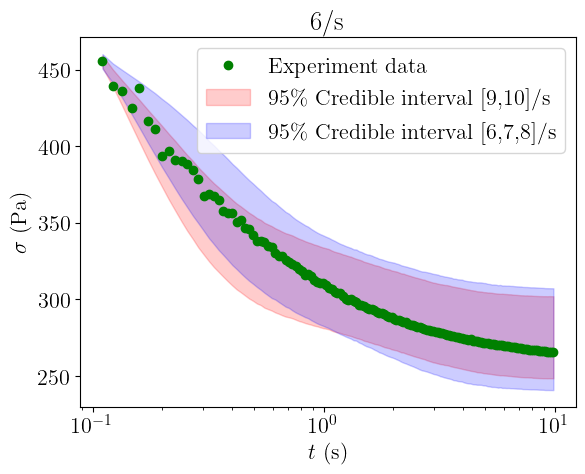

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


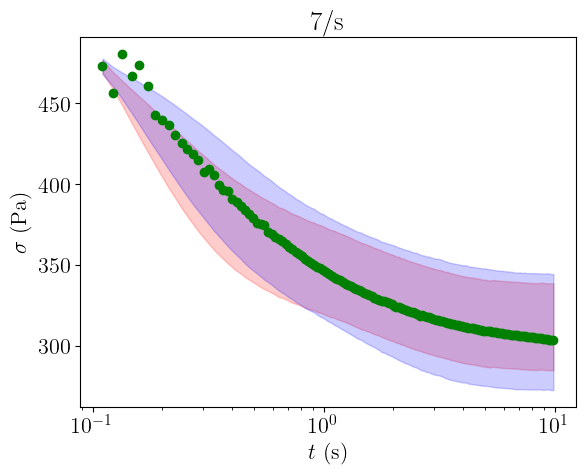

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


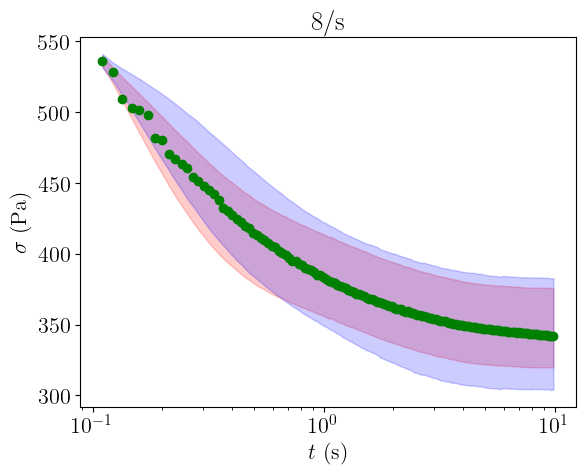

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


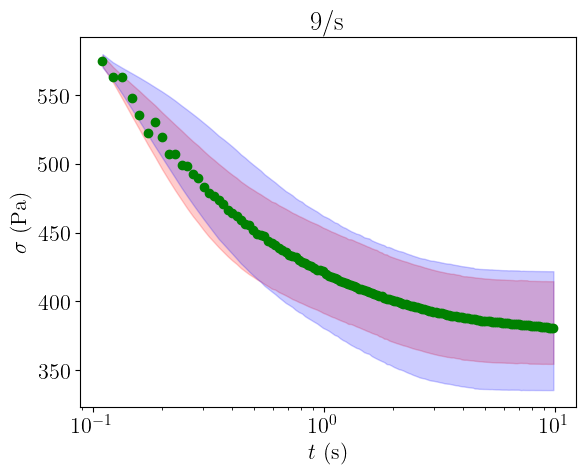

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


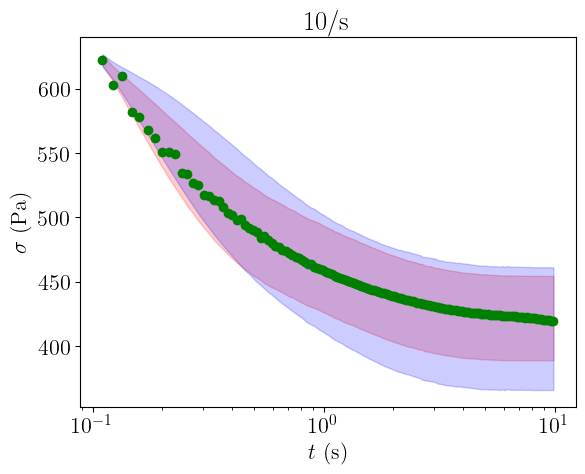

In [54]:
# Using dimensional time and dimensional IC to get dimensional shear stress
ic_count = 5
for arg in range(0,5): #9
    #if arg==1 or arg==3 or arg==5:
    #if arg==5:
    #    continue
    ic_count = ic_count + 1
    #arg = 1 
    shear_stress_all_prediction = np.zeros((num_samples*act_samples,148))
    shear_stress_all_prediction_3 = np.zeros((num_samples*act_samples,148))
    shear_rate_ode = shear_rate_all[arg]
    y0 = y0_all[arg]
    lambda_0 = lambda_true[arg]

    stress_analytical_pinn = shear_stress_analytical((G_true-G_min)/(G_max-G_min),(eta_s_true-eta_s_min)/(eta_s_max-eta_s_min),\
                                                 (k_p_true-k_p_min)/(k_p_max-k_p_min),(k_n_true-k_n_min)/(k_n_max-k_n_min),\
                                                 (sigma_y_true-sigma_y_min)/(sigma_y_max-sigma_y_min),(eta_p_true-eta_p_min)/(eta_p_max-eta_p_min),\
                                                 shear_rate_ode,y0,lambda_0,times)
    shear_stress_expt = shear_stress_global[:,arg+4]

    plt.plot(times,shear_stress_expt,'og', label='Experiment data')
    #plt.plot(times,stress_analytical_pinn,'-k', label='PINN analytical solution',linewidth=3)
    #model_error = np.zeros(np.size(times))
    for row_idx_1 in range(0,num_samples): 
        for row_idx_2 in range(0,act_samples):
            theta_3 = model_params_all_3[row_idx_2+row_idx_1*act_samples,:]
            shear_stress_an_3 = shear_stress_analytical(theta_3[0],theta_3[1],theta_3[2],theta_3[3],theta_3[4],theta_3[5],shear_rate_ode,y0,theta_3[ic_count],times)
            shear_stress_all_prediction_3[row_idx_2+row_idx_1*act_samples,:] = shear_stress_an_3 + noise_params_3[row_idx_2+row_idx_1*act_samples,0] 

            theta = model_params_all[row_idx_2+row_idx_1*act_samples,:]
            shear_stress_an = shear_stress_analytical(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],shear_rate_ode,y0,theta[ic_count],times)
            shear_stress_all_prediction[row_idx_2+row_idx_1*act_samples,:] = shear_stress_an + noise_params[row_idx_2+row_idx_1*act_samples,0]
    
    #plt.plot(times,shear_stress_an,'-g',alpha=0.5)
    #plt.plot(np.NaN,np.NaN,'-g',alpha=0.1,label='Posterior Samples')
    #print(np.shape(shear_stress_all_prediction))
    stress_low = np.zeros(np.size(times))
    stress_high = np.zeros(np.size(times))
    
    stress_low_3 = np.zeros(np.size(times))
    stress_high_3 = np.zeros(np.size(times))
    
    stress_mean = np.zeros(np.size(times))
    #stress_mean = np.mean(shear_stress_all_prediction,axis=0)
    for itr in range(0,np.size(times)):
        stress_low_3[itr] = az.hdi(shear_stress_all_prediction_3[:,itr],0.95)[0]
        stress_high_3[itr] = az.hdi(shear_stress_all_prediction_3[:,itr],0.95)[1]

        stress_low[itr] = az.hdi(shear_stress_all_prediction[:,itr],0.95)[0]
        stress_high[itr] = az.hdi(shear_stress_all_prediction[:,itr],0.95)[1]
    plt.fill_between(times,stress_low_3,stress_high_3,color='r',alpha=0.2,label=r'95\% Credible interval [9,10]/s')
    plt.fill_between(times,stress_low,stress_high,color='b',alpha=0.2,label=r'95\% Credible interval [6,7,8]/s')
    #stress_mean = (stress_low + stress_high)/2
    #plt.plot(times,stress_mean,'-r', label='Prediction mean',linewidth=3)
    #plt.title(r'$3$/s')
    #plt.title('%d/s',arg+2)
    plt.title(r'%d/s' % (arg+6))
    plt.xlabel(r'$t$ (s)')
    plt.ylabel(r'$\sigma$ (Pa)')
    plt.xscale('log')
    if arg==0:
        plt.legend()
    plt.savefig(r'TEVP_%ds_910.png' % (arg+2),format='png',bbox_inches='tight')
    plt.savefig(r'TEVP_%ds_910.eps' % (arg+2),format='eps',bbox_inches='tight')
    plt.show()



The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


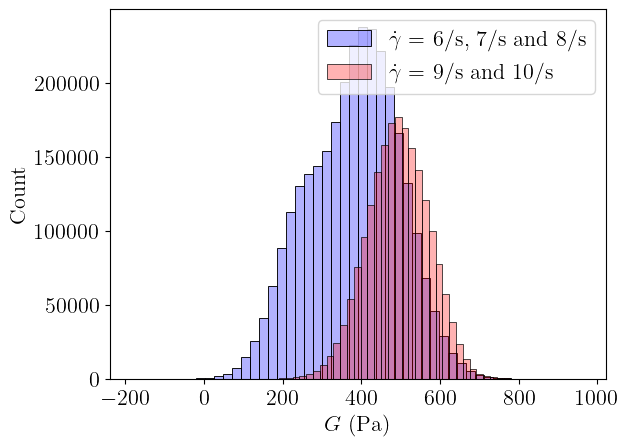

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


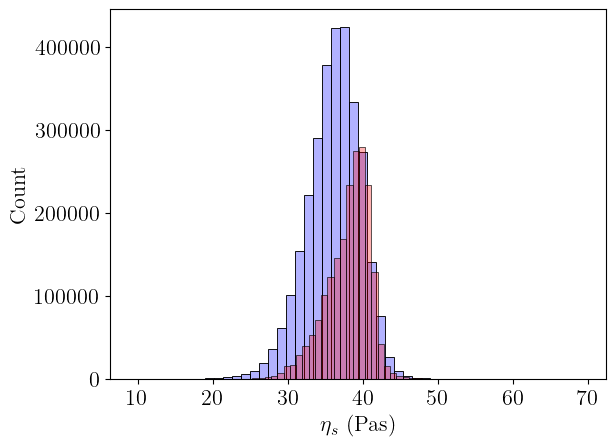

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


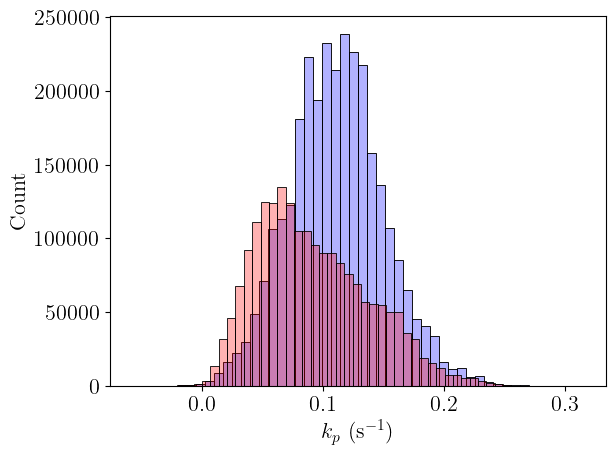

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


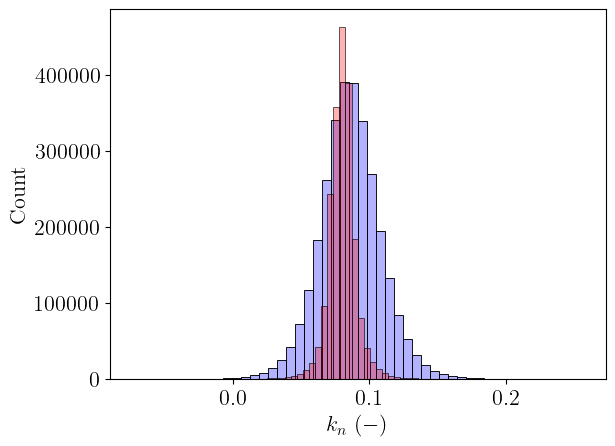

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


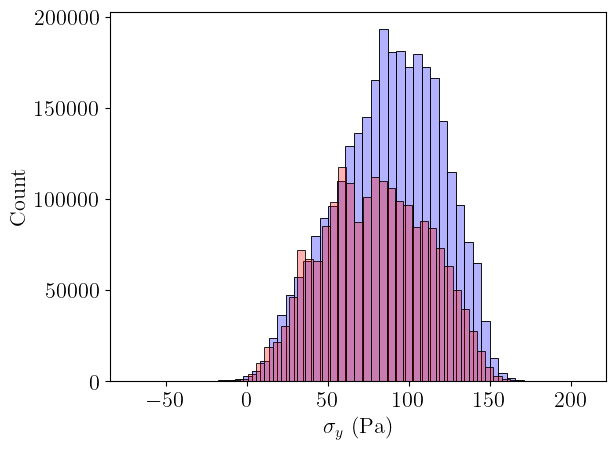

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


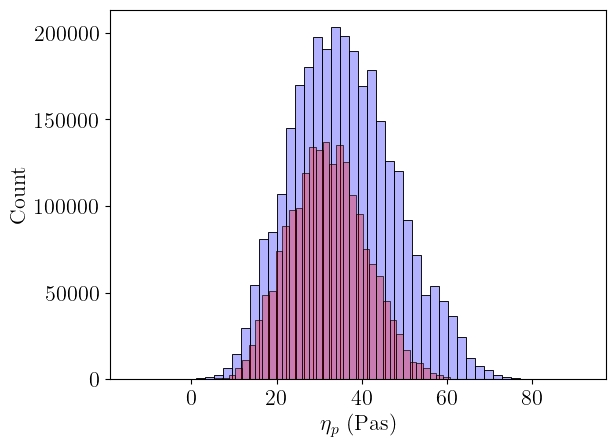

In [71]:
# Comparing model parameter distribution with PINN value #

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
sns.set_style(None)

G_low = az.hdi(model_params_all_3[:,0],0.95)[0]*(G_max-G_min) + G_min
G_high = az.hdi(model_params_all_3[:,0],0.95)[1]*(G_max-G_min) + G_min

eta_s_low = az.hdi(model_params_all_3[:,1],0.95)[0]*(eta_s_max-eta_s_min) + eta_s_min
eta_s_high = az.hdi(model_params_all_3[:,1],0.95)[1]*(eta_s_max-eta_s_min) + eta_s_min

k_p_low = az.hdi(model_params_all_3[:,2],0.95)[0]*(k_p_max-k_p_min) + k_p_min
k_p_high = az.hdi(model_params_all_3[:,2],0.95)[1]*(k_p_max-k_p_min) + k_p_min

k_n_low = az.hdi(model_params_all_3[:,3],0.95)[0]*(k_n_max-k_n_min) + k_n_min
k_n_high = az.hdi(model_params_all_3[:,3],0.95)[1]*(k_n_max-k_n_min) + k_n_min

sigma_y_low = az.hdi(model_params_all_3[:,4],0.95)[0]*(sigma_y_max-sigma_y_min) + sigma_y_min 
sigma_y_high = az.hdi(model_params_all_3[:,4],0.95)[1]*(sigma_y_max-sigma_y_min) + sigma_y_min

eta_p_low = az.hdi(model_params_all_3[:,5],0.95)[0]*(eta_p_max-eta_p_min) + eta_p_min
eta_p_high = az.hdi(model_params_all_3[:,5],0.95)[1]*(eta_p_max-eta_p_min) + eta_p_min


ax=plt.gca()
# ax.plot([G_true],[500.0],'o',color='k',markeredgewidth=4,label='PINN')
# ax.plot([G_low, G_high],[500.0, 500.0],'^',color='b',markeredgewidth=4, label='95\% Credible interval')
#ax.plot([np.mean(model_params_all[:,0])*(G_max-G_min)+G_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all[:,0]*(G_max-G_min) + G_min,fill=True,color='b',bins=50,alpha=0.3,ax=ax,label=r'$\dot\gamma$ = 6/s, 7/s and 8/s')
sns.histplot(model_params_all_3[:,0]*(G_max-G_min) + G_min,fill=True,color='r',bins=50,alpha=0.3,ax=ax,label=r'$\dot\gamma$ = 9/s and 10/s')
plt.xlabel(r"$G~\rm{(Pa)}$")
plt.legend()
plt.savefig('compare_TEVP_G_910.png',format='png',bbox_inches='tight')
plt.savefig('compare_TEVP_G_910.eps',format='eps',bbox_inches='tight')
plt.show()

ax = plt.gca()
# ax.plot([eta_s_true],[500.0],'o',color='k',markeredgewidth=4)
# ax.plot([eta_s_low, eta_s_high],[500.0, 500.0],'^',color='b',markeredgewidth=4)
#ax.plot([np.mean(model_params_all[:,1])*(eta_s_max-eta_s_min)+eta_s_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all[:,1]*(eta_s_max-eta_s_min) + eta_s_min,fill=True,color='b',bins=50,alpha=0.3,ax=ax)
sns.histplot(model_params_all_3[:,1]*(eta_s_max-eta_s_min) + eta_s_min,fill=True,color='r',bins=50,alpha=0.3,ax=ax)
plt.xlabel(r"$\eta_s~\rm{(Pa s)}$")
plt.savefig('compare_TEVP_eta_s_910.png',format='png',bbox_inches='tight')
plt.savefig('compare_TEVP_eta_s_910.eps',format='eps',bbox_inches='tight')
plt.show()

ax = plt.gca()
# ax.plot([k_p_true],[500.0],'o',color='k',markeredgewidth=4)
# ax.plot([k_p_low, k_p_high],[500.0, 500.0],'^',color='b',markeredgewidth=4)
#ax.plot([np.mean(model_params_all[:,2])*(k_p_max-k_p_min)+k_p_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all[:,2]*(k_p_max-k_p_min) + k_p_min,fill=True,color='b',bins=50,alpha=0.3,ax=ax)
sns.histplot(model_params_all_3[:,2]*(k_p_max-k_p_min) + k_p_min,fill=True,color='r',bins=50,alpha=0.3,ax=ax)
plt.xlabel(r"$k_p~\rm{(s^{-1})}$")
plt.savefig('compare_TEVP_k_p_910.png',format='png',bbox_inches='tight')
plt.savefig('compare_TEVP_k_p_910.eps',format='eps',bbox_inches='tight')
plt.show()

ax = plt.gca()
# ax.plot([k_n_true],[500.0],'o',color='k',markeredgewidth=4)
# ax.plot([k_n_low, k_n_high],[500.0, 500.0],'^',color='b',markeredgewidth=4)
#ax.plot([np.mean(model_params_all[:,3])*(k_n_max-k_n_min)+k_n_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all[:,3]*(k_n_max-k_n_min) + k_n_min,fill=True,color='b',bins=50,alpha=0.3,ax=ax)
sns.histplot(model_params_all_3[:,3]*(k_n_max-k_n_min) + k_n_min,fill=True,color='r',bins=50,alpha=0.3,ax=ax)
plt.xlabel(r"$k_n~\rm{(-)}$")
plt.savefig('compare_TEVP_k_n_910.png',format='png',bbox_inches='tight')
plt.savefig('compare_TEVP_k_n_910.eps',format='eps',bbox_inches='tight')
plt.show()

ax = plt.gca()
# ax.plot([sigma_y_true],[500.0],'o',color='k',markeredgewidth=4)
# ax.plot([sigma_y_low, sigma_y_high],[500.0, 500.0],'^',color='b',markeredgewidth=4)
#ax.plot([np.mean(model_params_all[:,4])*(sigma_y_max-sigma_y_min)+sigma_y_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all[:,4]*(sigma_y_max-sigma_y_min) + sigma_y_min,fill=True,color='b',bins=50,alpha=0.3,ax=ax)
sns.histplot(model_params_all_3[:,4]*(sigma_y_max-sigma_y_min) + sigma_y_min,fill=True,color='r',bins=50,alpha=0.3,ax=ax)
plt.xlabel(r"$\sigma_y~\rm{(Pa)}$")
plt.savefig('compare_TEVP_sigma_y_910.png',format='png',bbox_inches='tight')
plt.savefig('compare_TEVP_sigma_y_910.eps',format='eps',bbox_inches='tight')
plt.show()

ax = plt.gca()
# ax.plot([eta_p_true],[500.0],'o',color='k',markeredgewidth=4)
# ax.plot([eta_p_low, eta_p_high],[500.0, 500.0],'^',color='b',markeredgewidth=4)
#ax.plot([np.mean(model_params_all[:,5])*(eta_p_max-eta_p_min)+eta_p_min],[500.0],'s',color='r',markeredgewidth=4)
sns.histplot(model_params_all[:,5]*(eta_p_max-eta_p_min) + eta_p_min,fill=True,color='b',bins=50,alpha=0.3,ax=ax)
sns.histplot(model_params_all_3[:,5]*(eta_p_max-eta_p_min) + eta_p_min,fill=True,color='r',bins=50,alpha=0.3,ax=ax)
plt.xlabel(r"$\eta_p~\rm{(Pa s)}$")
plt.savefig('compare_TEVP_eta_p_910.png',format='png',bbox_inches='tight')
plt.savefig('compare_TEVP_eta_p_910.eps',format='eps',bbox_inches='tight')
plt.show()



## Training data: 8, 9 and 10/s ##

In [35]:
## Data processing ##

y0_train = [536.06,574.96,622.1]
shear_rate_train = [8.0,9.0,10.0]

shear_stress_training_4 = np.zeros(444,)
shear_stress_training_4[0:148] = shear_stress_global[:,6]  
shear_stress_training_4[148:296] = shear_stress_global[:,7]  
shear_stress_training_4[296:444] = shear_stress_global[:,8]    

print(np.shape(shear_stress_training_4)) # contains data for 8/s, 9/s and 10/s

times_1d = np.append(times,times)
times_1d = np.append(times_1d,times)
times_1d = times_1d.reshape(-1)
print(np.shape(times_1d))

shear_rate_8_idx = 0*np.ones(148)
shear_rate_9_idx = 1*np.ones(148)
shear_rate_10_idx = 2*np.ones(148)
shear_rate_idx = np.append(shear_rate_8_idx,shear_rate_9_idx)
shear_rate_idx = np.append(shear_rate_idx,shear_rate_10_idx)
shear_rate_idx = shear_rate_idx.reshape(-1)
shear_rate_idx = np.asarray(shear_rate_idx,dtype='int')
print(np.shape(shear_rate_idx))

shear_rate_8 = 8.0*np.ones(148)
shear_rate_9 = 9.0*np.ones(148)
shear_rate_10 = 10.0*np.ones(148)
shear_rate_1d = np.append(shear_rate_8,shear_rate_9)
shear_rate_1d = np.append(shear_rate_1d,shear_rate_10)
shear_rate_1d = shear_rate_1d.reshape(-1)
print(np.shape(shear_rate_1d))

stress_ic_8 = y0_all[2]*np.ones(148)
stress_ic_9 = y0_all[3]*np.ones(148)
stress_ic_10 = y0_all[4]*np.ones(148)
stress_ic_1d = np.append(stress_ic_8,stress_ic_9) 
stress_ic_1d = np.append(stress_ic_1d,stress_ic_10) 
stress_ic_1d = stress_ic_1d.reshape(-1)
print(np.shape(stress_ic_1d))


(444,)
(444,)
(444,)
(444,)
(444,)


In [36]:
#coords = {"time_coord": times, "shear_rate_coord": shear_rate_all}
coords = {"shear_rate_coord": shear_rate_train}

In [37]:
## Defining the UQ model ##
with pm.Model(coords=coords) as model_8910:
    time_data = pm.ConstantData("time_data", times_1d, dims="obs_id")
    shear_rate_data = pm.ConstantData("shear_rate_data", shear_rate_train, dims="shear_rate_coord")
    print(pm.draw(time_data).size)
    
    mu_g = pm.Beta("mu_g",alpha=2.0,beta=2.0) 
    #mu_g = pm.Normal("mu_g",mu=0.0,sigma=1.0)
    sigma_g = pm.HalfNormal("sigma_g",sigma=0.05) #0.01
    
    mu_eta_s = pm.Beta("mu_eta_s",alpha=2.0,beta=2.0)
    #mu_eta_s = pm.Normal("mu_eta_s",mu=0.0,sigma=1.0)
    sigma_eta_s = pm.HalfNormal("sigma_eta_s",sigma=0.05)

    mu_k_p = pm.Beta("mu_k_p",alpha=2.0,beta=2.0)
    #mu_k_p = pm.Normal("mu_k_p",mu=0.0,sigma=1.0)
    sigma_k_p = pm.HalfNormal("sigma_k_p",sigma=0.05)

    mu_k_n = pm.Beta("mu_k_n",alpha=2.0,beta=2.0)
    #mu_k_n = pm.Normal("mu_k_n",mu=0.0,sigma=1.0)
    sigma_k_n = pm.HalfNormal("sigma_k_n",sigma=0.05)
    
    mu_sigma_y = pm.Beta("mu_sigma_y",alpha=2.0,beta=2.0)
    #mu_sigma_y = pm.Normal("mu_sigma_y",mu=0.0,sigma=1.0)
    sigma_sigma_y = pm.HalfNormal("sigma_sigma_y",sigma=0.05)

    mu_eta_p = pm.Beta("mu_eta_p",alpha=2.0,beta=2.0)
    #mu_eta_p = pm.Normal("mu_eta_p",mu=0.0,sigma=1.0)
    sigma_eta_p = pm.HalfNormal("sigma_eta_p",sigma=0.05)
    
    ## Priors: dimensional unknown model parameters using non-centered paramterization ##
    z_G = pm.Normal("z_G",mu=0,sigma=1,dims="shear_rate_coord")
    G = pm.Deterministic("G", mu_g+sigma_g*z_G, dims="shear_rate_coord")
    #G = pm.Deterministic("G", np.exp(mu_g+sigma_g*z_G), dims="shear_rate_coord")
    G_dd = pm.Deterministic("G_dd", G*(G_max-G_min)+G_min, dims="shear_rate_coord")
    
    z_eta_s = pm.Normal("z_eta_s",mu=0,sigma=1,dims="shear_rate_coord")
    eta_s = pm.Deterministic("eta_s", mu_eta_s + sigma_eta_s*z_eta_s, dims="shear_rate_coord")
    eta_s_dd = pm.Deterministic("eta_s_dd", eta_s*(eta_s_max-eta_s_min)+eta_s_min, dims="shear_rate_coord")

    z_k_p = pm.Normal("z_k_p",mu=0,sigma=1,dims="shear_rate_coord")
    k_p = pm.Deterministic("k_p", mu_k_p + sigma_k_p*z_k_p, dims="shear_rate_coord")
    k_p_dd = pm.Deterministic("k_p_dd", k_p*(k_p_max-k_p_min)+k_p_min, dims="shear_rate_coord")

    z_k_n = pm.Normal("z_k_n",mu=0,sigma=1,dims="shear_rate_coord")
    k_n = pm.Deterministic("k_n", mu_k_n + sigma_k_n*z_k_n, dims="shear_rate_coord")
    k_n_dd = pm.Deterministic("k_n_dd", k_n*(k_n_max-k_n_min)+k_n_min, dims="shear_rate_coord")
    
    z_sigma_y = pm.Normal("z_sigma_y",mu=0,sigma=1,dims="shear_rate_coord")
    sigma_y = pm.Deterministic("sigma_y", mu_sigma_y + sigma_sigma_y*z_sigma_y, dims="shear_rate_coord")
    sigma_y_dd = pm.Deterministic("sigma_y_dd", sigma_y*(sigma_y_max-sigma_y_min)+sigma_y_min, dims="shear_rate_coord")

    z_eta_p = pm.Normal("z_eta_p",mu=0,sigma=1,dims="shear_rate_coord")
    eta_p = pm.Deterministic("eta_p", mu_eta_p + sigma_eta_p*z_eta_p, dims="shear_rate_coord")
    eta_p_dd = pm.Deterministic("eta_p_dd", eta_p*(eta_p_max-eta_p_min)+eta_p_min, dims="shear_rate_coord")

    lambda_a = pm.Beta("lambda_a", alpha=2.0, beta=5.0) #, dims="shear_rate_coord")
    lambda_b = pm.Beta("lambda_b",alpha=2.0, beta=5.0) #, dims="shear_rate_coord")
    lambda_ic = pm.Deterministic("lambda_ic",lambda_a*np.exp(-lambda_b*(shear_rate_data)), dims="shear_rate_coord")
    
    T_dd = pm.Deterministic("T_dd", (k_p_dd + k_n_dd*shear_rate_data)/(G_dd/(eta_s_dd+eta_p_dd)), dims="shear_rate_coord")
    R_dd = pm.Deterministic("R_dd", k_p_dd/(k_p_dd + k_n_dd*shear_rate_data), dims="shear_rate_coord")
    
    ## Experiment measurement uncertainty ##
    sigma = pm.Exponential("sigma", 2.0) # rate parameter = 5.0  2.0

    shear_stress_mean = eta_s_dd[shear_rate_idx]*shear_rate_1d + (sigma_y_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx]*shear_rate_1d)*R_dd[shear_rate_idx] + \
               (stress_ic_1d  - eta_s_dd[shear_rate_idx]*shear_rate_1d + (sigma_y_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx]*shear_rate_1d)*((lambda_ic[shear_rate_idx]-R_dd[shear_rate_idx]*T_dd[shear_rate_idx])/(T_dd[shear_rate_idx]-1)))*np.exp(-G_dd[shear_rate_idx]*(time_data-0.11)/(eta_s_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx])) + \
               (sigma_y_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx]*shear_rate_1d)*((R_dd[shear_rate_idx]-lambda_ic[shear_rate_idx])/(T_dd[shear_rate_idx]-1))*np.exp(-(k_p_dd[shear_rate_idx]+k_n_dd[shear_rate_idx]*shear_rate_1d)*(time_data-0.11))
    

    ## Likelihood ##
    pm.Normal("Y_obs", mu=shear_stress_mean, sigma=sigma, observed=shear_stress_training_4, dims = "obs_id") 
    idata_8910 = pm.sample_prior_predictive(samples=10000, random_seed=rng)

print(idata_8910)

444


Sampling: [Y_obs, lambda_a, lambda_b, mu_eta_p, mu_eta_s, mu_g, mu_k_n, mu_k_p, mu_sigma_y, sigma, sigma_eta_p, sigma_eta_s, sigma_g, sigma_k_n, sigma_k_p, sigma_sigma_y, z_G, z_eta_p, z_eta_s, z_k_n, z_k_p, z_sigma_y]


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data


In [38]:
tune = 2000 #2000
draws = 10000 #50000 
with model_8910:
    idata_8910.extend(pm.sample(tune=tune, draws=draws, target_accept=0.85, random_seed=rng, discard_tuned_samples=True))
print(idata_8910)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_g, sigma_g, mu_eta_s, sigma_eta_s, mu_k_p, sigma_k_p, mu_k_n, sigma_k_n, mu_sigma_y, sigma_sigma_y, mu_eta_p, sigma_eta_p, z_G, z_eta_s, z_k_p, z_k_n, z_sigma_y, z_eta_p, lambda_a, lambda_b, sigma]


Sampling 4 chains for 2_000 tune and 10_000 draw iterations (8_000 + 40_000 draws total) took 7889 seconds.
There were 1043 divergences after tuning. Increase `target_accept` or reparameterize.


Inference data with groups:
	> posterior
	> sample_stats
	> prior
	> prior_predictive
	> observed_data
	> constant_data


In [39]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm" 

num_samples = 1000 #1000 # Hyper-prior samples 1000
thin_every = 40 #100
itr_samples = num_samples*thin_every
no_samples = itr_samples*len(shear_rate_train) # New normal model samples 1000
act_samples = no_samples/thin_every
act_samples = int(act_samples)
print(act_samples)
model_params_all_4 = np.zeros((num_samples*act_samples,11)) 
noise_params_4 = np.zeros((num_samples*act_samples,1)) 

# extracting normalized model parameters from posterior distribution #
imdata_pred_8910 = az.extract(idata_8910, group = "posterior", num_samples=itr_samples).to_dataframe() #itr_samples
print(np.shape(imdata_pred_8910))
# Hyperpriors are same across all shear rates #
mean_cols = ["mu_g", "mu_eta_s", "mu_k_p", "mu_k_n", "mu_sigma_y", "mu_eta_p"]
sigma_cols = ["sigma_g", "sigma_eta_s", "sigma_k_p", "sigma_k_n", "sigma_sigma_y", "sigma_eta_p"]
std_cols = ["z_G", "z_eta_s", "z_k_p", "z_k_n", "z_sigma_y", "z_eta_p"]
lambda_cols = ["lambda_a","lambda_b"]
noise_cols = ["sigma"]

count = -1
for row_idx_1 in range(0,itr_samples,thin_every): 
    count = count + 1
    mean_row = imdata_pred_8910.iloc[row_idx_1, :][mean_cols].values
    sigma_row = imdata_pred_8910.iloc[row_idx_1, :][sigma_cols].values
    lambda_row = imdata_pred_8910.iloc[row_idx_1, :][lambda_cols].values
    noise_row = imdata_pred_8910.iloc[row_idx_1, :][noise_cols].values
    noise_dist = st.norm(0,noise_row)

    count_1 = -1
    for row_idx_2 in range(0,no_samples,thin_every):
        count_1 = count_1 + 1
        z_row = imdata_pred_8910.iloc[row_idx_2, :][std_cols].values
        
        G_predicted = mean_row[0]+sigma_row[0]*z_row[0]
        eta_s_predicted = mean_row[1]+sigma_row[1]*z_row[1]
        k_p_predicted = mean_row[2]+sigma_row[2]*z_row[2]
        k_n_predicted = mean_row[3]+sigma_row[3]*z_row[3]
        sigma_y_predicted = mean_row[4]+sigma_row[4]*z_row[4]
        eta_p_predicted = mean_row[5]+sigma_row[5]*z_row[5]
        
        lambda_ic_6 = lambda_row[0]*np.exp(-lambda_row[1]*(6))
        lambda_ic_7 = lambda_row[0]*np.exp(-lambda_row[1]*(7))
        lambda_ic_8 = lambda_row[0]*np.exp(-lambda_row[1]*(8))
        lambda_ic_9 = lambda_row[0]*np.exp(-lambda_row[1]*(9))
        lambda_ic_10 = lambda_row[0]*np.exp(-lambda_row[1]*(10))
        
        model_params_all_4[count_1+(count)*act_samples,0] = G_predicted
        model_params_all_4[count_1+(count)*act_samples,1] = eta_s_predicted
        model_params_all_4[count_1+(count)*act_samples,2] = k_p_predicted
        model_params_all_4[count_1+(count)*act_samples,3] = k_n_predicted
        model_params_all_4[count_1+(count)*act_samples,4] = sigma_y_predicted
        model_params_all_4[count_1+(count)*act_samples,5] = eta_p_predicted
        
        model_params_all_4[count_1+(count)*act_samples,6] = lambda_ic_6
        model_params_all_4[count_1+(count)*act_samples,7] = lambda_ic_7
        model_params_all_4[count_1+(count)*act_samples,8] = lambda_ic_8
        model_params_all_4[count_1+(count)*act_samples,9] = lambda_ic_9
        model_params_all_4[count_1+(count)*act_samples,10] = lambda_ic_10

        noise_params_4[count_1+(count)*act_samples,0] = noise_dist.rvs(size=1)
        
print(np.shape(model_params_all_4))
print(np.shape(noise_params_4))


3000
(120000, 38)
(3000000, 11)
(3000000, 1)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


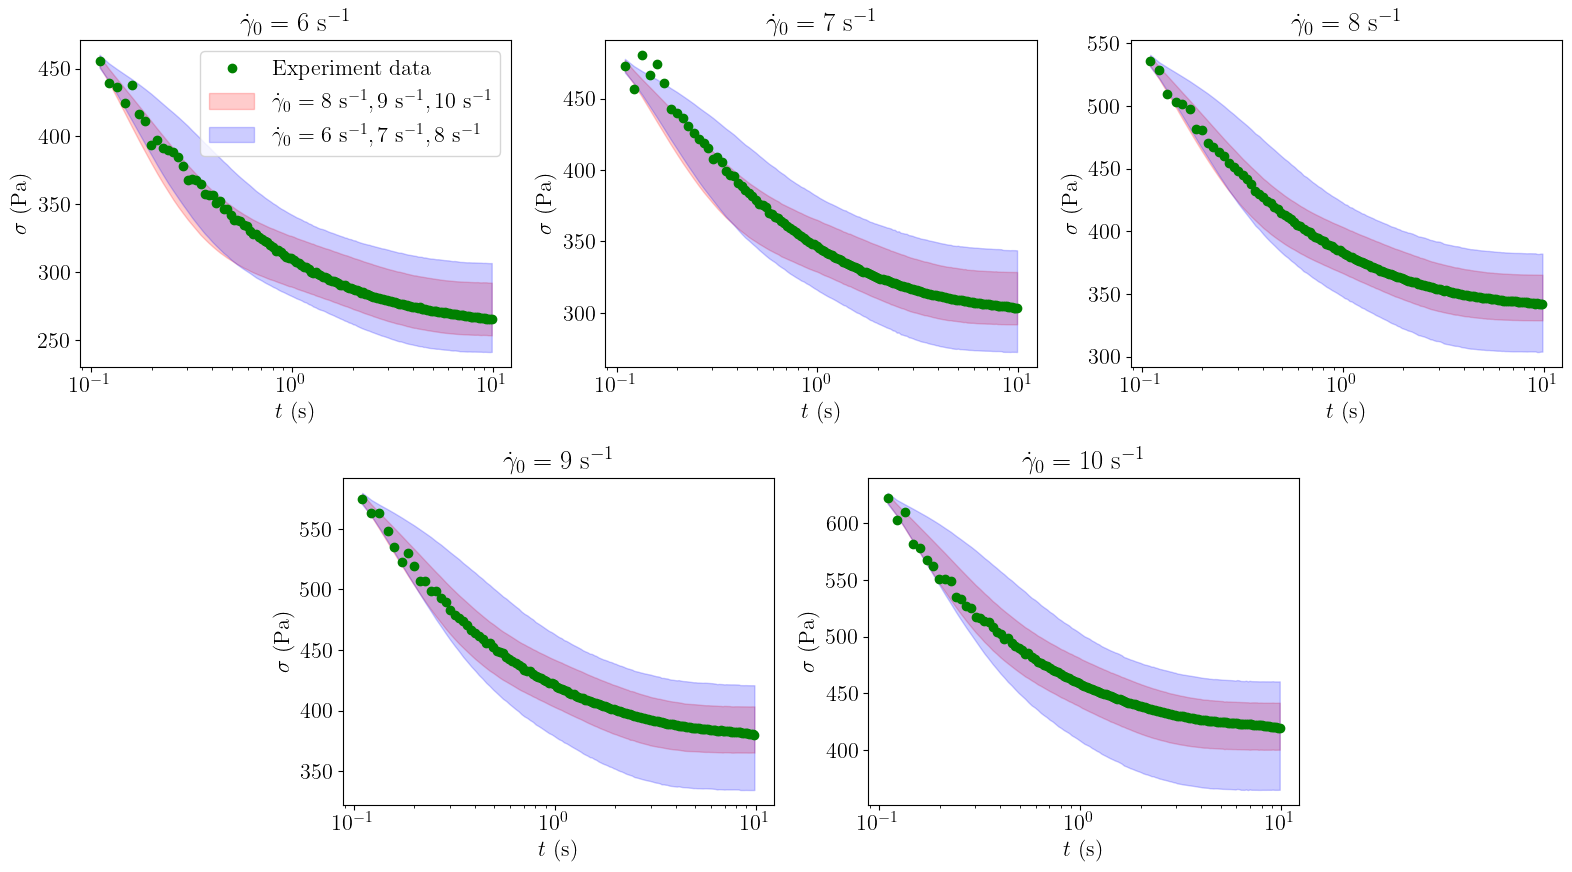

In [40]:
# Using dimensional time and dimensional IC to get dimensional shear stress
import matplotlib as mpl
ic_count = 5
#figs, ax = plt.subplots(2,3,figsize=(16,9),constrained_layout=True)
fig = plt.figure(figsize=(16,9))
spec = mpl.gridspec.GridSpec(ncols=6,nrows=2)
ax1 = fig.add_subplot(spec[0,0:2])
ax2 = fig.add_subplot(spec[0,2:4])
ax3 = fig.add_subplot(spec[0,4:])
ax4 = fig.add_subplot(spec[1,1:3])
ax5 = fig.add_subplot(spec[1,3:5])

for arg in range(0,5): #9
    ic_count = ic_count + 1
    shear_stress_all_prediction = np.zeros((num_samples*act_samples,148))
    shear_stress_all_prediction_4 = np.zeros((num_samples*act_samples,148))
    shear_rate_ode = shear_rate_all[arg]
    y0 = y0_all[arg]
    lambda_0 = lambda_true[arg]

    shear_stress_expt = shear_stress_global[:,arg+4]
    
    if arg==0:
        ax = ax1
        #plt.subplot(2,3,1)
    elif arg==1:
        ax = ax2
        #plt.subplot(2,3,2)
    elif arg==2:
        ax = ax3
        #plt.subplot(2,3,3)
    elif arg==3:
        ax = ax4
        #plt.subplot(2,3,4)
    elif arg==4:
        ax = ax5
        #plt.subplot(2,3,5)
        
    ax.plot(times,shear_stress_expt,'og', label='Experiment data')

    for row_idx_1 in range(0,num_samples): 
        for row_idx_2 in range(0,act_samples):
            theta_4 = model_params_all_4[row_idx_2+row_idx_1*act_samples,:]
            shear_stress_an_4 = shear_stress_analytical(theta_4[0],theta_4[1],theta_4[2],theta_4[3],theta_4[4],theta_4[5],shear_rate_ode,y0,theta_4[ic_count],times)
            shear_stress_all_prediction_4[row_idx_2+row_idx_1*act_samples,:] = shear_stress_an_4 + noise_params_4[row_idx_2+row_idx_1*act_samples,0] 

            theta = model_params_all[row_idx_2+row_idx_1*act_samples,:]
            shear_stress_an = shear_stress_analytical(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],shear_rate_ode,y0,theta[ic_count],times)
            shear_stress_all_prediction[row_idx_2+row_idx_1*act_samples,:] = shear_stress_an + noise_params[row_idx_2+row_idx_1*act_samples,0]
    
    stress_low = np.zeros(np.size(times))
    stress_high = np.zeros(np.size(times))
    
    stress_low_4 = np.zeros(np.size(times))
    stress_high_4 = np.zeros(np.size(times))
    
    stress_mean = np.zeros(np.size(times))
    
    for itr in range(0,np.size(times)):
        stress_low_4[itr] = az.hdi(shear_stress_all_prediction_4[:,itr],0.95)[0]
        stress_high_4[itr] = az.hdi(shear_stress_all_prediction_4[:,itr],0.95)[1]

        stress_low[itr] = az.hdi(shear_stress_all_prediction[:,itr],0.95)[0]
        stress_high[itr] = az.hdi(shear_stress_all_prediction[:,itr],0.95)[1]
    ax.fill_between(times,stress_low_4,stress_high_4,color='r',alpha=0.2,label=r'$\dot\gamma_{0} = 8~\rm{s^{-1}}, 9~\rm{s^{-1}}, 10~\rm{s^{-1}}$')
    ax.fill_between(times,stress_low,stress_high,color='b',alpha=0.2,label=r'$\dot\gamma_{0} = 6~\rm{s^{-1}}, 7~\rm{s^{-1}}, 8~\rm{s^{-1}}$')
    ax.set_title(r'$\dot\gamma_0 = %d~\rm{s^{-1}}$' % (arg+6))
    ax.set_xlabel(r'$t$ (s)')
    ax.set_ylabel(r'$\sigma$ (Pa)')
    ax.set_xscale('log')
    if arg==0:
        ax.legend()
   
plt.tight_layout()
plt.savefig('TEVP_shear_stress_subplots_8910.eps',format='eps',bbox_inches='tight')
plt.savefig(r'TEVP_shear_stress_subplots_8910.pdf',format='pdf',bbox_inches='tight')
plt.savefig('TEVP_shear_stress_subplots_8910.png',format='png',bbox_inches='tight')
plt.show()


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


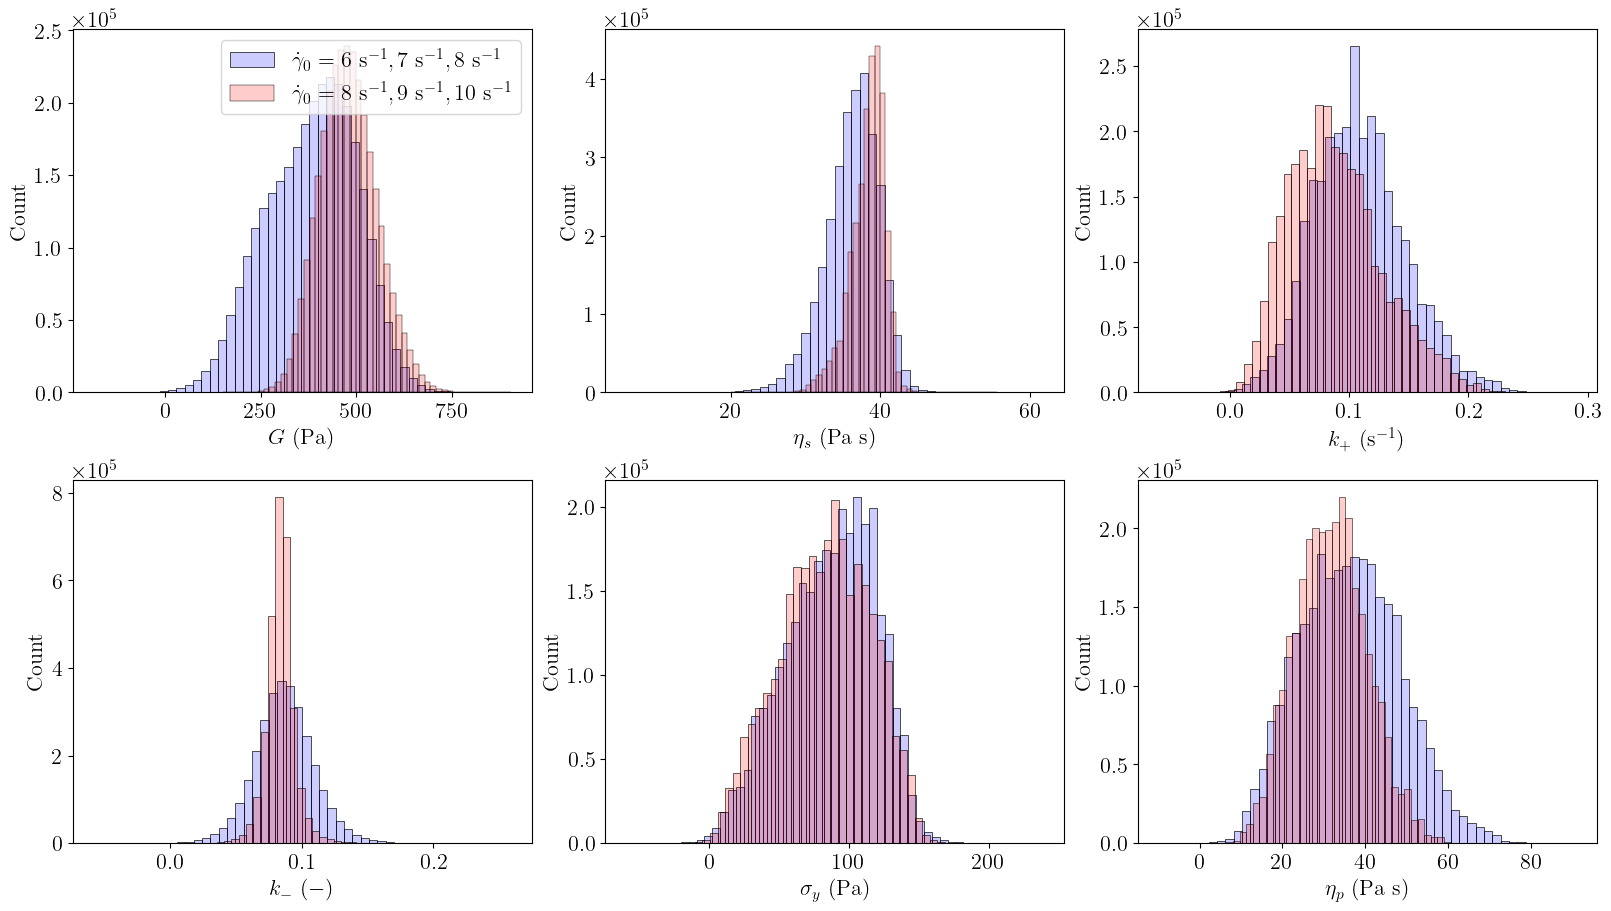

In [41]:
# Comparing model parameter distribution with PINN value #

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm"
sns.set_style(None)

G_low_4 = az.hdi(model_params_all_4[:,0],0.95)[0]*(G_max-G_min) + G_min
G_high_4 = az.hdi(model_params_all_4[:,0],0.95)[1]*(G_max-G_min) + G_min

eta_s_low_4 = az.hdi(model_params_all_4[:,1],0.95)[0]*(eta_s_max-eta_s_min) + eta_s_min
eta_s_high_4 = az.hdi(model_params_all_4[:,1],0.95)[1]*(eta_s_max-eta_s_min) + eta_s_min

k_p_low_4 = az.hdi(model_params_all_4[:,2],0.95)[0]*(k_p_max-k_p_min) + k_p_min
k_p_high_4 = az.hdi(model_params_all_4[:,2],0.95)[1]*(k_p_max-k_p_min) + k_p_min

k_n_low_4 = az.hdi(model_params_all_4[:,3],0.95)[0]*(k_n_max-k_n_min) + k_n_min
k_n_high_4 = az.hdi(model_params_all_4[:,3],0.95)[1]*(k_n_max-k_n_min) + k_n_min

sigma_y_low_4 = az.hdi(model_params_all_4[:,4],0.95)[0]*(sigma_y_max-sigma_y_min) + sigma_y_min 
sigma_y_high_4 = az.hdi(model_params_all_4[:,4],0.95)[1]*(sigma_y_max-sigma_y_min) + sigma_y_min

eta_p_low_4 = az.hdi(model_params_all_4[:,5],0.95)[0]*(eta_p_max-eta_p_min) + eta_p_min
eta_p_high_4 = az.hdi(model_params_all_4[:,5],0.95)[1]*(eta_p_max-eta_p_min) + eta_p_min

plt.subplots(2,3,figsize=(16,9),constrained_layout=True)
plt.subplot(2,3,1)
ax=plt.gca()
sns.histplot(model_params_all[:,0]*(G_max-G_min) + G_min,fill=True,color='b',bins=50,alpha=0.2,ax=ax,label=r'$\dot\gamma_{0} = 6~\rm{s^{-1}}, 7~\rm{s^{-1}}, 8~\rm{s^{-1}}$')
sns.histplot(model_params_all_4[:,0]*(G_max-G_min) + G_min,fill=True,color='r',bins=50,alpha=0.2,ax=ax,label=r'$\dot\gamma_{0} = 8~\rm{s^{-1}}, 9~\rm{s^{-1}}, 10~\rm{s^{-1}}$')
plt.xlabel(r"$G~\rm{(Pa)}$")
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))
plt.legend()

plt.subplot(2,3,2)
ax = plt.gca()
sns.histplot(model_params_all[:,1]*(eta_s_max-eta_s_min) + eta_s_min,fill=True,color='b',bins=50,alpha=0.2,ax=ax)
sns.histplot(model_params_all_4[:,1]*(eta_s_max-eta_s_min) + eta_s_min,fill=True,color='r',bins=50,alpha=0.2,ax=ax)
plt.xlabel(r"$\eta_s~\rm{(Pa~s)}$")
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.subplot(2,3,3)
ax = plt.gca()
sns.histplot(model_params_all[:,2]*(k_p_max-k_p_min) + k_p_min,fill=True,color='b',bins=50,alpha=0.2,ax=ax)
sns.histplot(model_params_all_4[:,2]*(k_p_max-k_p_min) + k_p_min,fill=True,color='r',bins=50,alpha=0.2,ax=ax)
plt.xlabel(r"$k_{+}~\rm{(s^{-1})}$")
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.subplot(2,3,4)
ax = plt.gca()
sns.histplot(model_params_all[:,3]*(k_n_max-k_n_min) + k_n_min,fill=True,color='b',bins=50,alpha=0.2,ax=ax)
sns.histplot(model_params_all_4[:,3]*(k_n_max-k_n_min) + k_n_min,fill=True,color='r',bins=50,alpha=0.2,ax=ax)
plt.xlabel(r"$k_{-}~\rm{(-)}$")
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.subplot(2,3,5)
ax = plt.gca()
sns.histplot(model_params_all[:,4]*(sigma_y_max-sigma_y_min) + sigma_y_min,fill=True,color='b',bins=50,alpha=0.2,ax=ax)
sns.histplot(model_params_all_4[:,4]*(sigma_y_max-sigma_y_min) + sigma_y_min,fill=True,color='r',bins=50,alpha=0.2,ax=ax)
plt.xlabel(r"$\sigma_y~\rm{(Pa)}$")
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.subplot(2,3,6)
ax = plt.gca()
sns.histplot(model_params_all[:,5]*(eta_p_max-eta_p_min) + eta_p_min,fill=True,color='b',bins=50,alpha=0.2,ax=ax)
sns.histplot(model_params_all_4[:,5]*(eta_p_max-eta_p_min) + eta_p_min,fill=True,color='r',bins=50,alpha=0.2,ax=ax)
plt.xlabel(r"$\eta_p~\rm{(Pa~s)}$")
plt.ticklabel_format(axis='y',style='sci',scilimits=(0,0))

plt.savefig('TEVP_model_params_subplots_8910.eps',format='eps',bbox_inches='tight')
plt.savefig(r'TEVP_model_params_subplots_8910.pdf',format='pdf',bbox_inches='tight')
plt.savefig('TEVP_model_params_subplots_8910.png',format='png',bbox_inches='tight')
plt.show()



In [42]:
y0_all = [243.28,305.51,400.7,422.7,455.37]
shear_rate_all = [2.0,3.0,4.0,5.0,6.0]

y0_train = [243.28,305.51,400.7]
shear_rate_train = [2.0,3.0,4.0]

lambda_true = [0.8205,0.5875,0.4312,0.3273,0.259,0.216,0.1844,0.1585,0.1373]

shear_stress_global = np.zeros((148,9))
for itr in range(1,10):
  df= pd.read_excel("DOWTC5622-09-02-22_DataUsedToTrainPINN.xlsx",header = None, names=['shear rate','t','shear stress'],sheet_name=itr, skiprows=range(148,296))
  Data = df.to_numpy()
  times = Data[:,1]
  shear_stress_local = Data[:,2]
  shear_stress_global[:,itr-1] = shear_stress_local

shear_stress_training = np.zeros(444,)
shear_stress_training[0:148] = shear_stress_global[:,0]      #2/s
shear_stress_training[148:296] = shear_stress_global[:,1]    
shear_stress_training[296:444] = shear_stress_global[:,2]

print(np.shape(shear_stress_training)) # contains data for 3/s, 4/s, 5/s and 6/s

times_1d = np.append(times,times)
times_1d = np.append(times_1d,times)
times_1d = times_1d.reshape(-1)
print(np.shape(times_1d))

shear_rate_2_idx = 0*np.ones(148)
shear_rate_3_idx = 1*np.ones(148)
shear_rate_4_idx = 2*np.ones(148)
shear_rate_idx = np.append(shear_rate_2_idx,shear_rate_3_idx)
shear_rate_idx = np.append(shear_rate_idx,shear_rate_4_idx)
shear_rate_idx = shear_rate_idx.reshape(-1)
shear_rate_idx = np.asarray(shear_rate_idx,dtype='int')
print(np.shape(shear_rate_idx))

shear_rate_2 = 2.0*np.ones(148)
shear_rate_3 = 3.0*np.ones(148)
shear_rate_4 = 4.0*np.ones(148)
shear_rate_1d = np.append(shear_rate_2,shear_rate_3) 
shear_rate_1d = np.append(shear_rate_1d,shear_rate_4)
shear_rate_1d = shear_rate_1d.reshape(-1)
print(np.shape(shear_rate_1d))

stress_ic_2 = y0_all[0]*np.ones(148)
stress_ic_3 = y0_all[1]*np.ones(148)
stress_ic_4 = y0_all[2]*np.ones(148)
stress_ic_1d = np.append(stress_ic_2,stress_ic_3) 
stress_ic_1d = np.append(stress_ic_1d,stress_ic_4)
stress_ic_1d = stress_ic_1d.reshape(-1)
print(np.shape(stress_ic_1d))

(444,)
(444,)
(444,)
(444,)
(444,)


In [43]:
#coords = {"time_coord": times, "shear_rate_coord": shear_rate_all}
coords = {"shear_rate_coord": shear_rate_train}

In [44]:
## Defining the UQ model ##
with pm.Model(coords=coords) as model_234:
    time_data = pm.ConstantData("time_data", times_1d, dims="obs_id")
    shear_rate_data = pm.ConstantData("shear_rate_data", shear_rate_train, dims="shear_rate_coord")
    print(pm.draw(time_data).size)
    
    mu_g = pm.Beta("mu_g",alpha=2.0,beta=2.0) 
    # mu_g = pm.Normal("mu_g",mu=0.0,sigma=1.0)
    sigma_g = pm.HalfNormal("sigma_g",sigma=0.05) #0.01
    
    mu_eta_s = pm.Beta("mu_eta_s",alpha=2.0,beta=2.0)
    sigma_eta_s = pm.HalfNormal("sigma_eta_s",sigma=0.05)

    mu_k_p = pm.Beta("mu_k_p",alpha=2.0,beta=2.0)
    sigma_k_p = pm.HalfNormal("sigma_k_p",sigma=0.05)

    mu_k_n = pm.Beta("mu_k_n",alpha=2.0,beta=2.0)
    sigma_k_n = pm.HalfNormal("sigma_k_n",sigma=0.05)
    
    mu_sigma_y = pm.Beta("mu_sigma_y",alpha=2.0,beta=2.0)
    sigma_sigma_y = pm.HalfNormal("sigma_sigma_y",sigma=0.05)

    mu_eta_p = pm.Beta("mu_eta_p",alpha=2.0,beta=2.0)
    sigma_eta_p = pm.HalfNormal("sigma_eta_p",sigma=0.05)
    
    ## Priors: dimensional unknown model parameters using non-centered paramterization ##
    z_G = pm.Normal("z_G",mu=0,sigma=1,dims="shear_rate_coord")
    G = pm.Deterministic("G", mu_g+sigma_g*z_G, dims="shear_rate_coord")
    # G = pm.Deterministic("G", np.exp(mu_g+sigma_g*z_G), dims="shear_rate_coord")
    G_dd = pm.Deterministic("G_dd", G*(G_max-G_min)+G_min, dims="shear_rate_coord")
    
    z_eta_s = pm.Normal("z_eta_s",mu=0,sigma=1,dims="shear_rate_coord")
    eta_s = pm.Deterministic("eta_s", mu_eta_s + sigma_eta_s*z_eta_s, dims="shear_rate_coord")
    eta_s_dd = pm.Deterministic("eta_s_dd", eta_s*(eta_s_max-eta_s_min)+eta_s_min, dims="shear_rate_coord")

    z_k_p = pm.Normal("z_k_p",mu=0,sigma=1,dims="shear_rate_coord")
    k_p = pm.Deterministic("k_p", mu_k_p + sigma_k_p*z_k_p, dims="shear_rate_coord")
    k_p_dd = pm.Deterministic("k_p_dd", k_p*(k_p_max-k_p_min)+k_p_min, dims="shear_rate_coord")

    z_k_n = pm.Normal("z_k_n",mu=0,sigma=1,dims="shear_rate_coord")
    k_n = pm.Deterministic("k_n", mu_k_n + sigma_k_n*z_k_n, dims="shear_rate_coord")
    k_n_dd = pm.Deterministic("k_n_dd", k_n*(k_n_max-k_n_min)+k_n_min, dims="shear_rate_coord")
    
    z_sigma_y = pm.Normal("z_sigma_y",mu=0,sigma=1,dims="shear_rate_coord")
    sigma_y = pm.Deterministic("sigma_y", mu_sigma_y + sigma_sigma_y*z_sigma_y, dims="shear_rate_coord")
    sigma_y_dd = pm.Deterministic("sigma_y_dd", sigma_y*(sigma_y_max-sigma_y_min)+sigma_y_min, dims="shear_rate_coord")

    z_eta_p = pm.Normal("z_eta_p",mu=0,sigma=1,dims="shear_rate_coord")
    eta_p = pm.Deterministic("eta_p", mu_eta_p + sigma_eta_p*z_eta_p, dims="shear_rate_coord")
    eta_p_dd = pm.Deterministic("eta_p_dd", eta_p*(eta_p_max-eta_p_min)+eta_p_min, dims="shear_rate_coord")

    lambda_a = pm.Beta("lambda_a", alpha=2.0, beta=5.0) #, dims="shear_rate_coord")
    lambda_b = pm.Beta("lambda_b",alpha=2.0, beta=5.0) #, dims="shear_rate_coord")
    lambda_ic = pm.Deterministic("lambda_ic",lambda_a*np.exp(-lambda_b*(shear_rate_data)), dims="shear_rate_coord")
    
    T_dd = pm.Deterministic("T_dd", (k_p_dd + k_n_dd*shear_rate_data)/(G_dd/(eta_s_dd+eta_p_dd)), dims="shear_rate_coord")
    R_dd = pm.Deterministic("R_dd", k_p_dd/(k_p_dd + k_n_dd*shear_rate_data), dims="shear_rate_coord")
    
    ## Experiment measurement uncertainty ##
    sigma = pm.Exponential("sigma", 2.0) 
    shear_stress_mean = eta_s_dd[shear_rate_idx]*shear_rate_1d + (sigma_y_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx]*shear_rate_1d)*R_dd[shear_rate_idx] + \
               (stress_ic_1d  - eta_s_dd[shear_rate_idx]*shear_rate_1d + (sigma_y_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx]*shear_rate_1d)*((lambda_ic[shear_rate_idx]-R_dd[shear_rate_idx]*T_dd[shear_rate_idx])/(T_dd[shear_rate_idx]-1)))*np.exp(-G_dd[shear_rate_idx]*(time_data-0.11)/(eta_s_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx])) + \
               (sigma_y_dd[shear_rate_idx]+eta_p_dd[shear_rate_idx]*shear_rate_1d)*((R_dd[shear_rate_idx]-lambda_ic[shear_rate_idx])/(T_dd[shear_rate_idx]-1))*np.exp(-(k_p_dd[shear_rate_idx]+k_n_dd[shear_rate_idx]*shear_rate_1d)*(time_data-0.11))

    ## Likelihood ##
    pm.Normal("Y_obs", mu=shear_stress_mean, sigma=sigma, observed=shear_stress_training, dims = "obs_id") 
    idata_234 = pm.sample_prior_predictive(samples=10000, random_seed=rng)

print(idata_234)

444


Sampling: [Y_obs, lambda_a, lambda_b, mu_eta_p, mu_eta_s, mu_g, mu_k_n, mu_k_p, mu_sigma_y, sigma, sigma_eta_p, sigma_eta_s, sigma_g, sigma_k_n, sigma_k_p, sigma_sigma_y, z_G, z_eta_p, z_eta_s, z_k_n, z_k_p, z_sigma_y]


Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data


In [45]:
# sampler = "NUTS PyMC ODE"
tune = 2000 #2000
draws = 10000 #50000 
with model:
    idata_234.extend(pm.sample(tune=tune, draws=draws, target_accept=0.85, random_seed=rng, discard_tuned_samples=True))
print(idata_234)

NameError: name 'model' is not defined

In [ ]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "cm" 

num_samples = 1000 #1000 # Hyper-prior samples 1000
thin_every = 40 #100
itr_samples = num_samples*thin_every
no_samples = itr_samples*len(shear_rate_train) # New normal model samples 1000
act_samples = no_samples/thin_every
act_samples = int(act_samples)
print(act_samples)
model_params_all_5 = np.zeros((num_samples*act_samples,11)) 
noise_params_5 = np.zeros((num_samples*act_samples,1)) 

# extracting normalized model parameters from posterior distribution #
imdata_pred_234 = az.extract(idata_234, group = "posterior", num_samples=itr_samples).to_dataframe() #itr_samples
print(np.shape(imdata_pred_234))
# Hyperpriors are same across all shear rates #
mean_cols = ["mu_g", "mu_eta_s", "mu_k_p", "mu_k_n", "mu_sigma_y", "mu_eta_p"]
sigma_cols = ["sigma_g", "sigma_eta_s", "sigma_k_p", "sigma_k_n", "sigma_sigma_y", "sigma_eta_p"]
std_cols = ["z_G", "z_eta_s", "z_k_p", "z_k_n", "z_sigma_y", "z_eta_p"]
lambda_cols = ["lambda_a","lambda_b"]
noise_cols = ["sigma"]


count = -1
for row_idx_1 in range(0,itr_samples,thin_every): # Selecting one sample from every five samples ange(0,itr_samples,5)
    count = count + 1
    mean_row = imdata_pred_234.iloc[row_idx_1, :][mean_cols].values
    sigma_row = imdata_pred_234.iloc[row_idx_1, :][sigma_cols].values
    lambda_row = imdata_pred_234.iloc[row_idx_1, :][lambda_cols].values
    noise_row = imdata_pred_234.iloc[row_idx_1, :][noise_cols].values
    noise_dist = st.norm(0,noise_row)

    count_1 = -1
    for row_idx_2 in range(0,no_samples,thin_every):
        count_1 = count_1 + 1
        z_row = imdata_pred_234.iloc[row_idx_2, :][std_cols].values
        
        G_predicted = mean_row[0]+sigma_row[0]*z_row[0]
        eta_s_predicted = mean_row[1]+sigma_row[1]*z_row[1]
        k_p_predicted = mean_row[2]+sigma_row[2]*z_row[2]
        k_n_predicted = mean_row[3]+sigma_row[3]*z_row[3]
        sigma_y_predicted = mean_row[4]+sigma_row[4]*z_row[4]
        eta_p_predicted = mean_row[5]+sigma_row[5]*z_row[5]
        
        lambda_ic_2 = lambda_row[0]*np.exp(-lambda_row[1]*(2))
        lambda_ic_3 = lambda_row[0]*np.exp(-lambda_row[1]*(3))
        lambda_ic_4 = lambda_row[0]*np.exp(-lambda_row[1]*(4))
        lambda_ic_5 = lambda_row[0]*np.exp(-lambda_row[1]*(5))
        lambda_ic_6 = lambda_row[0]*np.exp(-lambda_row[1]*(6))
        
        model_params_all_5[count_1+(count)*act_samples,0] = G_predicted
        model_params_all_5[count_1+(count)*act_samples,1] = eta_s_predicted
        model_params_all_5[count_1+(count)*act_samples,2] = k_p_predicted
        model_params_all_5[count_1+(count)*act_samples,3] = k_n_predicted
        model_params_all_5[count_1+(count)*act_samples,4] = sigma_y_predicted
        model_params_all_5[count_1+(count)*act_samples,5] = eta_p_predicted
        
        model_params_all_5[count_1+(count)*act_samples,6] = lambda_ic_2
        model_params_all_5[count_1+(count)*act_samples,7] = lambda_ic_3
        model_params_all_5[count_1+(count)*act_samples,8] = lambda_ic_4
        model_params_all_5[count_1+(count)*act_samples,9] = lambda_ic_5
        model_params_all_5[count_1+(count)*act_samples,10] = lambda_ic_6

        noise_params_5[count_1+(count)*act_samples,0] = noise_dist.rvs(size=1)
        
print(np.shape(model_params_all_5))
print(np.shape(noise_params_5))
        

In [ ]:
# Using dimensional time and dimensional IC to get dimensional shear stress
ic_count = 5
for arg in range(0,5): 
    ic_count = ic_count + 1
    shear_stress_all_prediction_5 = np.zeros((num_samples*act_samples,148))
    shear_stress_all_prediction = np.zeros((num_samples*act_samples,148))
    
    shear_rate_ode = shear_rate_all[arg]
    y0 = y0_all[arg]
    shear_stress_expt = shear_stress_global[:,arg]

    plt.plot(times,shear_stress_expt,'og', label='Experiment data')
    for row_idx_1 in range(0,num_samples): 
        for row_idx_2 in range(0,act_samples):
            theta = model_params_all[row_idx_2+row_idx_1*act_samples,:]
            shear_stress_an = shear_stress_analytical(theta[0],theta[1],theta[2],theta[3],theta[4],theta[5],shear_rate_ode,y0,theta[ic_count],times)
            shear_stress_all_prediction[row_idx_2+row_idx_1*act_samples,:] = shear_stress_an + noise_params[row_idx_2+row_idx_1*act_samples,0]

            theta_5 = model_params_all_5[row_idx_2+row_idx_1*act_samples,:]
            shear_stress_an_5 = shear_stress_analytical(theta_5[0],theta_5[1],theta_5[2],theta_5[3],theta_5[4],theta_5[5],shear_rate_ode,y0,theta_5[ic_count],times)
            shear_stress_all_prediction_5[row_idx_2+row_idx_1*act_samples,:] = shear_stress_an_5 + noise_params_5[row_idx_2+row_idx_1*act_samples,0]
            
    stress_low = np.zeros(np.size(times))
    stress_high = np.zeros(np.size(times))
    stress_mean = np.zeros(np.size(times))
    for itr in range(0,np.size(times)):
        stress_low[itr] = az.hdi(shear_stress_all_prediction[:,itr],0.95)[0]
        stress_high[itr] = az.hdi(shear_stress_all_prediction[:,itr],0.95)[1]
    plt.fill_between(times,stress_low,stress_high,color='b',alpha=0.2,label='95\% Credible interval')
    plt.title(r'%d/s' % (arg+2))
    plt.xlabel(r'$t$ (s)')
    plt.ylabel(r'$\sigma$ (Pa)')
    plt.xscale('log')
    if arg==0:
        plt.legend()
    plt.savefig(r'TEVP_%ds_234.png' % (arg+2),format='png',bbox_inches='tight')
    plt.savefig(r'TEVP_%ds_234.eps' % (arg+2),format='eps',bbox_inches='tight')
    plt.show()

